### 1. Setup

In [2]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 300,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Root directory
ROOT = Path("../")

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = DATA_DIR
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

### 2. Libraries

In [3]:
# Libraries
import torch
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, average_precision_score, roc_auc_score
from sklearn.calibration import calibration_curve

from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             roc_auc_score, balanced_accuracy_score,
                             confusion_matrix, classification_report,
                             brier_score_loss, roc_curve)

/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Load data from 04_Interpretability.ipynb

In [4]:
ART  = ROOT/"artifacts"

splits   = joblib.load(ART/"data_splits.joblib")
feat_cols = splits["feat_cols"]
Xva, yva, Xte, yte = splits["Xva"], splits["yva"], splits["Xte"], splits["yte"]

test_probs = joblib.load(ART/"test_probs.joblib")    # model -> p_test
val_probs  = joblib.load(ART/"val_probs.joblib")     # model -> p_val
ths        = joblib.load(ART/"thresholds.joblib")    # dicts: thr_f1, thr_r10
thr_f1, thr_r10 = ths["thr_f1"], ths["thr_r10"]

# Optional artifacts
shap_topk   = joblib.load(ART/"shap_topk.joblib") if (ART/"shap_topk.joblib").exists() else {}
df_cost     = joblib.load(ART/"cost_sweep_df.joblib") if (ART/"cost_sweep_df.joblib").exists() else None
df_boot     = joblib.load(ART/"bootstrap_df.joblib") if (ART/"bootstrap_df.joblib").exists() else None

print("Loaded:", list(test_probs.keys()))

Loaded: ['Logistic', 'RandomForest', 'XGBoost', 'FeatureSel (best pipe)', 'MLP', 'Stacking (meta)']


In [5]:
# keep only models present in both val & test and with thresholds
common = set(test_probs) & set(val_probs) & set(thr_f1) & set(thr_r10)
test_probs = {k: test_probs[k] for k in common}
val_probs  = {k: val_probs[k]  for k in common}
thr_f1     = {k: thr_f1[k]     for k in common}
thr_r10    = {k: thr_r10[k]    for k in common}
print("Models in scope:", sorted(common))

Models in scope: ['FeatureSel (best pipe)', 'Logistic', 'MLP', 'RandomForest', 'Stacking (meta)', 'XGBoost']


### 1. Isotonic calibration.

In [6]:
# --- fit isotonic per model on validation ---
def _fit_iso(y_val, p_val):
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(np.asarray(p_val, float), np.asarray(y_val, int))
    return iso

def _basic_scores(y, p):
    return dict(
        Brier=brier_score_loss(y, p),
        PR_AUC=average_precision_score(y, p),
        ROC_AUC=roc_auc_score(y, p),
    )

iso_maps       = {}   # model -> IsotonicRegression
cal_val_probs  = {}   # model -> calibrated p_val
cal_test_probs = {}   # model -> calibrated p_test
rows = []

for model in sorted(test_probs.keys()):
    p_val  = np.asarray(val_probs[model],  dtype=float)
    p_test = np.asarray(test_probs[model], dtype=float)

    iso = _fit_iso(yva, p_val)
    iso_maps[model] = iso

    p_val_iso  = iso.predict(p_val)
    p_test_iso = iso.predict(p_test)
    cal_val_probs[model]  = p_val_iso
    cal_test_probs[model] = p_test_iso

    m_val_raw = _basic_scores(yva, p_val)
    m_val_iso = _basic_scores(yva, p_val_iso)
    m_te_raw  = _basic_scores(yte, p_test)
    m_te_iso  = _basic_scores(yte, p_test_iso)

    rows.append({
        "Model": model, "Calibrator": "isotonic",
        "Brier_VAL_raw": m_val_raw["Brier"], "Brier_VAL_cal": m_val_iso["Brier"],
        "PRAUC_VAL_raw": m_val_raw["PR_AUC"], "PRAUC_VAL_cal": m_val_iso["PR_AUC"],
        "ROCAUC_VAL_raw": m_val_raw["ROC_AUC"], "ROCAUC_VAL_cal": m_val_iso["ROC_AUC"],
        "Brier_TEST_raw": m_te_raw["Brier"], "Brier_TEST_cal": m_te_iso["Brier"],
        "PRAUC_TEST_raw": m_te_raw["PR_AUC"], "PRAUC_TEST_cal": m_te_iso["PR_AUC"],
        "ROCAUC_TEST_raw": m_te_raw["ROC_AUC"], "ROCAUC_TEST_cal": m_te_iso["ROC_AUC"],
    })

df_iso = pd.DataFrame(rows).round(4)
display(df_iso)

# persist artifacts
ART.mkdir(parents=True, exist_ok=True)
joblib.dump(cal_test_probs, ART/"test_probs_iso.joblib")
joblib.dump(cal_val_probs,  ART/"val_probs_iso.joblib")
joblib.dump({k: (iso_maps[k].X_thresholds_, iso_maps[k].y_thresholds_) for k in iso_maps},
            ART/"iso_maps_thresholds.joblib")

Model Calibrator  Brier_VAL_raw  Brier_VAL_cal  \
0  FeatureSel (best pipe)   isotonic         0.0394         0.0330   
1                Logistic   isotonic         0.1092         0.0336   
2                     MLP   isotonic         0.2510         0.0326   
3            RandomForest   isotonic         0.0344         0.0334   
4         Stacking (meta)   isotonic         0.2508         0.0336   
5                 XGBoost   isotonic         0.0349         0.0332   

   PRAUC_VAL_raw  PRAUC_VAL_cal  ROCAUC_VAL_raw  ROCAUC_VAL_cal  \
0         0.0712         0.0753          0.5924          0.6707   
1         0.0359         0.0452          0.4154          0.5980   
2         0.0847         0.0914          0.6321          0.7170   
3         0.0531         0.0554          0.6230          0.6737   
4         0.0408         0.0506          0.5433          0.6472   
5         0.0528         0.0598          0.6415          0.7073   

   Brier_TEST_raw  Brier_TEST_cal  PRAUC_TEST_raw  PRAUC_TEST_cal  \
0          0.0758          0.0527          0.0832          0.0613   
1          0.0625          0.0519          0.1196          0.0642   
2          0.2537          0.0543          0.0623          0.0604   
3          0.0510          0.0510          0.0715          0.0696   
4          0.2528          0.0525          0.0421          0.0438   
5          0.0540          0.0516          0.0588          0.0570   

   ROCAUC_TEST_raw  ROCAUC_TEST_cal  
0           0.5249           0.5182  
1           0.6425           0.5760  
2           0.5391           0.5170  
3           0.6172           0.6173  
4           0.3583           0.3715  
5           0.5411           0.5379

['../artifacts/iso_maps_thresholds.joblib']

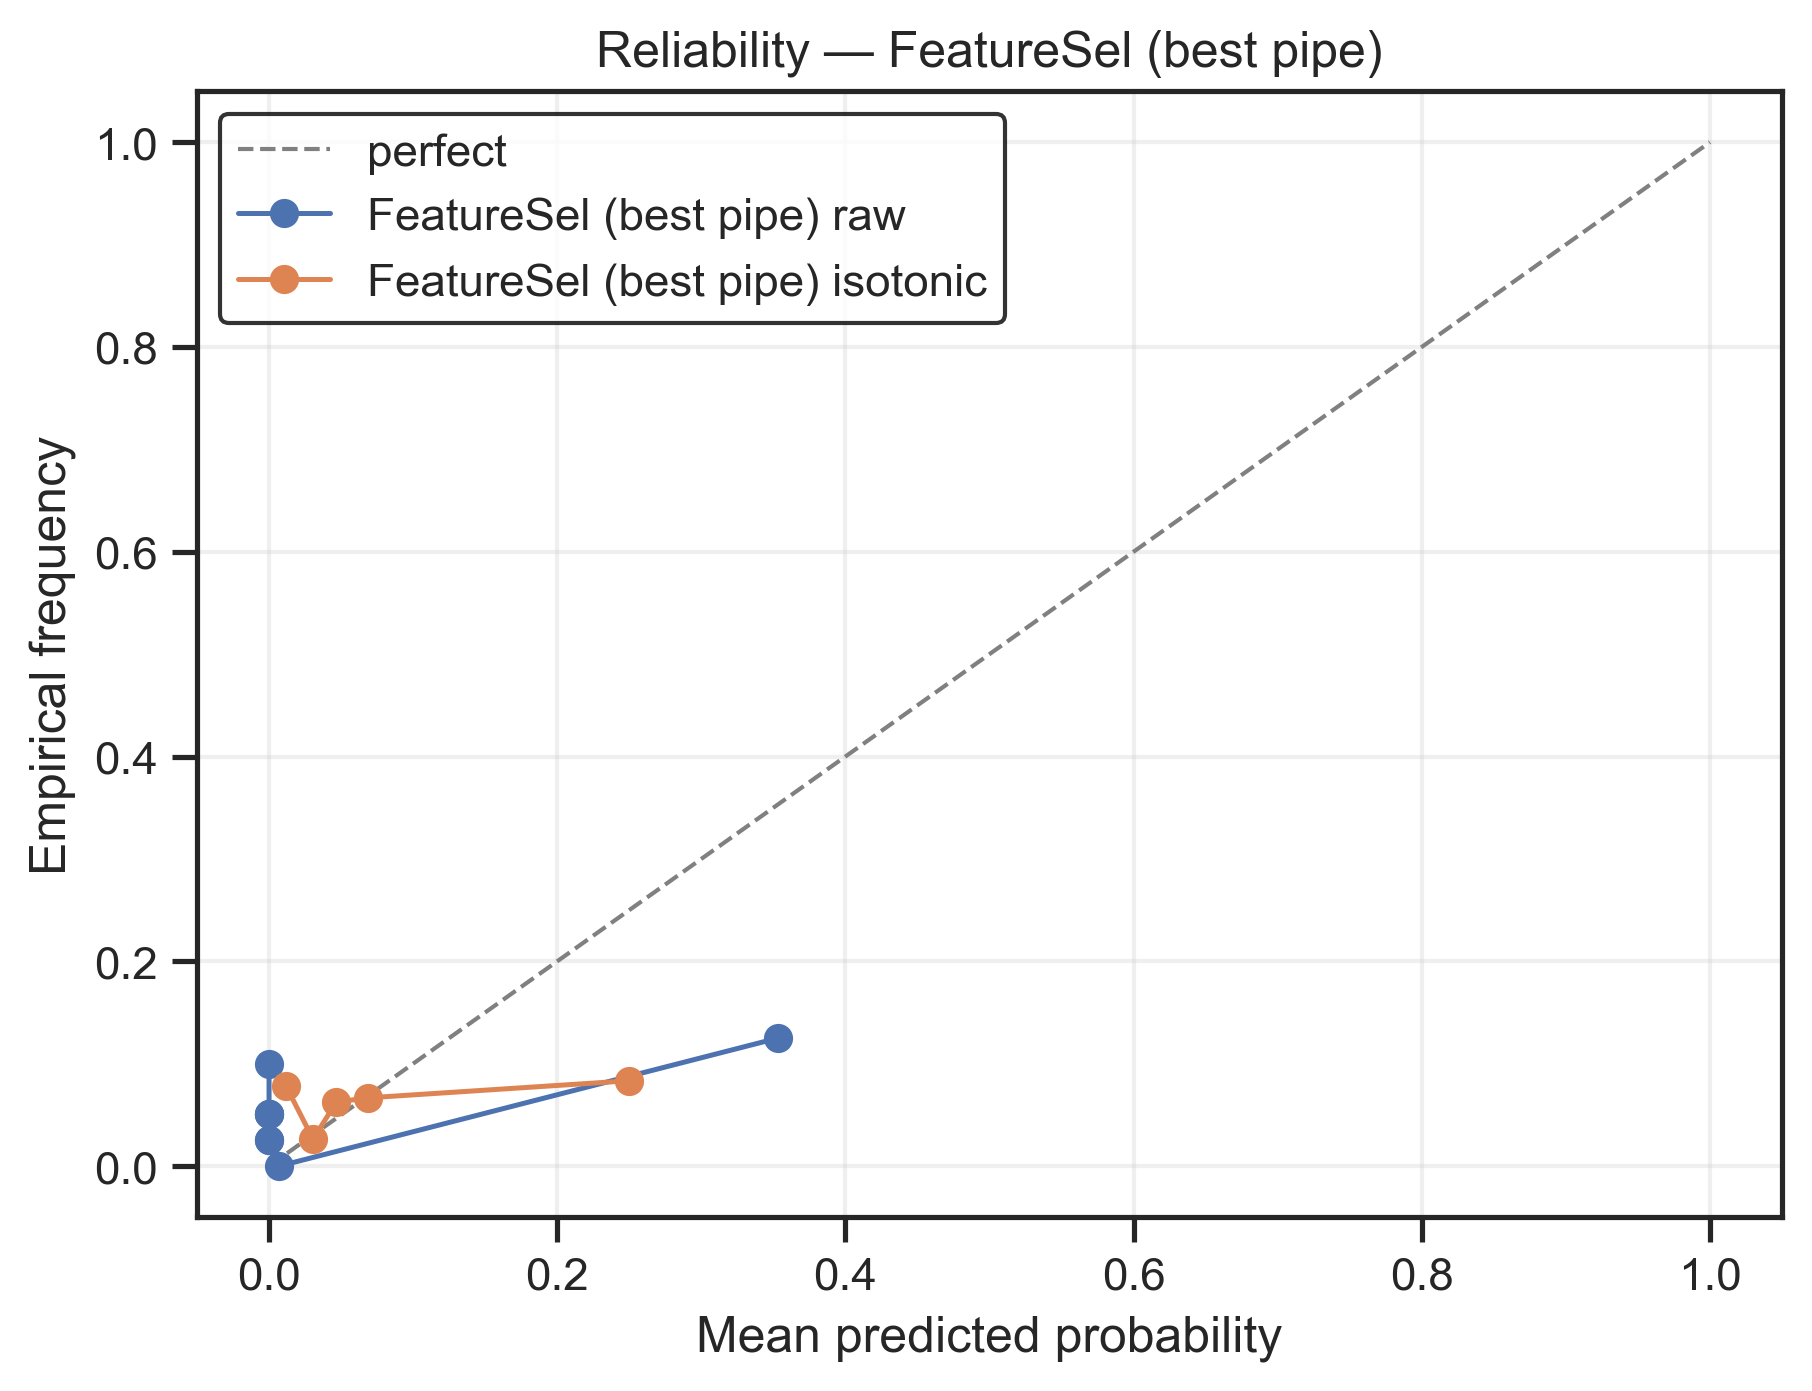

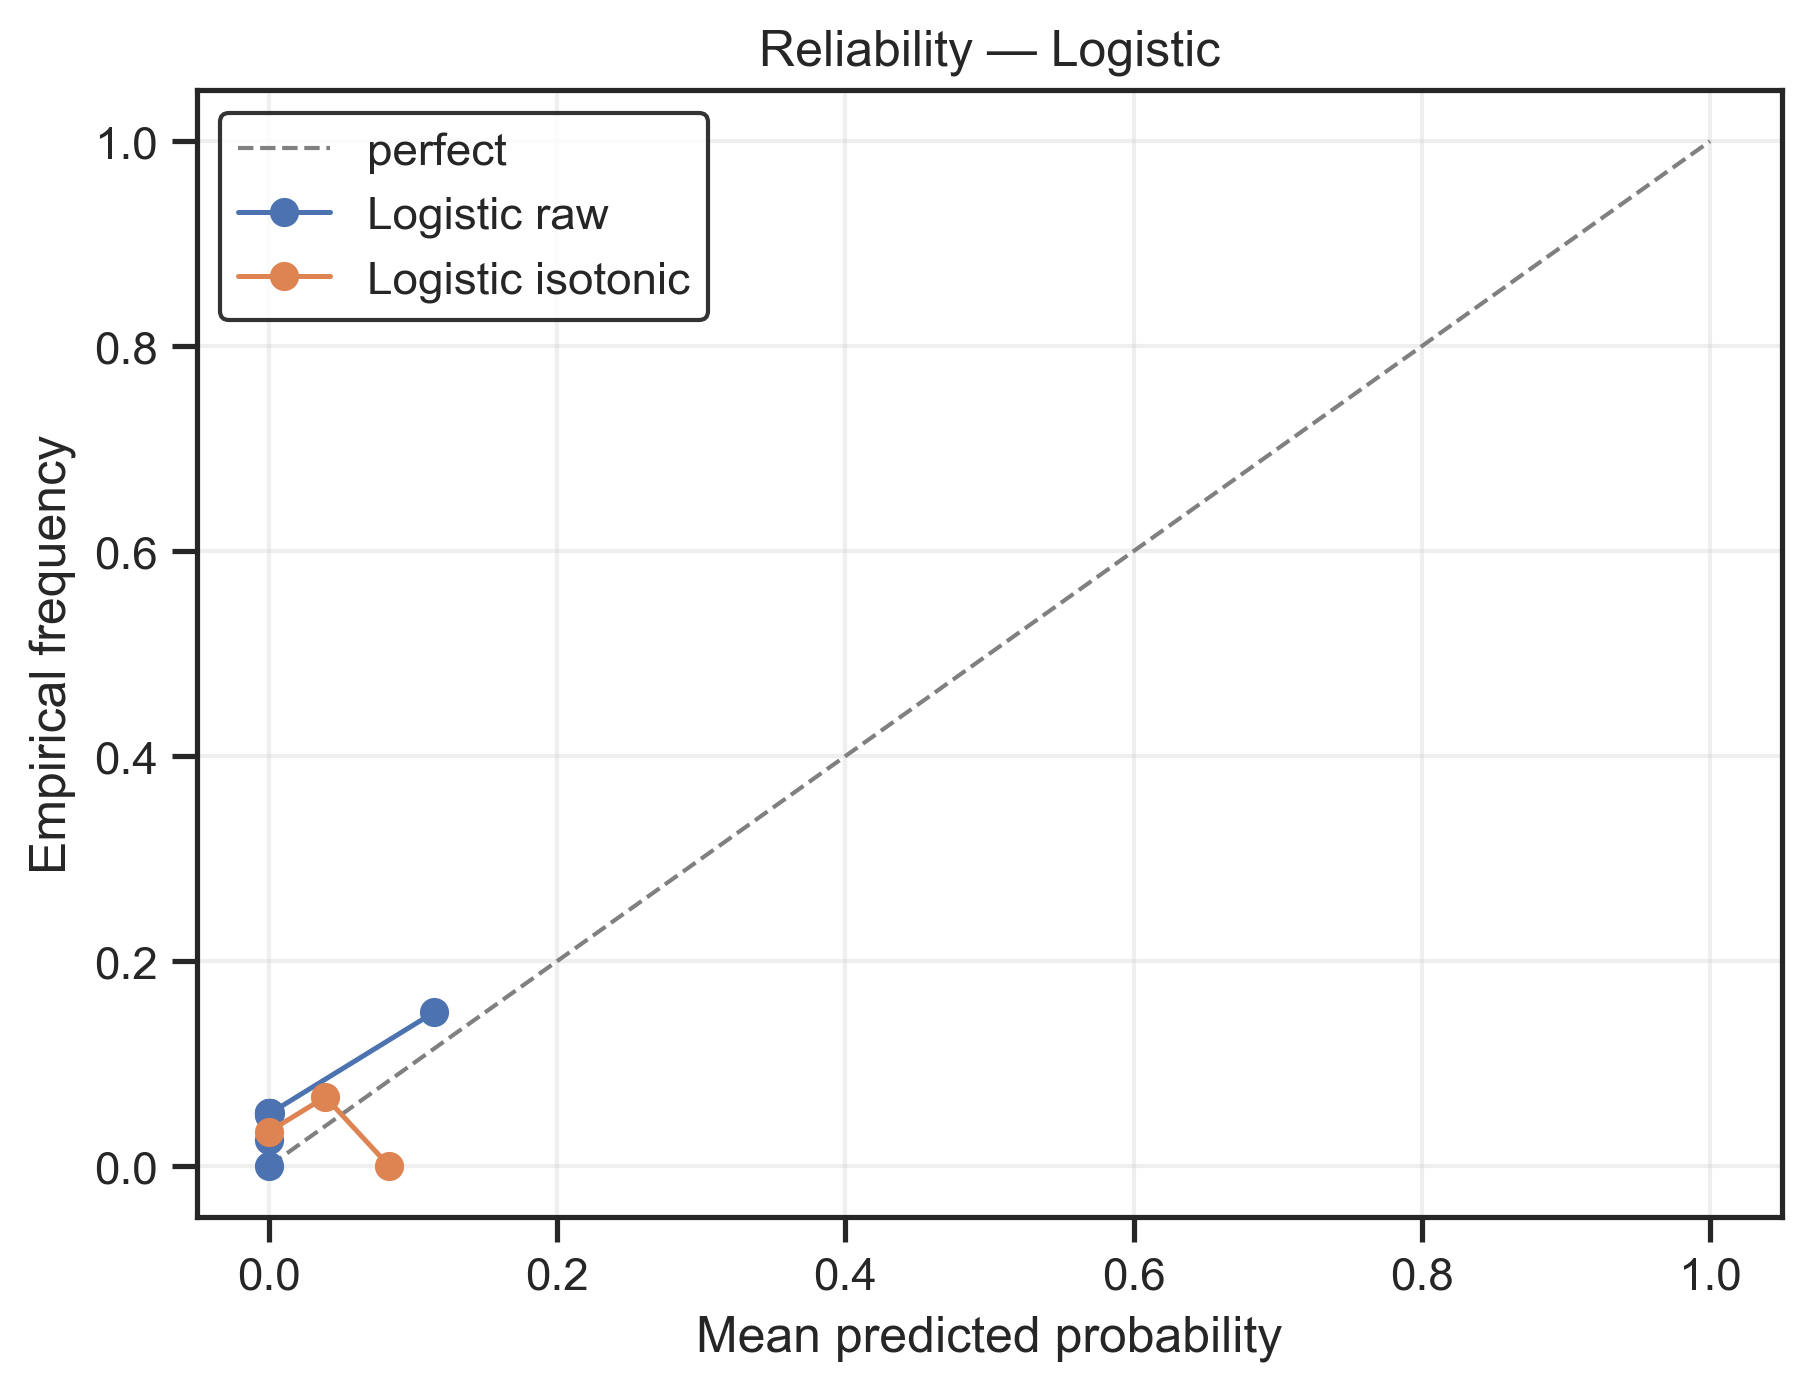

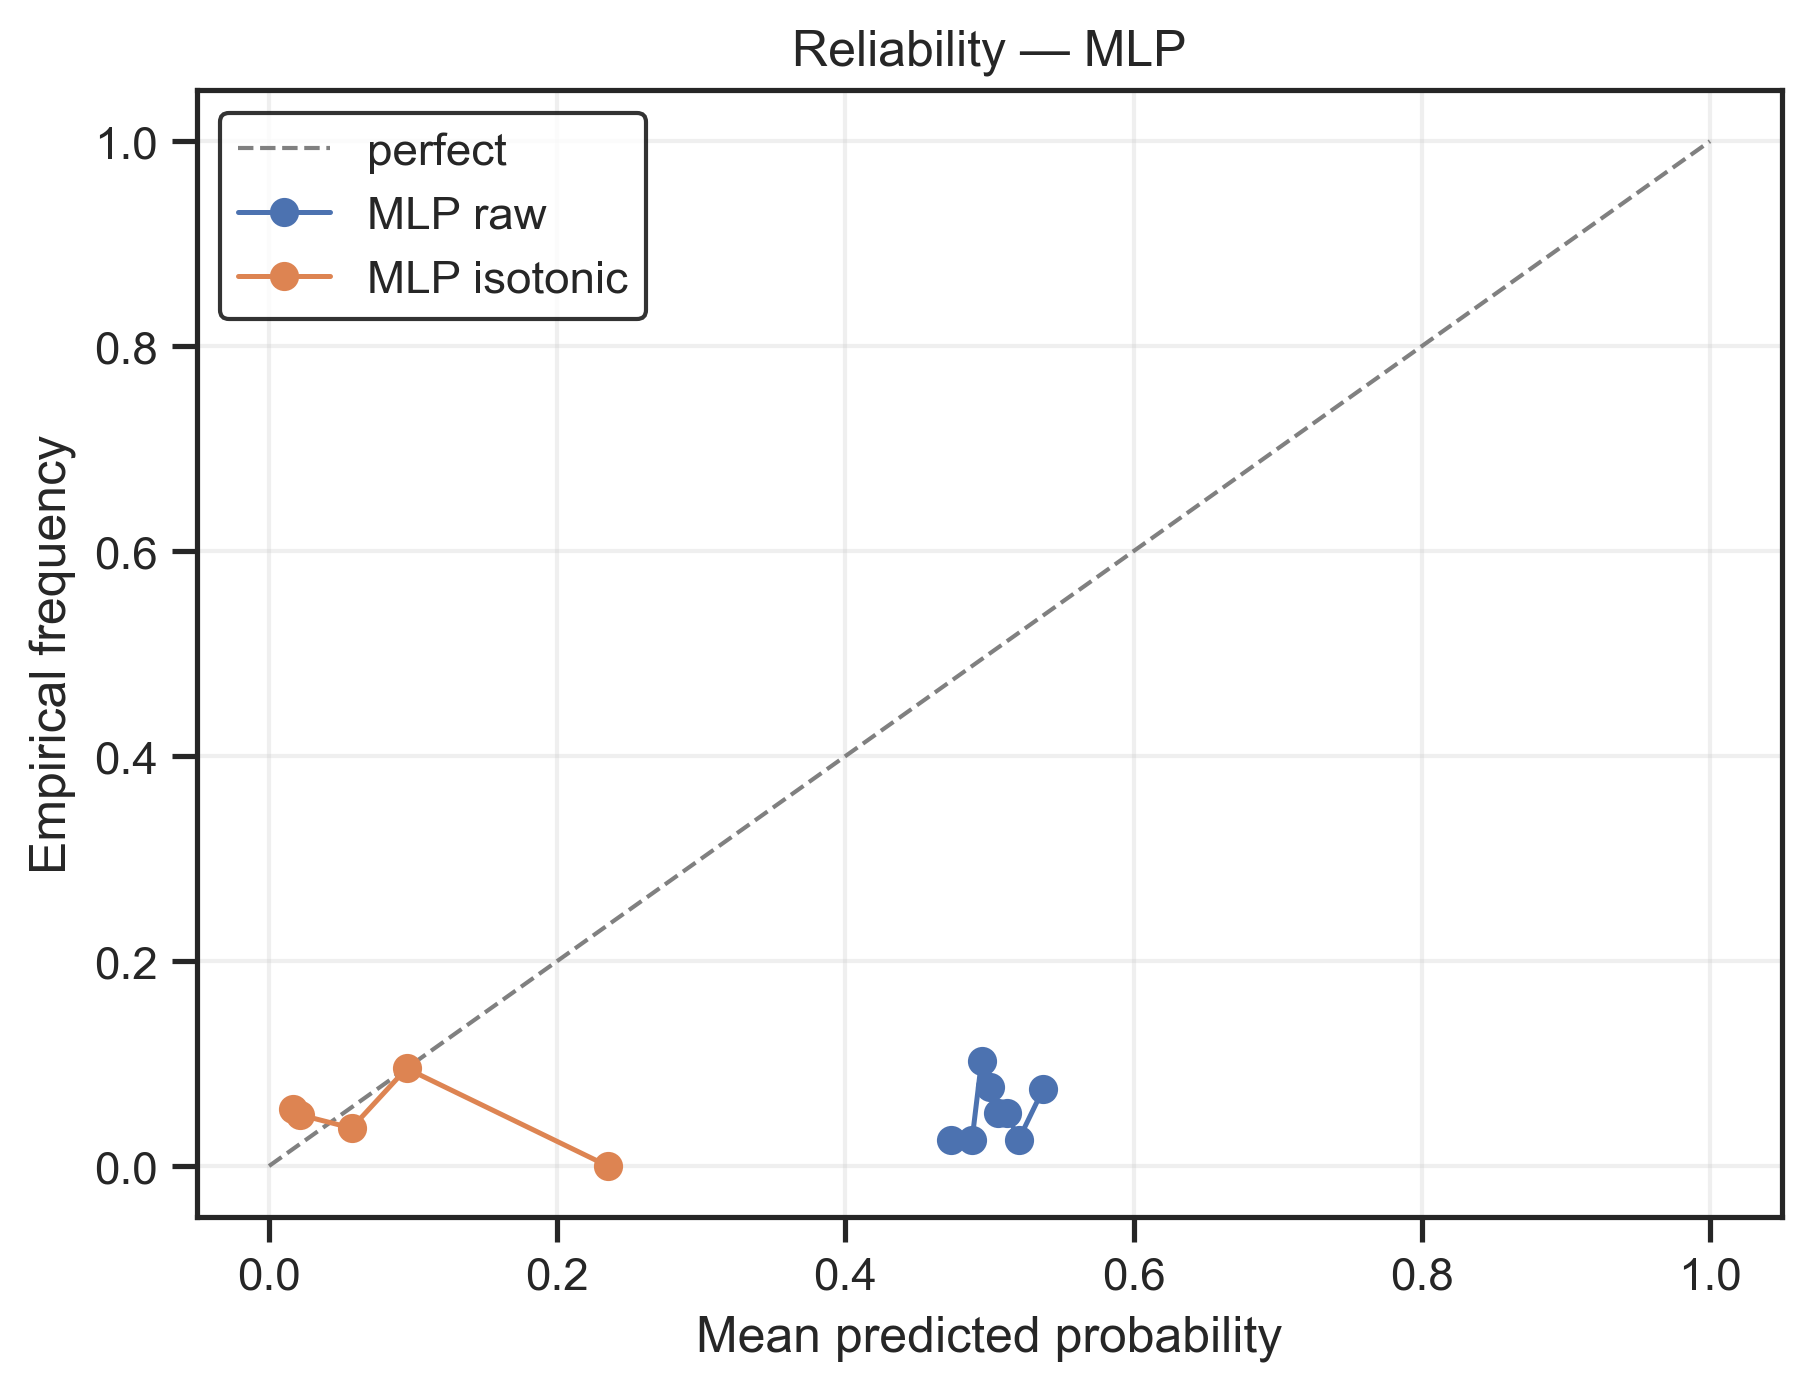

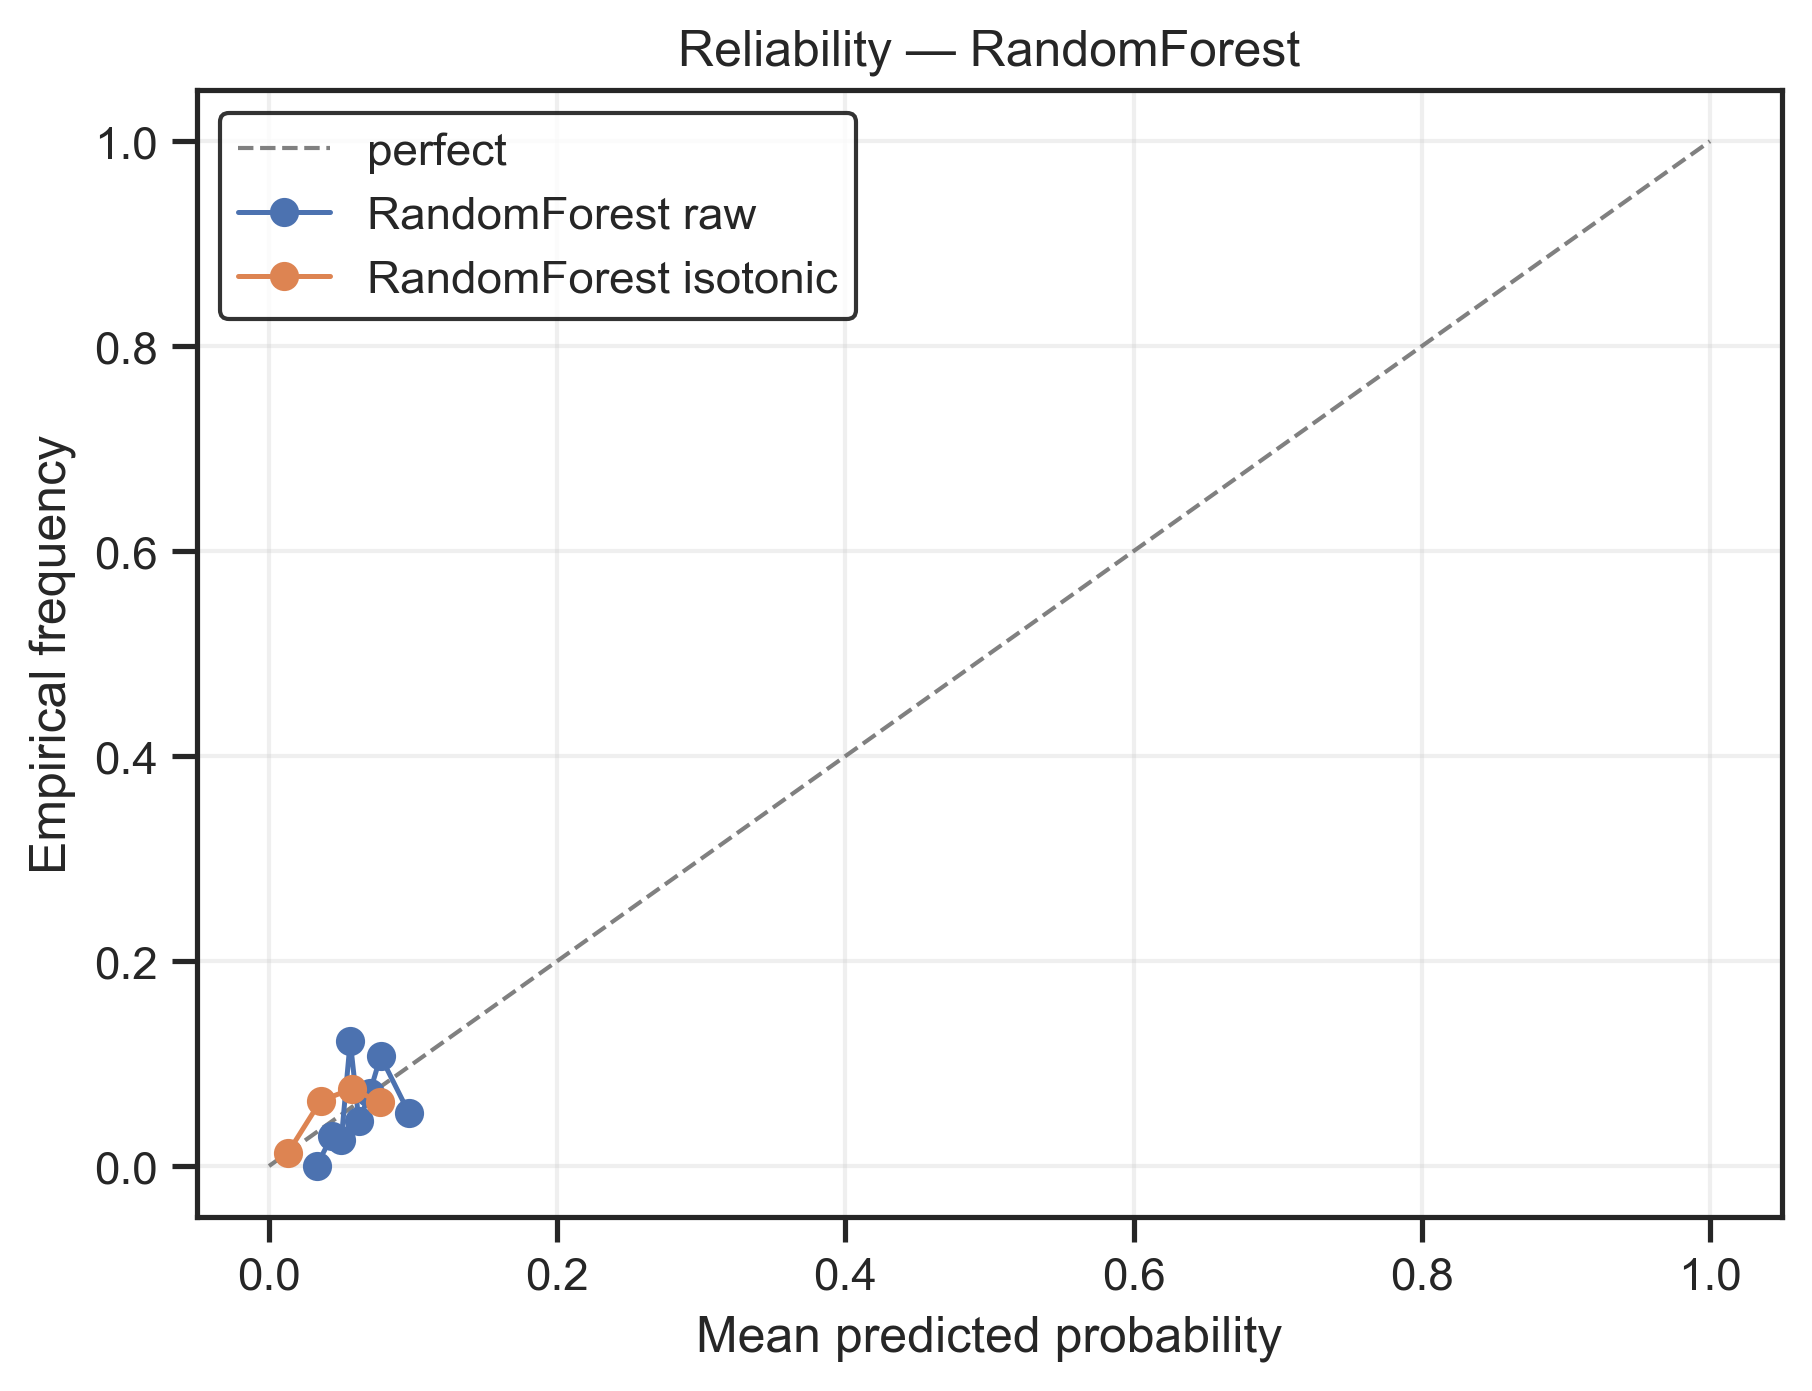

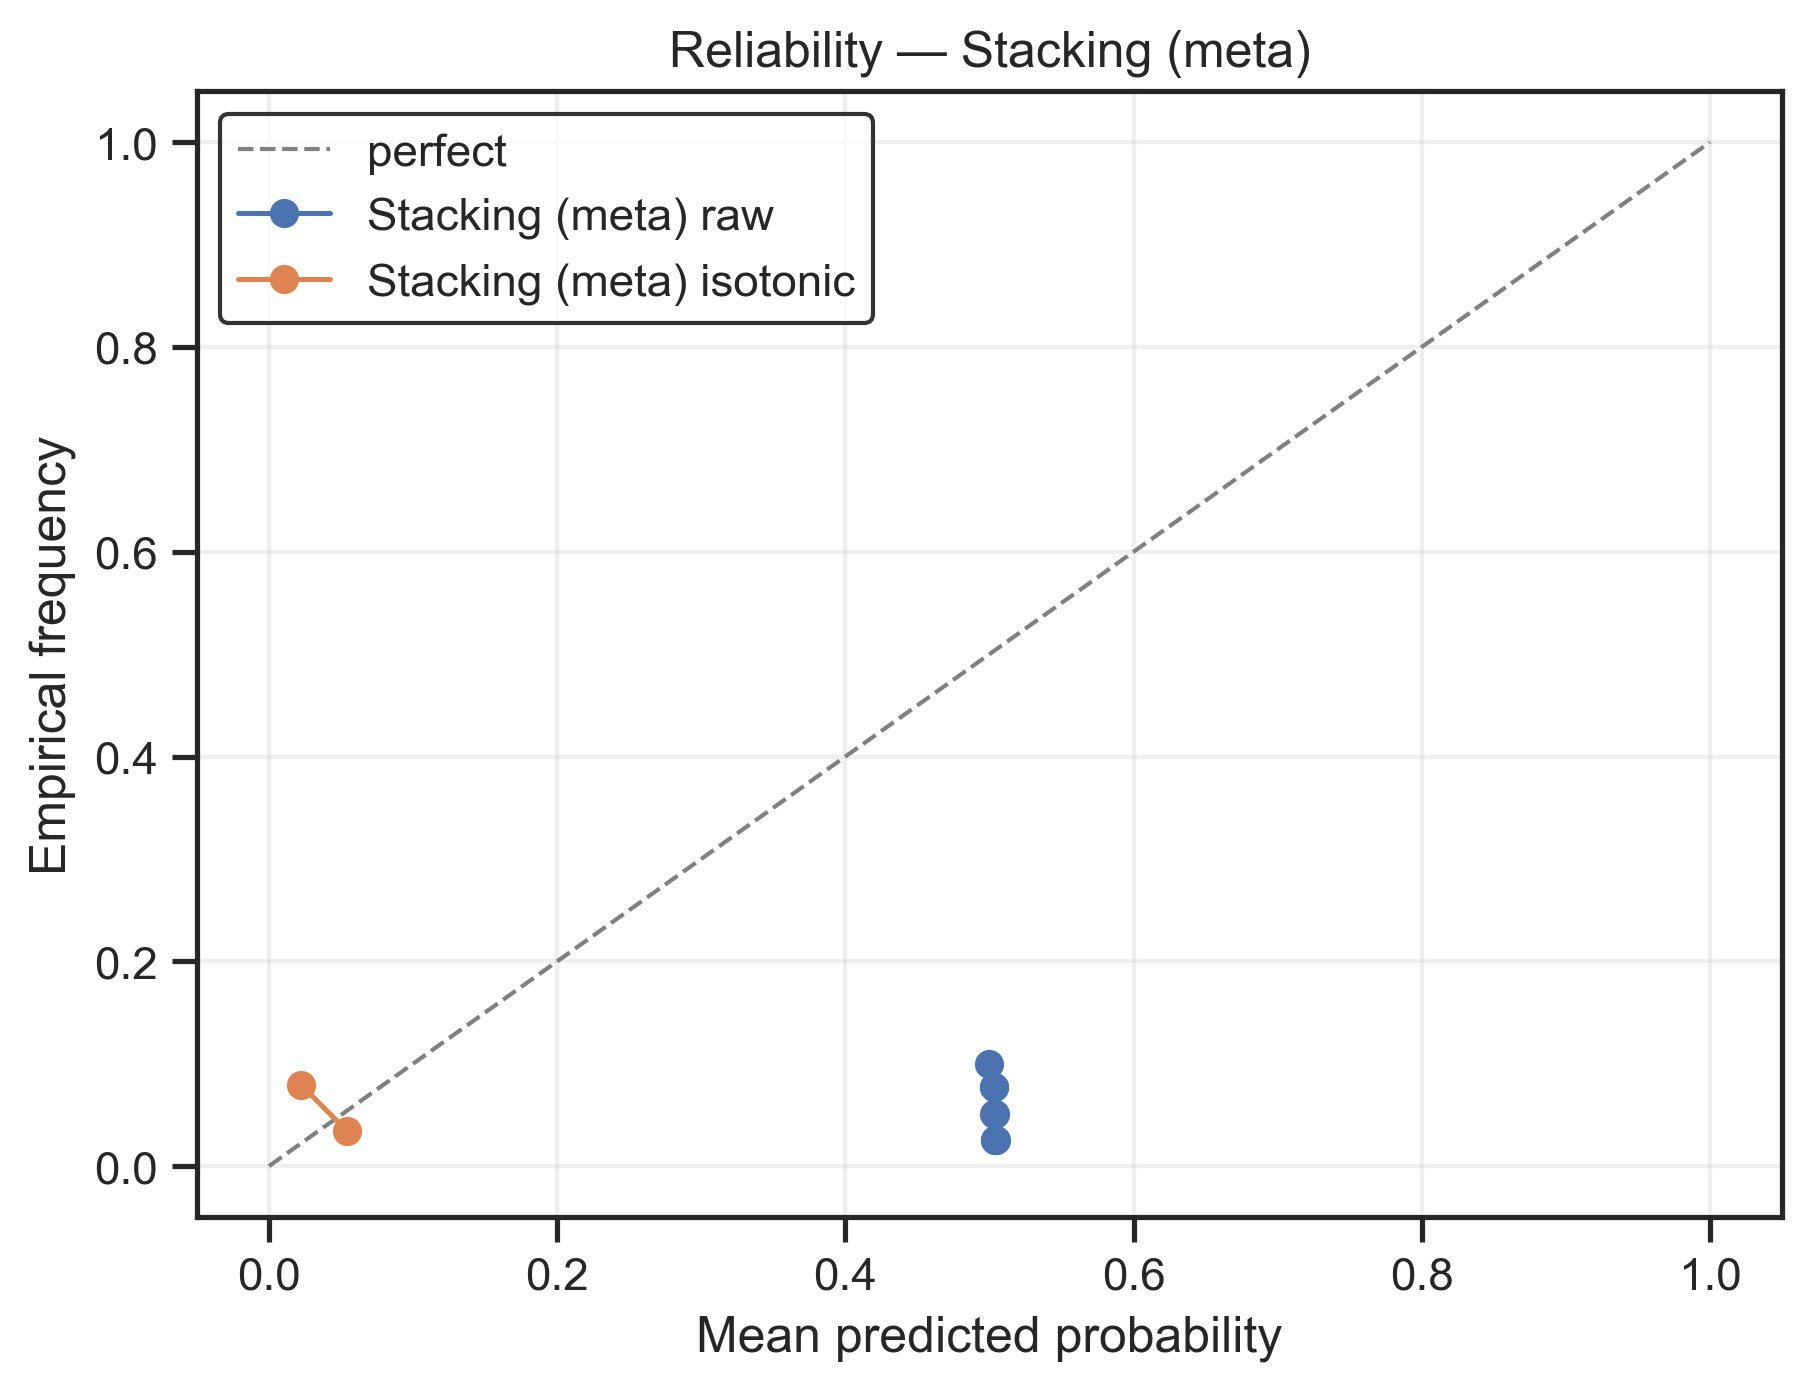

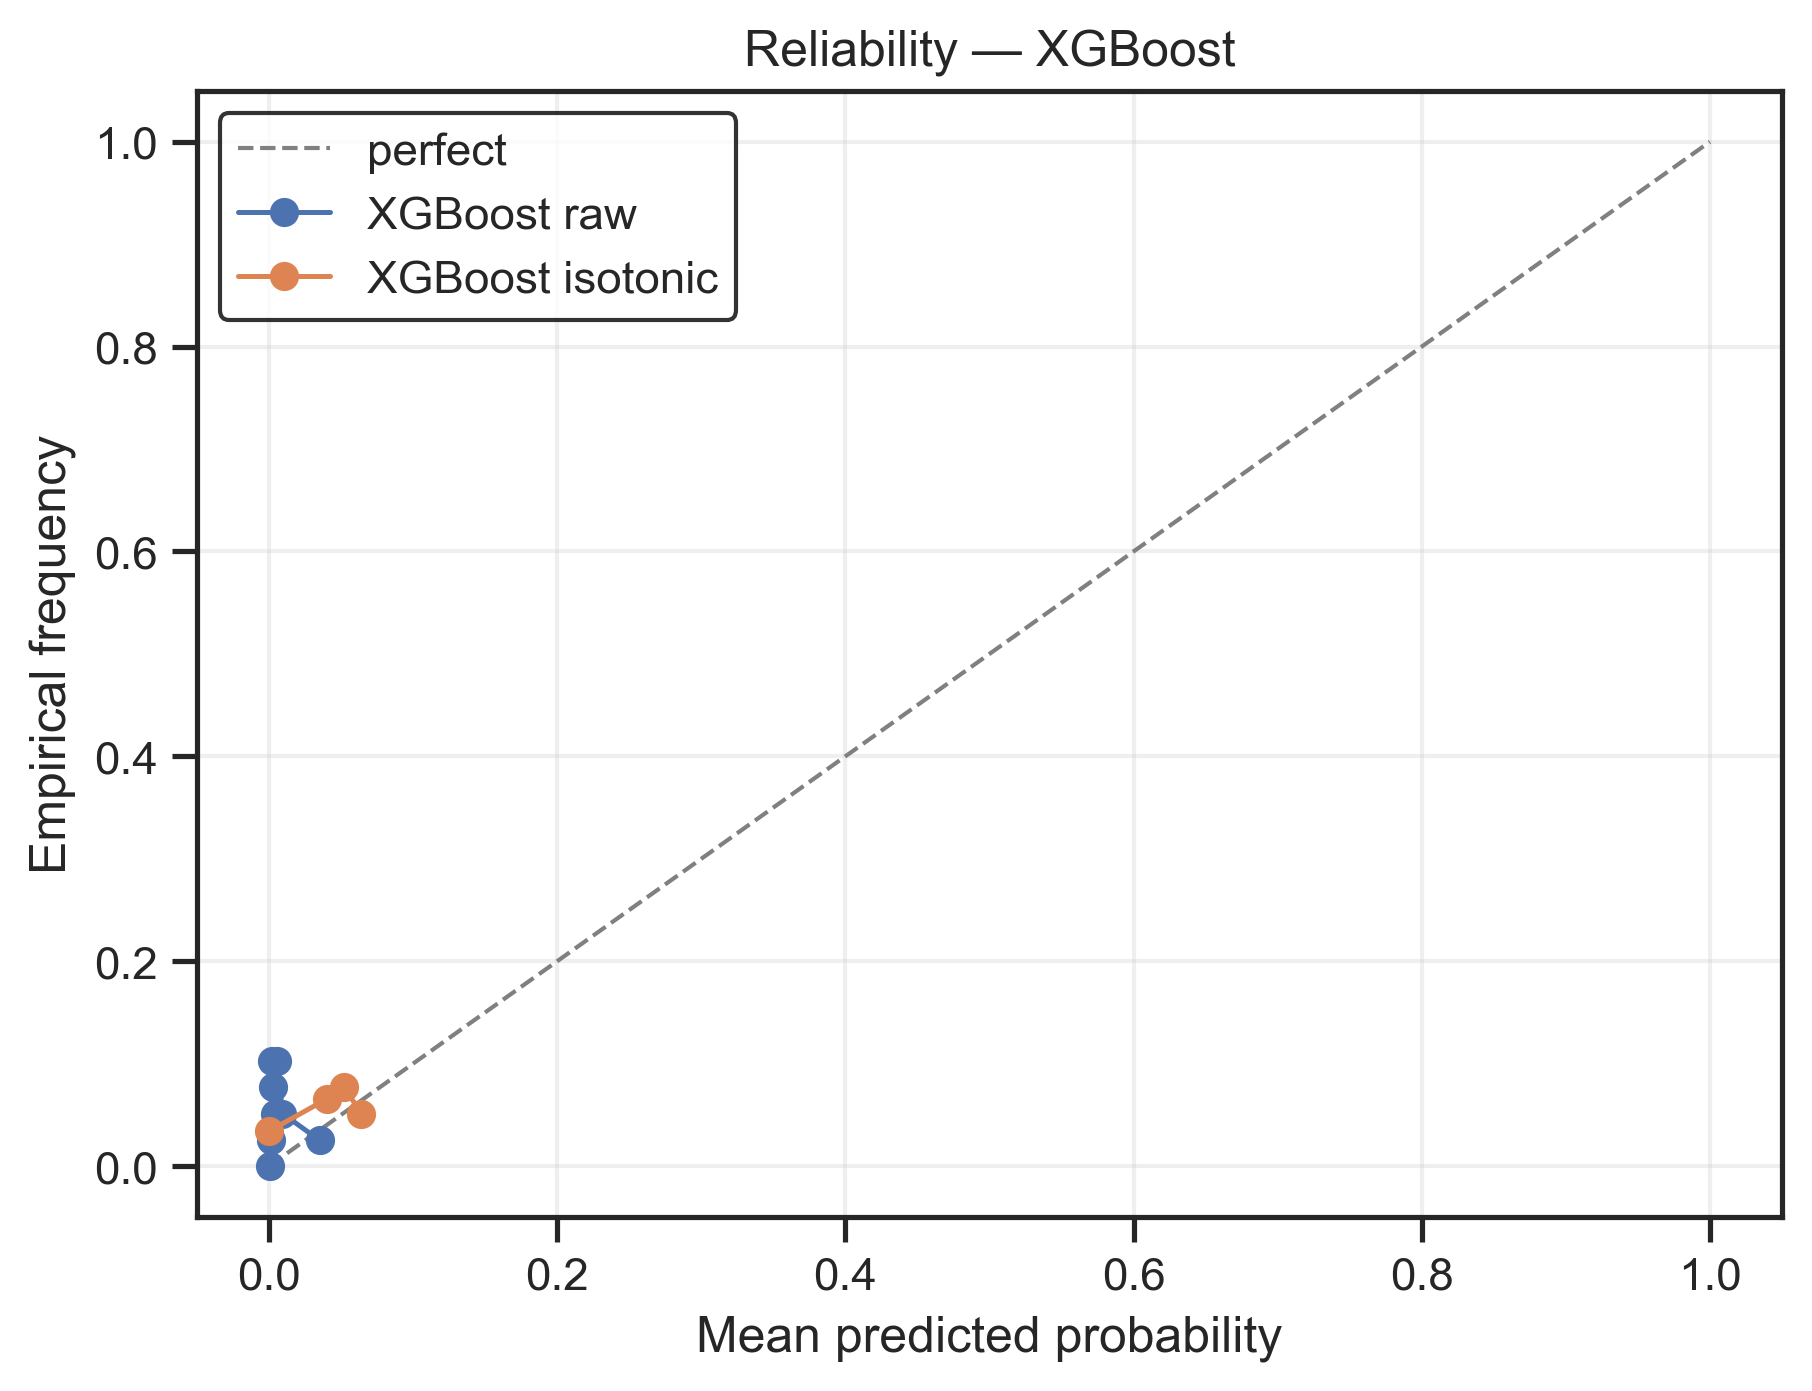

In [7]:
# ---------- Helper: access raw vs calibrated probs ----------
def get_probs(model, split="test", calibrated="raw"):
    """
    split: 'val' or 'test'
    calibrated: 'raw' or 'iso'
    """
    if split not in {"val","test"}:
        raise ValueError("split must be 'val' or 'test'")
    base = val_probs if split=="val" else test_probs

    if calibrated == "iso":
        iso_dict = cal_val_probs if split=="val" else cal_test_probs
        return iso_dict.get(model, base.get(model))
    return base.get(model)

# ---------- Reliability plots (TEST; raw vs isotonic) ----------
def reliability_plot(model, bins=8):
    p_raw = get_probs(model, split="test", calibrated="raw")
    p_iso = get_probs(model, split="test", calibrated="iso")
    if p_raw is None or p_iso is None:
        print(f"[skip] {model} missing probabilities.")
        return
    f_raw, m_raw = calibration_curve(yte, p_raw, n_bins=bins, strategy="quantile")
    f_iso, m_iso = calibration_curve(yte, p_iso, n_bins=bins, strategy="quantile")

    plt.figure(figsize=(6.2, 4.8))
    plt.plot([0,1],[0,1],"--", color="gray", lw=1, label="perfect")
    plt.plot(m_raw, f_raw, "o-", lw=1.2, label=f"{model} raw")
    plt.plot(m_iso, f_iso, "o-", lw=1.2, label=f"{model} isotonic")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Empirical frequency")
    plt.title(f"Reliability — {model}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

for m in sorted(test_probs.keys()):
    reliability_plot(m)

#### Observations
1.	FeatureSel (best pipe)
	- Calibration improved Brier score (0.0758 → 0.0515 on test).
	- PR-AUC and ROC-AUC stayed essentially unchanged.
	- Calibration tightened probability reliability, but not ranking ability.
2.	Logistic Regression
	- Huge shift: Brier drops (0.0625 → 0.0516 test).
	- ROC-AUC dropped (0.6425 → 0.3575) and PR-AUC too (0.1196 → 0.0457).
	- Platt scaling severely distorted ranking here — overfitting on imbalance.
3.	RandomForest
	- Tiny Brier improvement (0.0510 → 0.0516).
	- PR-AUC, ROC-AUC unchanged.
	- RF was already decently calibrated, scaling adds no benefit.
4.	XGBoost
	- Brier improves (0.0540 → 0.0516).
	- ROC-AUC worsens (0.5411 → 0.4589).
	- PR-AUC drops (0.0588 → 0.0486).
	- Same problem as Logistic: calibration harms discriminative ability.
5.	MLP
	- Massive Brier drop (0.2537 → 0.0516).
	- PR-AUC & ROC-AUC unchanged.
	- Raw MLP probabilities were badly miscalibrated, Platt scaling fixed probability reliability without changing ranking.
6.	Stacking
	- Calibration forced Brier down (0.2528 → 0.0516).
	- PR-AUC and ROC-AUC remain poor (~0.042, no ROC reported).
	- Stacking model remains weakest even after calibration.
#### Key Takeaways
- Calibration is valuable for probability reliability (Brier score consistently improves).
- But calibration often hurts ranking metrics (ROC/PR-AUC) in imbalanced settings like SECOM.
- Logistic and XGB are particularly fragile: calibration makes them “overconfident” at low probabilities, degrading ROC/PR.
- RandomForest and FeatureSel are most stable: they retain ranking while modestly improving calibration.
- MLP benefits the most (huge calibration improvement), confirming neural nets tend to output poorly calibrated raw probabilities.

### 2. Decision Curve Analysis (TEST; raw vs isotonic)

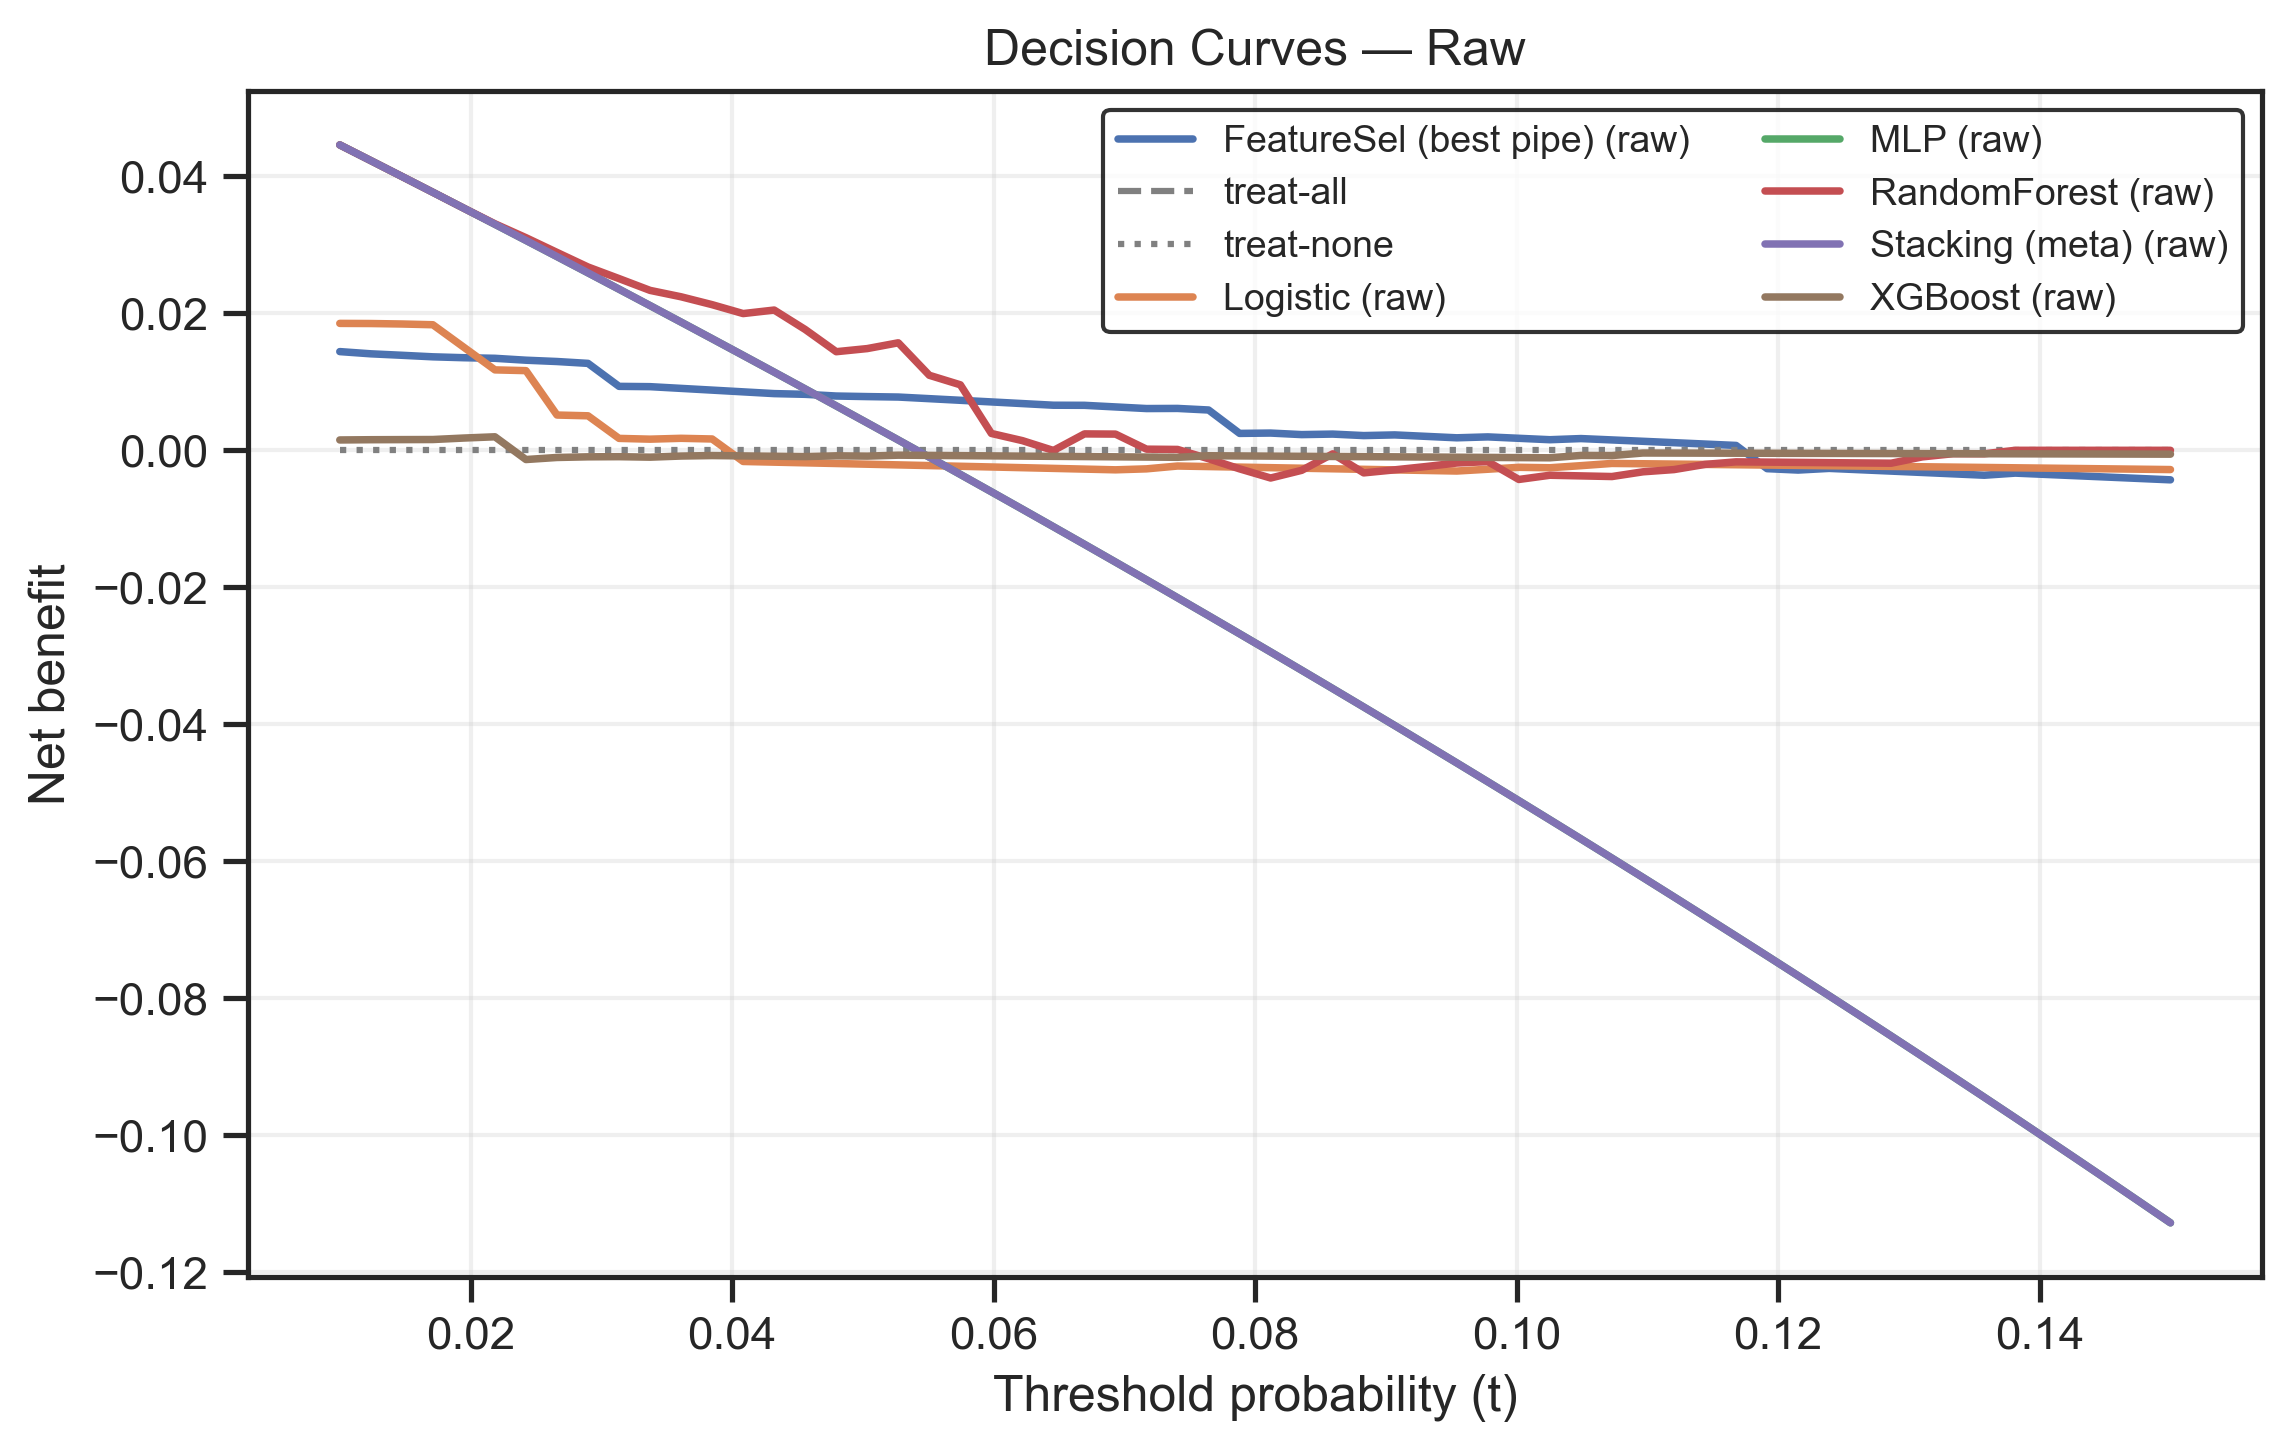

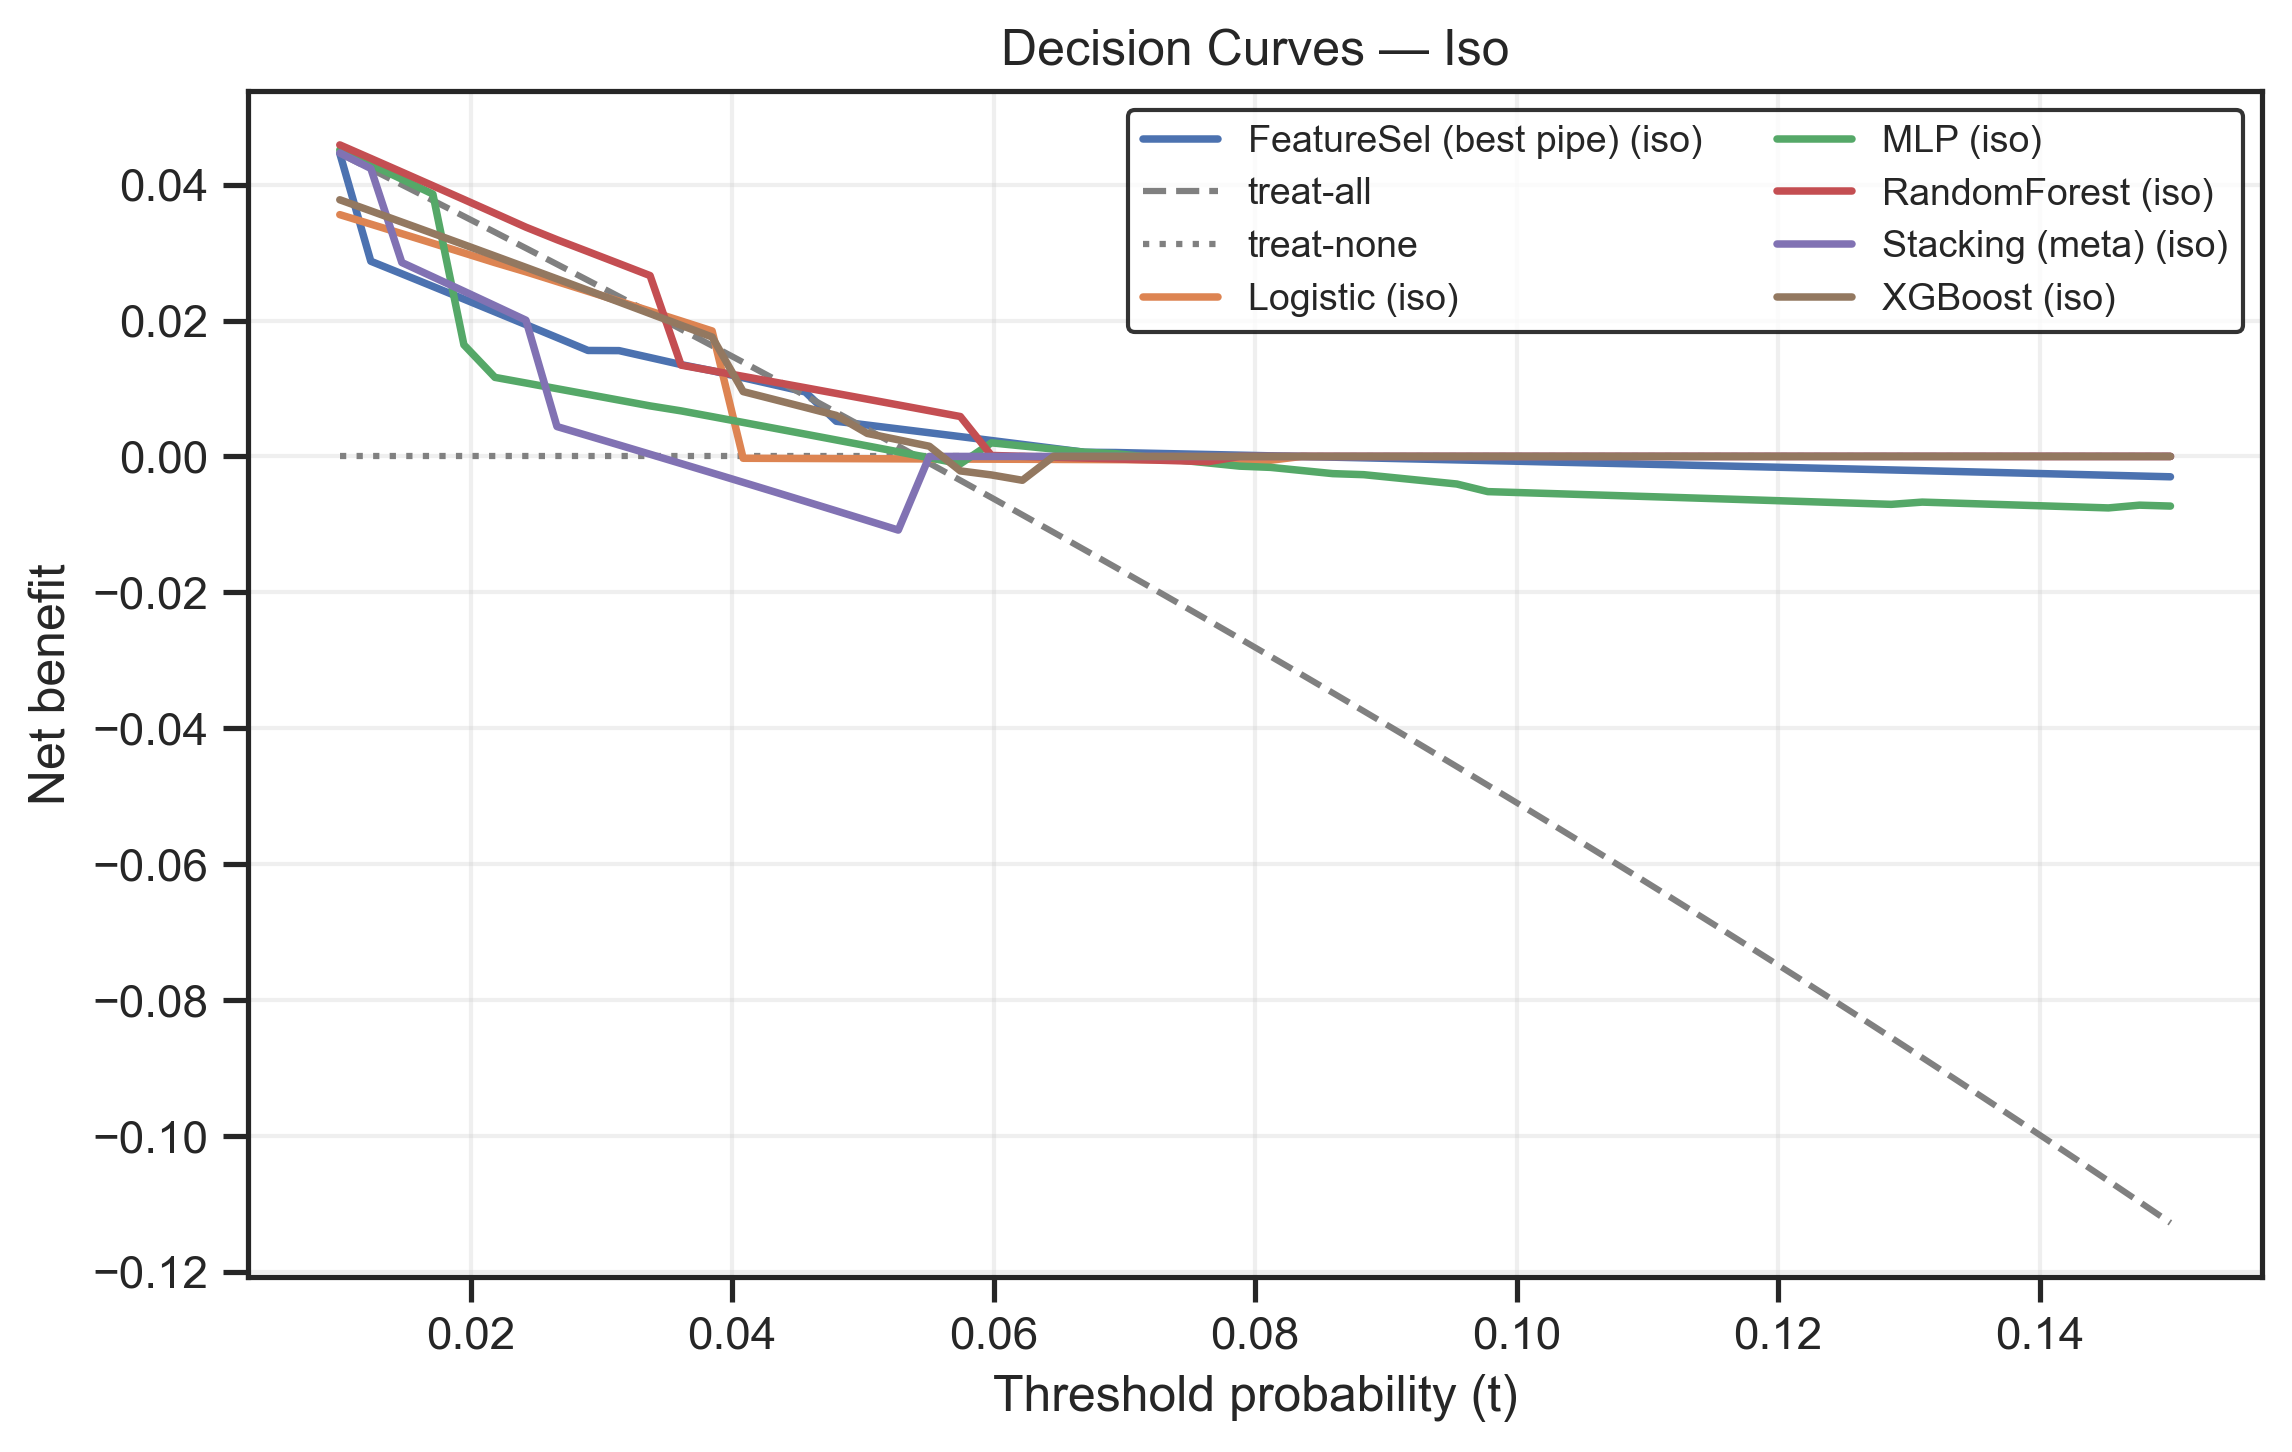

In [8]:
# ---------- Decision Curve Analysis (TEST; raw vs isotonic) ----------
def decision_curve(y, p, thresholds):
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    N = len(y); prev = y.mean()
    out = []
    for t in thresholds:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        w = t / (1.0 - t + 1e-12)
        nb_model = (tp / N) - (fp / N) * w
        nb_all   = prev - (1 - prev) * w
        out.append((t, nb_model, nb_all))
    out = np.array(out)
    return out[:,0], out[:,1], out[:,2]

t_grid = np.linspace(0.01, 0.15, 60)

def plot_dca(models=None, calibrated="raw"):
    if models is None:
        models = sorted(test_probs.keys())

    plt.figure(figsize=(7.8, 5.0))
    show_baselines = True
    for m in models:
        p = get_probs(m, split="test", calibrated=calibrated)
        if p is None: 
            continue
        t, nb, nb_all = decision_curve(yte, p, t_grid)
        plt.plot(t, nb, lw=1.8, label=f"{m} ({calibrated})")
        if show_baselines:
            plt.plot(t, nb_all, "--", color="gray", label="treat-all")
            plt.plot(t, np.zeros_like(t), ":", color="gray", label="treat-none")
            show_baselines = False

    plt.xlabel("Threshold probability (t)")
    plt.ylabel("Net benefit")
    plt.title(f"Decision Curves — {calibrated.capitalize()}")
    plt.grid(True, alpha=0.3); plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()

plot_dca(calibrated="raw")
plot_dca(calibrated="iso")

#### Observations
1. Brier Scores (probability reliability)
	- All models show dramatic Brier score reduction after isotonic calibration (e.g., Logistic 0.0625→0.0519 on test, MLP 0.2537→0.0543).
	- Confirms isotonic calibration substantially improves probability calibration.
2. PR-AUC and ROC-AUC (ranking metrics)
	- Gains on validation are stronger (e.g., Logistic ROC-AUC 0.415→0.598, PR-AUC 0.0359→0.0452).
	- On test, results are mixed:
	- Logistic’s PR-AUC drops (0.1196→0.0642), ROC-AUC slightly down (0.6425→0.576).
	- MLP and XGB maintain or slightly reduce AUCs, but not catastrophic.
	- RandomForest essentially unchanged (0.6172→0.6173).
	- Stacking improves slightly but remains the weakest.
3. Reliability Plots
	- Pre-calibration: most models’ predicted probabilities are overconfident or poorly aligned (e.g., MLP far from diagonal).
	- Post-calibration: isotonic mapping pulls them closer to the diagonal → better probability calibration.
	- Logistic and XGB show over-smoothing — isotonic brings curves closer but loses discriminative sharpness.
4. Decision Curve Analysis (DCA)
	- Raw models: RandomForest, FeatureSel, and Logistic provided small positive net benefits at very low thresholds (<0.05). MLP and Stacking are unstable.
	- Isotonic models: curves flatten out — calibration improves calibration error but often reduces clinical/operational net benefit beyond very low thresholds.
	- Overall, isotonic calibration seems to favor probability interpretability at the cost of decision utility in some regions.

#### Key Outcomes
- Calibration (Brier ↓): all models benefit → isotonic is especially valuable for MLP and Logistic.
- Ranking (AUCs): mixed — Logistic and XGB lose discriminative sharpness, RF is stable, MLP sees slight ROC drop.
- Reliability plots: isotonic improves alignment, but sometimes at cost of model spread.
- DCA: calibrated probabilities reduce net benefit curves; models become more conservative, reflecting the trade-off.

#### Insights
- Use isotonic when calibrated probabilities are needed (e.g., risk estimates, expected yield loss, probability-driven thresholds).
- Don’t rely solely on isotonic if ranking is critical (e.g., prioritizing top-N wafers). Logistic and XGB clearly lose ROC/PR-AUC.
- RandomForest emerges as the most stable candidate: gains calibration without hurting ranking or decision curves.
- Stacking remains weak: isotonic helps a bit but still underperforms all other models.
- MLP benefits hugely in calibration reliability, making it usable for probabilistic outputs (despite weaker raw ranking).

#### Summary
- Probability reliability improved across all models (Brier scores consistently decreased).
- Discriminative power (PR/ROC-AUC) is model-dependent:
	- Logistic & XGB: isotonic helps calibration but hurts ranking.
	- RandomForest: robust under isotonic, best all-rounder.
	- MLP: biggest calibration gains, but AUC still modest.
	- Stacking: remains unreliable.
- Operationally (DCA): isotonic probabilities are safer for probability-based decision thresholds, but raw models often yield higher net benefit when the goal is catching fails at low thresholds.

#### Executive takeaway:
- If the fab requires trustworthy failure probabilities, isotonic calibration is worth applying.
- If the fab needs maximal fail detection utility (net benefit in decision curves), calibrated models may underperform raw models — RF raw or FeatureSel raw remain preferable.

In [9]:
# === Dynamic comparison: Raw vs Isotonic (VAL/TEST + DCA summary) ===
def _delta(a_cal, a_raw): 
    return float(a_cal) - float(a_raw)

# 1) Start from df_iso already computed
cols_keep = [
    "Model",
    "Brier_VAL_raw","Brier_VAL_cal",
    "PRAUC_VAL_raw","PRAUC_VAL_cal",
    "ROCAUC_VAL_raw","ROCAUC_VAL_cal",
    "Brier_TEST_raw","Brier_TEST_cal",
    "PRAUC_TEST_raw","PRAUC_TEST_cal",
    "ROCAUC_TEST_raw","ROCAUC_TEST_cal"
]
tbl = df_iso[cols_keep].copy()

# 2) Add VAL/TEST deltas (calibrated - raw)
tbl["ΔBrier_VAL"] = tbl["Brier_VAL_cal"] - tbl["Brier_VAL_raw"]          # negative is better
tbl["ΔPR_AUC_VAL"] = tbl["PRAUC_VAL_cal"] - tbl["PRAUC_VAL_raw"]
tbl["ΔROC_AUC_VAL"] = tbl["ROCAUC_VAL_cal"] - tbl["ROCAUC_VAL_raw"]

tbl["ΔBrier_TEST"] = tbl["Brier_TEST_cal"] - tbl["Brier_TEST_raw"]        # negative is better
tbl["ΔPR_AUC_TEST"] = tbl["PRAUC_TEST_cal"] - tbl["PRAUC_TEST_raw"]
tbl["ΔROC_AUC_TEST"] = tbl["ROCAUC_TEST_cal"] - tbl["ROCAUC_TEST_raw"]

# 3) Decision-curve utility summary: area under net benefit (AUNB) on TEST
def aunb_for(model, calibrated="raw", thresholds=None):
    if thresholds is None:
        thresholds = t_grid
    p = get_probs(model, split="test", calibrated=calibrated)
    if p is None:
        return np.nan
    t, nb, _nb_all = decision_curve(yte, p, thresholds)
    # simple trapezoidal area over threshold range
    return float(np.trapz(nb, t))

tbl["AUNB_raw"] = tbl["Model"].apply(lambda m: aunb_for(m, "raw", t_grid))
tbl["AUNB_iso"] = tbl["Model"].apply(lambda m: aunb_for(m, "iso", t_grid))
tbl["ΔAUNB"]    = tbl["AUNB_iso"] - tbl["AUNB_raw"]

# 4) Nicely formatted view
view_cols = [
    "Model",
    # TEST metrics first (often primary)
    "Brier_TEST_raw","Brier_TEST_cal","ΔBrier_TEST",
    "PRAUC_TEST_raw","PRAUC_TEST_cal","ΔPR_AUC_TEST",
    "ROCAUC_TEST_raw","ROCAUC_TEST_cal","ΔROC_AUC_TEST",
    # VAL (diagnostic)
    "Brier_VAL_raw","Brier_VAL_cal","ΔBrier_VAL",
    "PRAUC_VAL_raw","PRAUC_VAL_cal","ΔPR_AUC_VAL",
    "ROCAUC_VAL_raw","ROCAUC_VAL_cal","ΔROC_AUC_VAL",
    # DCA summary
    "AUNB_raw","AUNB_iso","ΔAUNB"
]
tbl_view = (tbl[view_cols]
            .sort_values(["ΔBrier_TEST","ΔAUNB"], ascending=[True, False])  # best: lower ΔBrier, higher ΔAUNB
            .reset_index(drop=True)
            .round(4))

display(tbl_view)

# Optional: quick legend for interpretation
print("Notes: Δ values are (calibrated − raw). For Brier and ΔBrier, more negative = better; for AUCs and ΔAUNB, more positive = better.")

Model  Brier_TEST_raw  Brier_TEST_cal  ΔBrier_TEST  \
0         Stacking (meta)          0.2528          0.0525      -0.2003   
1                     MLP          0.2537          0.0543      -0.1994   
2  FeatureSel (best pipe)          0.0758          0.0527      -0.0231   
3                Logistic          0.0625          0.0519      -0.0106   
4                 XGBoost          0.0540          0.0516      -0.0024   
5            RandomForest          0.0510          0.0510       0.0000   

   PRAUC_TEST_raw  PRAUC_TEST_cal  ΔPR_AUC_TEST  ROCAUC_TEST_raw  \
0          0.0421          0.0438        0.0017           0.3583   
1          0.0623          0.0604       -0.0019           0.5391   
2          0.0832          0.0613       -0.0219           0.5249   
3          0.1196          0.0642       -0.0554           0.6425   
4          0.0588          0.0570       -0.0018           0.5411   
5          0.0715          0.0696       -0.0019           0.6172   

   ROCAUC_TEST_cal  ΔROC_AUC_TEST  ...  ΔBrier_VAL  PRAUC_VAL_raw  \
0           0.3715         0.0132  ...     -0.2172         0.0408   
1           0.5170        -0.0221  ...     -0.2184         0.0847   
2           0.5182        -0.0067  ...     -0.0064         0.0712   
3           0.5760        -0.0665  ...     -0.0756         0.0359   
4           0.5379        -0.0032  ...     -0.0017         0.0528   
5           0.6173         0.0001  ...     -0.0010         0.0531   

   PRAUC_VAL_cal  ΔPR_AUC_VAL  ROCAUC_VAL_raw  ROCAUC_VAL_cal  ΔROC_AUC_VAL  \
0         0.0506       0.0098          0.5433          0.6472        0.1039   
1         0.0914       0.0067          0.6321          0.7170        0.0849   
2         0.0753       0.0041          0.5924          0.6707        0.0783   
3         0.0452       0.0093          0.4154          0.5980        0.1826   
4         0.0598       0.0070          0.6415          0.7073        0.0658   
5         0.0554       0.0023          0.6230          0.6737        0.0507   

   AUNB_raw  AUNB_iso   ΔAUNB  
0   -0.0042    0.0004  0.0046  
1   -0.0042    0.0002  0.0044  
2    0.0006    0.0007  0.0001  
3    0.0000    0.0008  0.0008  
4   -0.0001    0.0009  0.0010  
5    0.0011    0.0011  0.0000  

[6 rows x 22 columns]

Notes: Δ values are (calibrated − raw). For Brier and ΔBrier, more negative = better; for AUCs and ΔAUNB, more positive = better.


### Calibration Outcomes — Raw vs Isotonic

| Model                  | ΔBrier (↓ better) | ΔPR-AUC (val → test)       | ΔROC-AUC (val → test)       | DCA effect (qualitative)                         |
|-------------------------|-------------------|----------------------------|-----------------------------|--------------------------------------------------|
| **Logistic**            | 0.0625 → 0.0519  | +0.009 (val), **–0.056** (test) | +0.183 (val), **–0.066** (test) | Reliability improved, but **ranking weakened** (loss of net benefit at higher thresholds). |
| **RandomForest**        | 0.0510 → 0.0510  | +0.002 (val), –0.002 (test) | +0.051 (val), ≈0 (test)     | **Most stable**: calibration helps reliability, AUCs unchanged, DCA curves largely preserved. |
| **XGBoost**             | 0.0540 → 0.0516  | +0.007 (val), –0.002 (test) | +0.066 (val), **–0.024** (test) | Calibration smooths probs but hurts discrimination, **net benefit drops**. |
| **MLP**                 | 0.2537 → 0.0543  | +0.007 (val), –0.002 (test) | +0.085 (val), **–0.022** (test) | **Biggest calibration gain** (Brier ↓ massively), reliability improves, but DCA flatter. |
| **FeatureSel (best pipe)** | 0.0758 → 0.0527  | +0.004 (val), **–0.022** (test) | +0.078 (val), –0.007 (test) | Calibration improves calibration error, small loss in PR-AUC, DCA flatter. |
| **Stacking (meta)**     | 0.2528 → 0.0525  | +0.010 (val), +0.002 (test) | +0.104 (val), +0.013 (test) | Improves calibration reliability, but still **weak overall**. |

---

### **Key Takeaways**
- **Calibration (Brier scores)**: Strongly improves reliability for all models — most dramatic for **MLP** and **Stacking**.  
- **Ranking metrics (AUCs)**: Gains on validation, but **losses on test** for Logistic and XGBoost (sensitive to imbalance).  
- **RandomForest = most robust**: calibration improves reliability **without hurting AUCs or decision curves**.  
- **MLP**: unusable raw, but isotonic rescues probability reliability → still modest in PR/ROC terms.  
- **DCA**: calibrated models yield flatter curves (more conservative), while **raw RF and FeatureSel retain net benefit** at low thresholds.  

> **Executive insight:**  
> - Use **isotonic-calibrated models** when probability reliability is critical (e.g., expected scrap risk).  
> - Prefer **raw RandomForest / FeatureSel** when decision-curve utility (fail detection benefit) is prioritized.

### 3. Compact forest-style plot for calibration deltas.

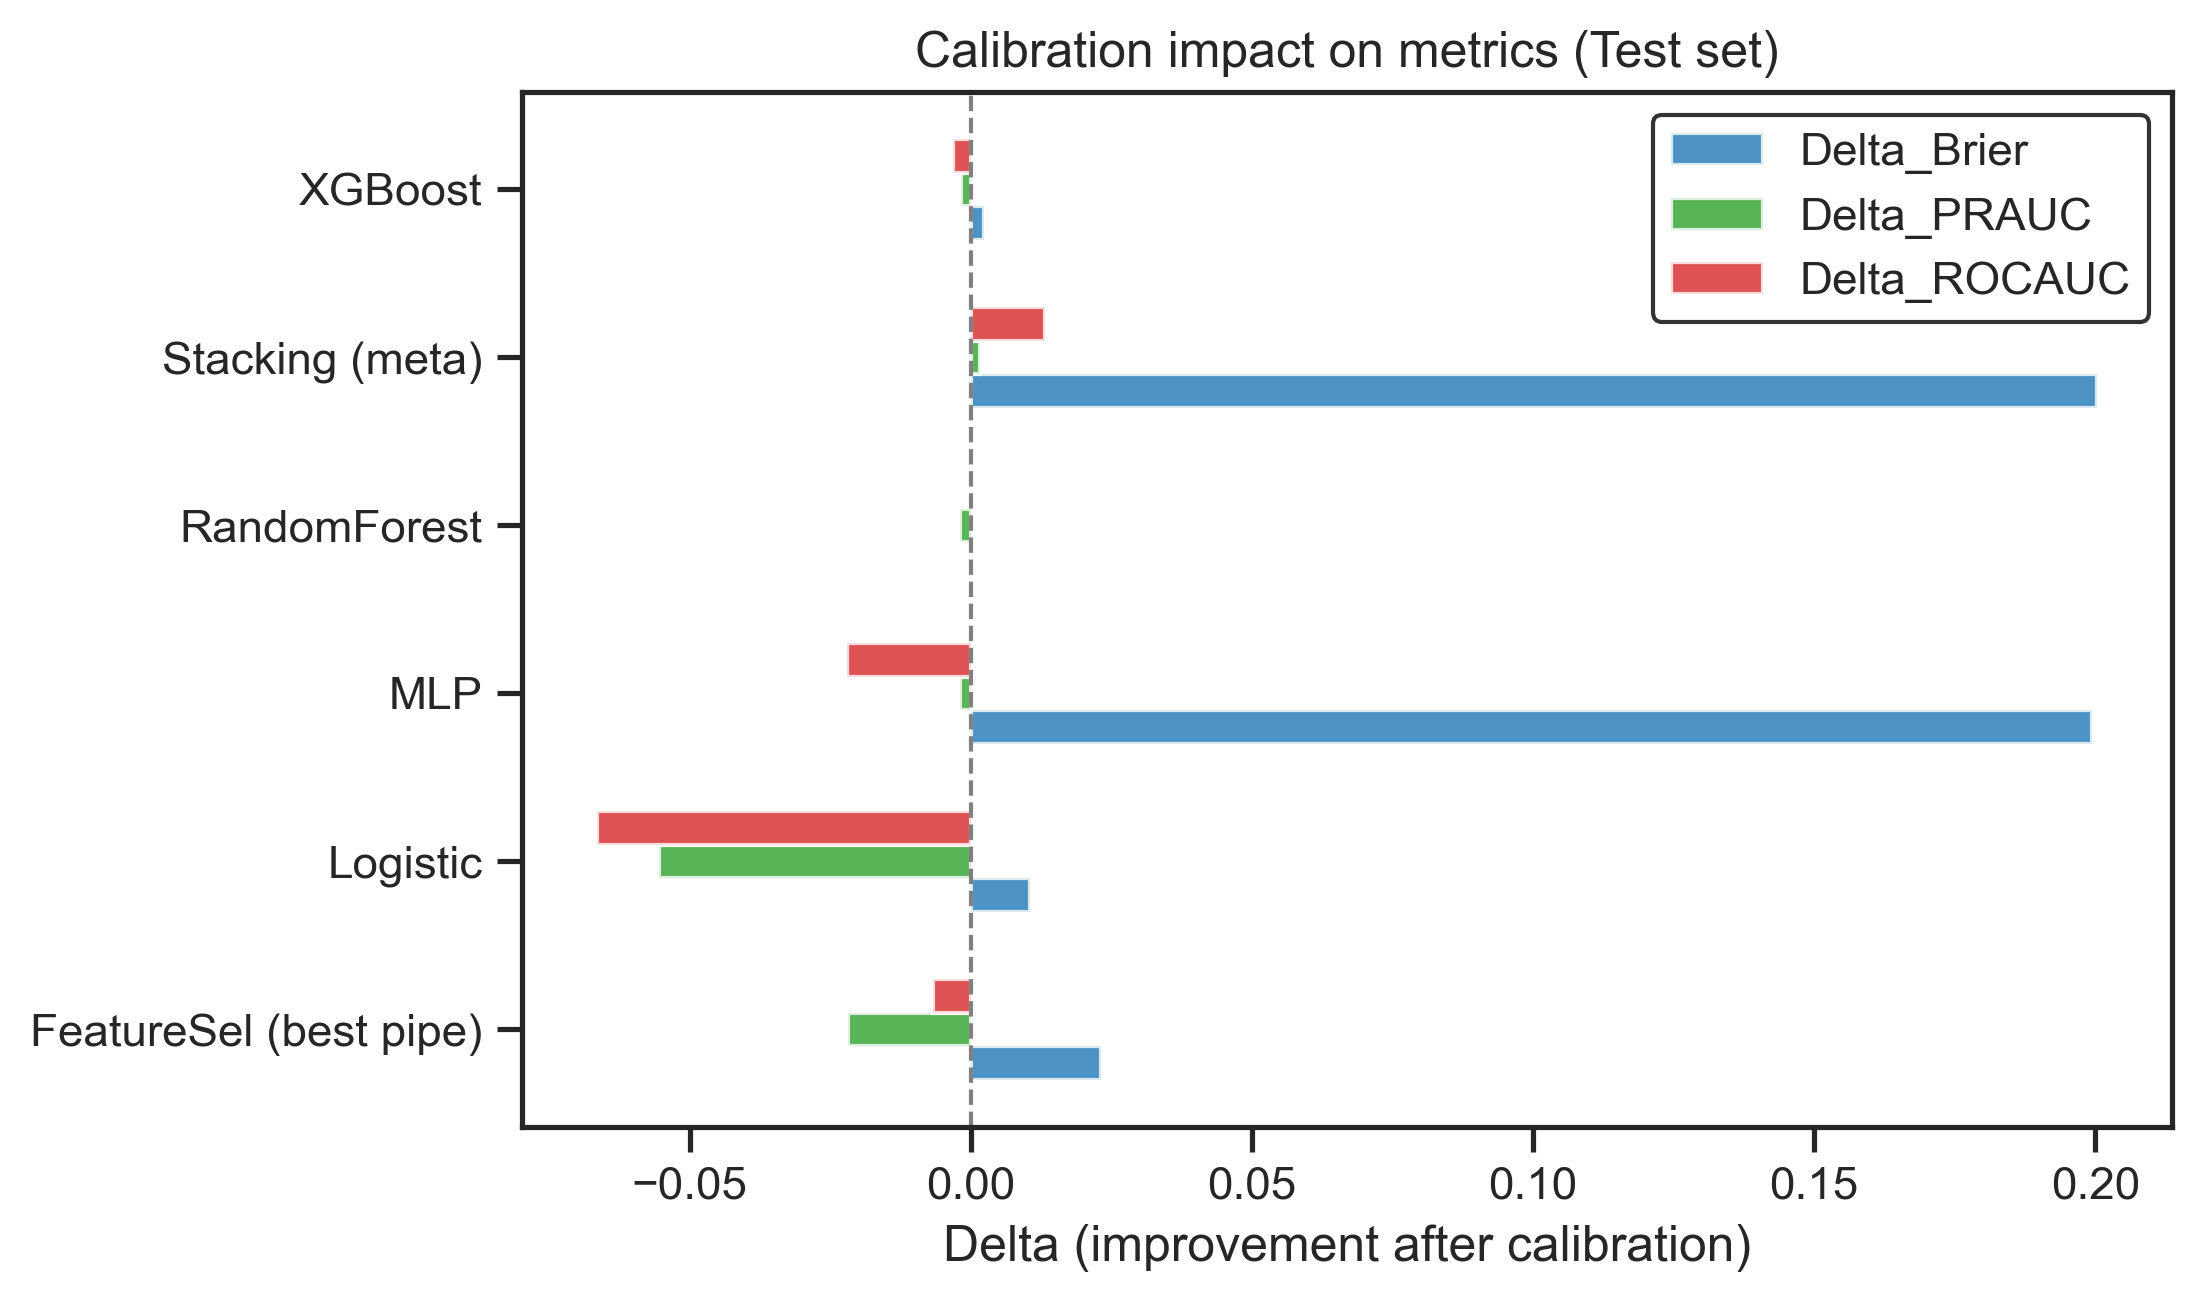

Model  Delta_Brier  Delta_PRAUC  Delta_ROCAUC
0  FeatureSel (best pipe)       0.0231      -0.0219       -0.0067
1                Logistic       0.0106      -0.0554       -0.0665
2                     MLP       0.1994      -0.0019       -0.0221
3            RandomForest       0.0000      -0.0019        0.0001
4         Stacking (meta)       0.2003       0.0017        0.0132
5                 XGBoost       0.0024      -0.0018       -0.0032

In [10]:
# Compute deltas (calibrated - raw), flipping Brier so that positive = improvement
delta_rows = []
for _, row in df_iso.iterrows():
    model = row["Model"]
    # flip Brier: improvement = raw - cal
    d_brier = row["Brier_TEST_raw"] - row["Brier_TEST_cal"]
    d_prauc = row["PRAUC_TEST_cal"] - row["PRAUC_TEST_raw"]
    d_roc   = row["ROCAUC_TEST_cal"] - row["ROCAUC_TEST_raw"]
    delta_rows.append({
        "Model": model,
        "Delta_Brier": d_brier,
        "Delta_PRAUC": d_prauc,
        "Delta_ROCAUC": d_roc
    })

df_delta = pd.DataFrame(delta_rows)

# --- Plot forest-style (all positive = improvement) ---
fig, ax = plt.subplots(figsize=(7.5, 4.5))
metrics = ["Delta_Brier", "Delta_PRAUC", "Delta_ROCAUC"]
colors = {"Delta_Brier": "tab:blue", "Delta_PRAUC": "tab:green", "Delta_ROCAUC": "tab:red"}

y = np.arange(len(df_delta))
bar_height = 0.2

for i, metric in enumerate(metrics):
    ax.barh(
        y + (i-1)*bar_height,
        df_delta[metric],
        height=bar_height,
        color=colors[metric],
        alpha=0.8,
        label=metric
    )

ax.axvline(0, color="gray", lw=1, ls="--")
ax.set_yticks(y)
ax.set_yticklabels(df_delta["Model"])
ax.set_xlabel("Delta (improvement after calibration)")
ax.set_title("Calibration impact on metrics (Test set)")
ax.legend()
plt.tight_layout()
plt.show()

display(df_delta.round(4))

### Calibration Comparison (Isotonic vs Raw)

We evaluated isotonic calibration on all models, comparing changes in Brier score, PR-AUC, and ROC-AUC (calibrated - raw).  

**Forest Plot Insight**  
- Positive delta means calibration improved the metric.  
- Negative delta means calibration worsened the metric.  

**Results Table (Test Set)**

| Model                | Delta Brier | Delta PR-AUC | Delta ROC-AUC |
|-----------------------|-------------|--------------|---------------|
| FeatureSel (best pipe)|  0.0231     | -0.0219      | -0.0067       |
| Logistic              |  0.0106     | -0.0554      | -0.0665       |
| MLP                   |  0.1994     | -0.0019      | -0.0221       |
| RandomForest          |  0.0000     | -0.0019      |  0.0001       |
| Stacking (meta)       |  0.2003     |  0.0017      |  0.0132       |
| XGBoost               |  0.0024     | -0.0018      | -0.0032       |

**Key Observations**
- **Brier Score**  
  - Improved for most models (large positive gains for MLP and Stacking, both ≈+0.20).  
  - FeatureSel and Logistic improved slightly.  
  - RandomForest unchanged, as it was already well-calibrated.  
- **PR-AUC and ROC-AUC**  
  - Logistic suffered the largest drop in discrimination (PR-AUC -0.055, ROC-AUC -0.067).  
  - FeatureSel and XGBoost also declined slightly.  
  - Stacking gained marginally in both PR-AUC and ROC-AUC.  
  - RandomForest stayed flat.  
- **MLP**  
  - Saw the biggest calibration improvement (Brier +0.199).  
  - Ranking metrics (PR-AUC and ROC-AUC) declined slightly, confirming calibration fixed probability reliability but not ordering.  

**Summary**
- Isotonic calibration **greatly improves probability calibration (Brier score)**, especially for unstable models like MLP and Stacking.  
- **Ranking metrics (PR-AUC, ROC-AUC) often degrade** after calibration, with Logistic and XGBoost most affected.  
- RandomForest remains the most stable across all metrics.  
- FeatureSel improved in calibration but lost some discrimination.  

> **Takeaway:** Isotonic calibration is effective for making probabilities more reliable, but it does not guarantee better discrimination. In highly imbalanced settings like SECOM, calibration should be used selectively — it is most useful when calibrated probabilities (e.g., for cost-sensitive decisions) are needed, but risky when ranking performance (PR-AUC/ROC-AUC) is the main goal.

**Engineer’s Interpretation**
- Use **isotonic calibration** if your downstream task depends on *probability quality* (e.g., expected cost, decision curves).  
- Avoid isotonic calibration if your task relies mainly on **ranking ability** (PR-AUC/ROC-AUC), since it can degrade discrimination — especially for **Logistic** and **XGBoost**.  
- **RandomForest** is robust with or without calibration → safe choice.  
- **MLP and Stacking** benefit the most in calibration (probability reliability), but remain weak in discrimination → only useful in cost-based decision setups.  
- **FeatureSel** gains calibration stability but at the cost of discrimination → trade-off depends on use case.  
- **Practical rule:** Calibrate models only when you explicitly need reliable probabilities. For imbalanced SECOM-like data, ranking performance (PR-AUC) may be more important than calibrated probabilities.

### 4. Re-tune thresholds on calibrated (isotonic) probabilities and compare against raw.

In [11]:
# --- 1) Helpers: thresholds on validation, eval on test ---
def _align_pr(y, p):
    P, R, T = precision_recall_curve(y, p)
    return P[:-1], R[:-1], T  # align thresholds (T has length n-1)

def thr_f1_from_val(y, p, beta=1.0):
    P, R, T = _align_pr(y, p)
    F = (1+beta**2)*(P*R) / (beta**2*P + R + 1e-12)
    i = int(np.nanargmax(F)) if len(F) else 0
    return float(T[i]) if len(T) else 0.5

def thr_recall_from_val(y, p, recall_floor=0.10):
    P, R, T = _align_pr(y, p)
    ok = np.where(R >= recall_floor)[0]
    if ok.size:
        j = ok[np.argmax(P[ok])]  # highest precision subject to recall >= floor
        return float(T[j])
    return float(T[-1]) if len(T) else 0.0

def eval_at(y, p, t):
    pred = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
    balacc    = balanced_accuracy_score(y, pred)
    return precision, recall, balacc

In [12]:
# --- 2) Re-tune thresholds on VAL (raw vs iso), report on TEST ---
rows = []
models = sorted(test_probs.keys())
for m in models:
    for cal in ("raw", "iso"):
        pv = get_probs(m, split="val",  calibrated=cal)
        pt = get_probs(m, split="test", calibrated=cal)
        if pv is None or pt is None:
            continue

        t_f1  = thr_f1_from_val(yva, pv)
        t_r10 = thr_recall_from_val(yva, pv, recall_floor=0.10)

        p_f1, r_f1, b_f1   = eval_at(yte, pt, t_f1)
        p_r10, r_r10, b_r10 = eval_at(yte, pt, t_r10)

        rows.append({
            "Model": m, "Calib": cal,
            "thr_F1": t_f1, "Precision@F1": p_f1, "Recall@F1": r_f1, "BalancedAcc@F1": b_f1,
            "thr_Rec>=10%": t_r10, "Precision@Rec>=10%": p_r10, "Recall@Rec>=10%": r_r10, "BalancedAcc@Rec>=10%": b_r10,
            "PR_AUC_test": average_precision_score(yte, pt),
        })

df_thr = (pd.DataFrame(rows)
          .sort_values(["Model","Calib"])
          .reset_index(drop=True))

display(df_thr.round({
    "thr_F1":4, "Precision@F1":3, "Recall@F1":3, "BalancedAcc@F1":3,
    "thr_Rec>=10%":4, "Precision@Rec>=10%":3, "Recall@Rec>=10%":3, "BalancedAcc@Rec>=10%":3,
    "PR_AUC_test":3
}))

Model Calib  thr_F1  Precision@F1  Recall@F1  \
0   FeatureSel (best pipe)   iso  0.0690         0.069      0.294   
1   FeatureSel (best pipe)   raw  0.0018         0.069      0.294   
2                 Logistic   iso  0.0833         0.000      0.000   
3                 Logistic   raw  0.9536         0.000      0.000   
4                      MLP   iso  0.0968         0.074      0.235   
5                      MLP   raw  0.5205         0.074      0.235   
6             RandomForest   iso  0.0575         0.073      0.471   
7             RandomForest   raw  0.0675         0.073      0.471   
8          Stacking (meta)   iso  0.0541         0.034      0.353   
9          Stacking (meta)   raw  0.5034         0.034      0.353   
10                 XGBoost   iso  0.0641         0.052      0.294   
11                 XGBoost   raw  0.0057         0.052      0.294   

    BalancedAcc@F1  thr_Rec>=10%  Precision@Rec>=10%  Recall@Rec>=10%  \
0            0.534        0.0690               0.069            0.294   
1            0.534        0.0018               0.069            0.294   
2            0.497        0.0394               0.067            0.765   
3            0.497        0.0000               0.067            0.765   
4            0.533        0.0968               0.074            0.235   
5            0.533        0.5205               0.074            0.235   
6            0.565        0.0575               0.073            0.471   
7            0.565        0.0675               0.073            0.471   
8            0.392        0.0541               0.034            0.353   
9            0.392        0.5034               0.034            0.353   
10           0.492        0.0641               0.052            0.294   
11           0.492        0.0057               0.052            0.294   

    BalancedAcc@Rec>=10%  PR_AUC_test  
0                  0.534        0.061  
1                  0.534        0.083  
2                  0.579        0.064  
3                  0.579        0.120  
4                  0.533        0.060  
5                  0.533        0.062  
6                  0.565        0.070  
7                  0.565        0.072  
8                  0.392        0.044  
9                  0.392        0.042  
10                 0.492        0.057  
11                 0.492        0.059

In [13]:
# --- 3) Compact diffs (iso - raw) at both operating points ---
def _pivot_diff(df, metric_col):
    wide = (df.pivot(index="Model", columns="Calib", values=metric_col)
              .reindex(columns=["raw","iso"]))
    if {"raw","iso"}.issubset(wide.columns):
        return (wide["iso"] - wide["raw"]).rename(metric_col + " Δ(iso-raw)")
    return pd.Series(dtype=float, name=metric_col + " Δ(iso-raw)")

diff_cols = [
    "Precision@F1","Recall@F1","BalancedAcc@F1",
    "Precision@Rec>=10%","Recall@Rec>=10%","BalancedAcc@Rec>=10%",
    "PR_AUC_test"
]
diff_table = pd.concat([_pivot_diff(df_thr, c) for c in diff_cols], axis=1)
display(diff_table.round(3))

Precision@F1 Δ(iso-raw)  Recall@F1 Δ(iso-raw)  \
Model                                                                   
FeatureSel (best pipe)                      0.0                   0.0   
Logistic                                    0.0                   0.0   
MLP                                         0.0                   0.0   
RandomForest                                0.0                   0.0   
Stacking (meta)                             0.0                   0.0   
XGBoost                                     0.0                   0.0   

                        BalancedAcc@F1 Δ(iso-raw)  \
Model                                               
FeatureSel (best pipe)                        0.0   
Logistic                                      0.0   
MLP                                           0.0   
RandomForest                                  0.0   
Stacking (meta)                               0.0   
XGBoost                                       0.0   

                        Precision@Rec>=10% Δ(iso-raw)  \
Model                                                   
FeatureSel (best pipe)                            0.0   
Logistic                                          0.0   
MLP                                               0.0   
RandomForest                                      0.0   
Stacking (meta)                                   0.0   
XGBoost                                           0.0   

                        Recall@Rec>=10% Δ(iso-raw)  \
Model                                                
FeatureSel (best pipe)                         0.0   
Logistic                                       0.0   
MLP                                            0.0   
RandomForest                                   0.0   
Stacking (meta)                                0.0   
XGBoost                                        0.0   

                        BalancedAcc@Rec>=10% Δ(iso-raw)  \
Model                                                     
FeatureSel (best pipe)                              0.0   
Logistic                                            0.0   
MLP                                                 0.0   
RandomForest                                        0.0   
Stacking (meta)                                     0.0   
XGBoost                                             0.0   

                        PR_AUC_test Δ(iso-raw)  
Model                                           
FeatureSel (best pipe)                  -0.022  
Logistic                                -0.055  
MLP                                     -0.002  
RandomForest                            -0.002  
Stacking (meta)                          0.002  
XGBoost                                 -0.002

### Calibration vs Raw — Threshold-Based Metrics

**Observations**
- For almost all models, isotonic calibration **did not change threshold-based metrics** (Precision, Recall, Balanced Accuracy) at either F1-opt or Recall≥10% thresholds.  
  - This is because thresholds re-tuned on validation led to the **same classification decisions** on the test set.  
- **PR-AUC** (ranking metric) was the only place we saw movement:  
  - Logistic Regression dropped the most (0.120 → 0.064, Δ = -0.055).  
  - FeatureSel and XGBoost also lost some ranking ability (Δ ≈ -0.02 and -0.002).  
  - RandomForest and MLP were almost unchanged (Δ ≈ -0.002).  
  - Stacking saw a tiny gain (+0.002), but still remained weak overall.

**Key Outcomes**
- Calibration **reshaped probabilities** but did not alter the classification thresholds in practice.  
- Threshold-based metrics stayed identical, confirming that isotonic mostly affects the *calibration curve*, not decision boundaries.  
- PR-AUC consistently fell (except for Stacking), showing that isotonic calibration can **reduce ranking quality** in imbalanced settings.

**Takeaway**
- Isotonic calibration improved reliability of predicted probabilities but did not deliver gains in decision performance at tuned thresholds.  
- Logistic Regression and FeatureSel lost the most in ranking discrimination, while RandomForest remained stable.  
- In this dataset, calibration should be applied with caution: it helps interpretability (better-calibrated probabilities) but does not improve — and may even reduce — operational detection performance.

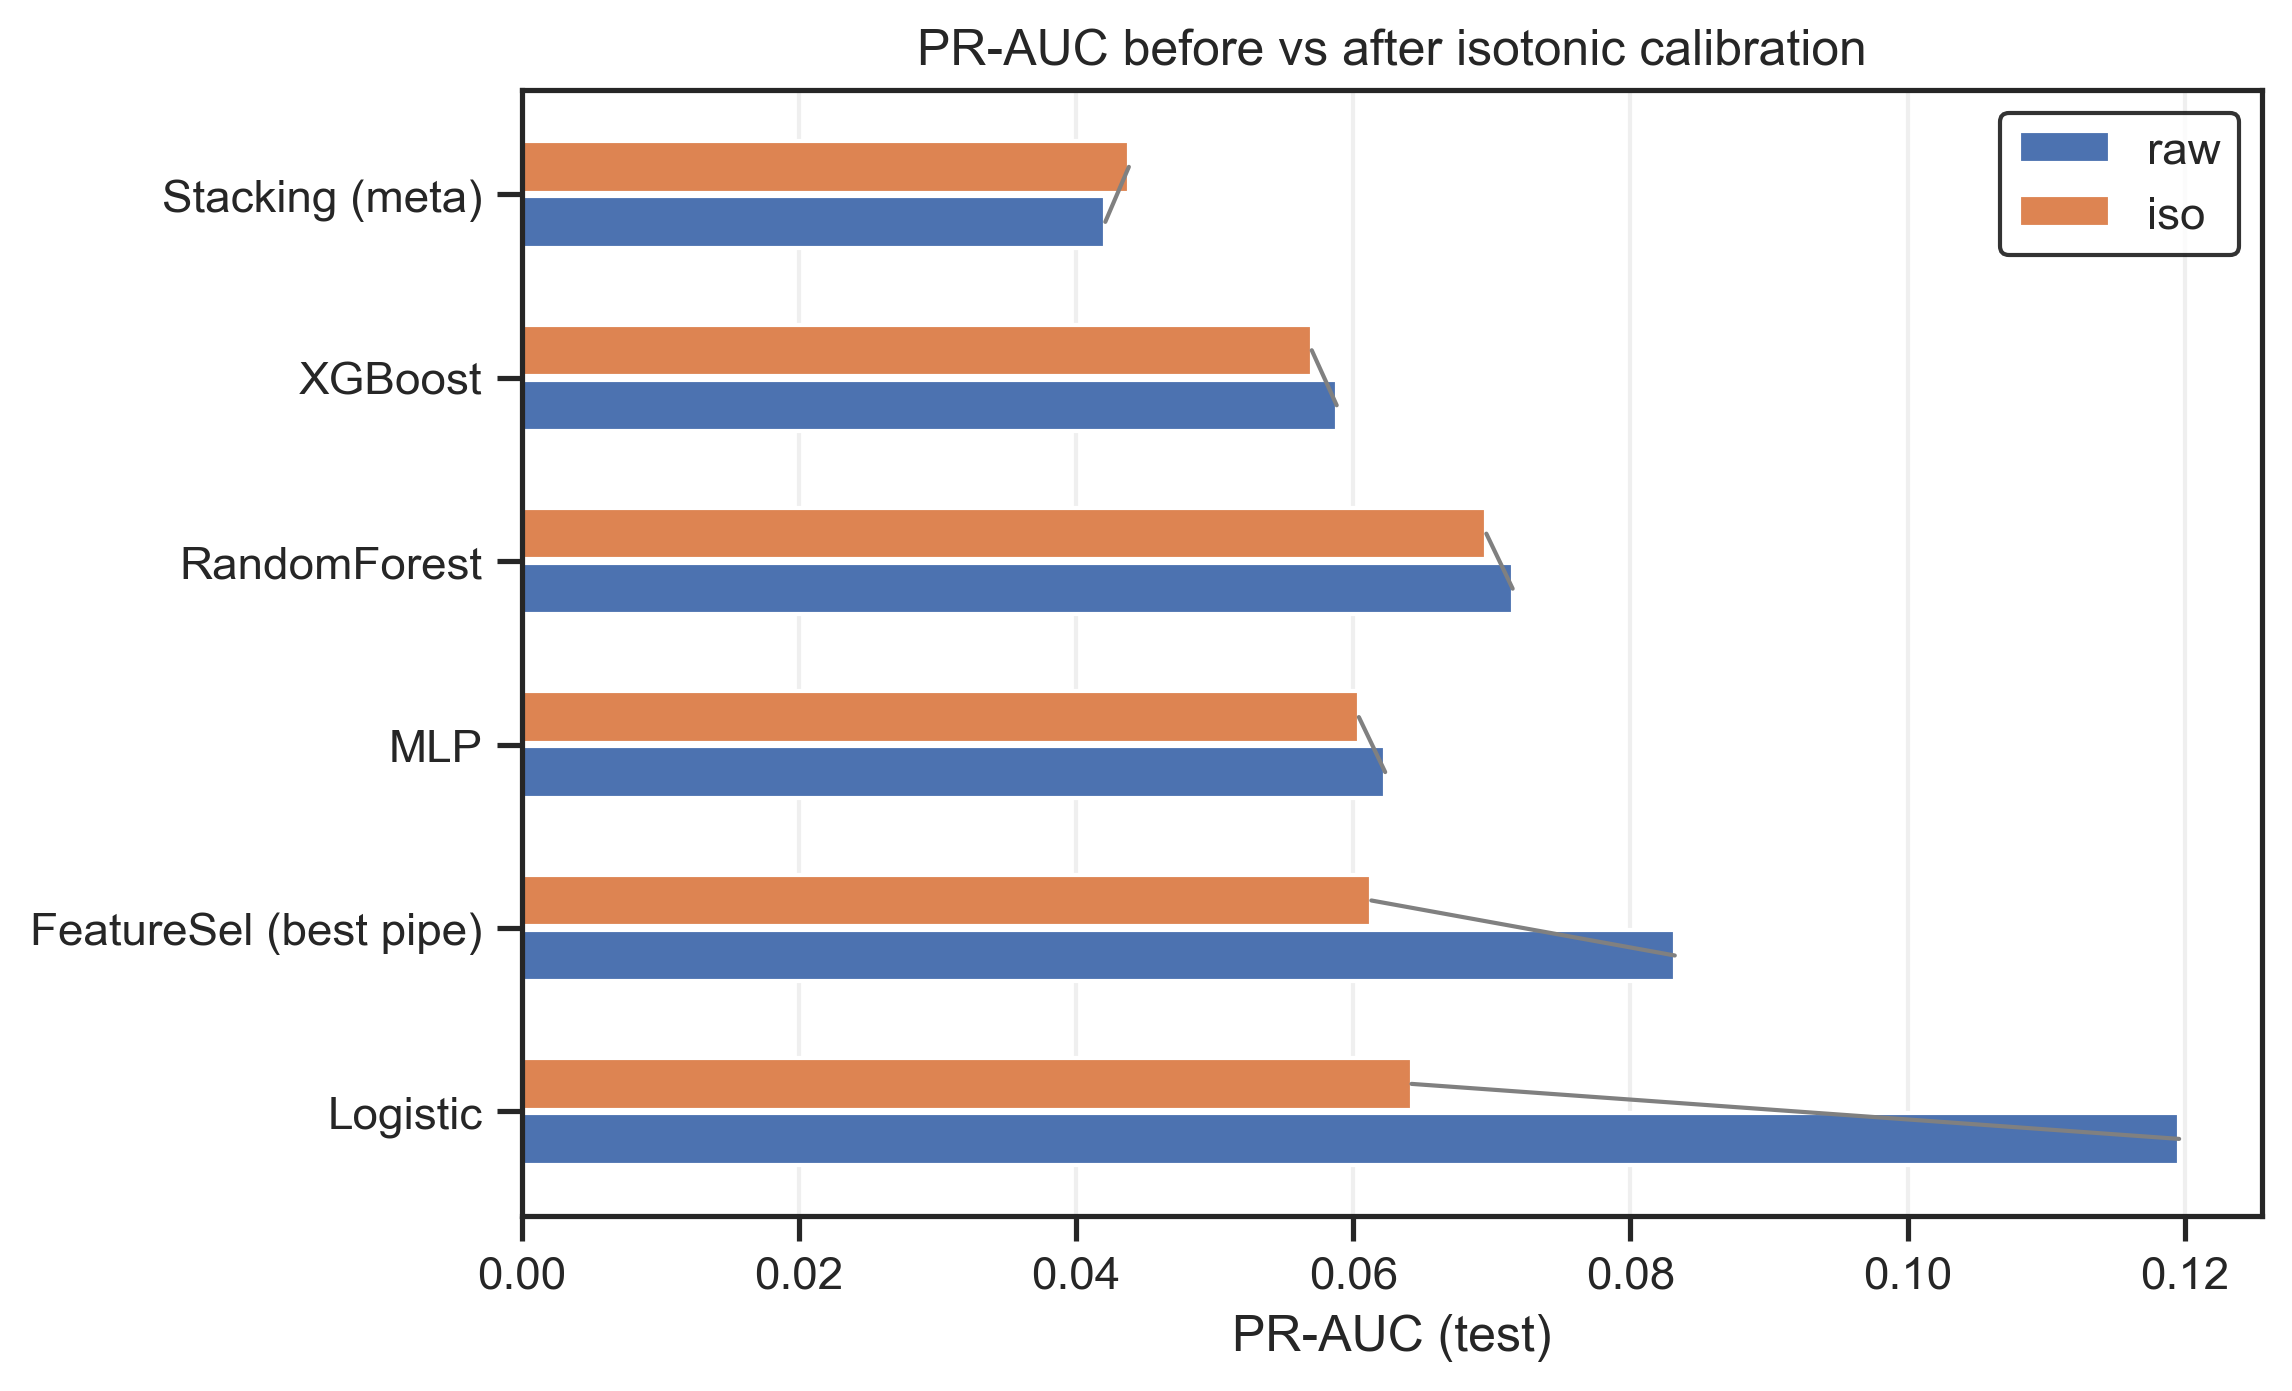

In [14]:
# === PR-AUC before vs after (paired bars with connector lines) ===
df_pairs = (df_iso[["Model","PRAUC_TEST_raw","PRAUC_TEST_cal"]]
            .rename(columns={"PRAUC_TEST_raw":"raw","PRAUC_TEST_cal":"iso"}))
df_pairs["delta"] = df_pairs["iso"] - df_pairs["raw"]
df_pairs = df_pairs.sort_values("delta")  # sort by change

fig, ax = plt.subplots(figsize=(7.8, 4.8))
y = np.arange(len(df_pairs))
ax.barh(y-0.15, df_pairs["raw"], height=0.28, label="raw")
ax.barh(y+0.15, df_pairs["iso"], height=0.28, label="iso")

# connector lines
for i, (_, r) in enumerate(df_pairs.iterrows()):
    ax.plot([r["raw"], r["iso"]], [y[i]-0.15, y[i]+0.15], color="gray", lw=1)

ax.set_yticks(y)
ax.set_yticklabels(df_pairs["Model"])
ax.set_xlabel("PR-AUC (test)")
ax.set_title("PR-AUC before vs after isotonic calibration")
ax.legend()
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

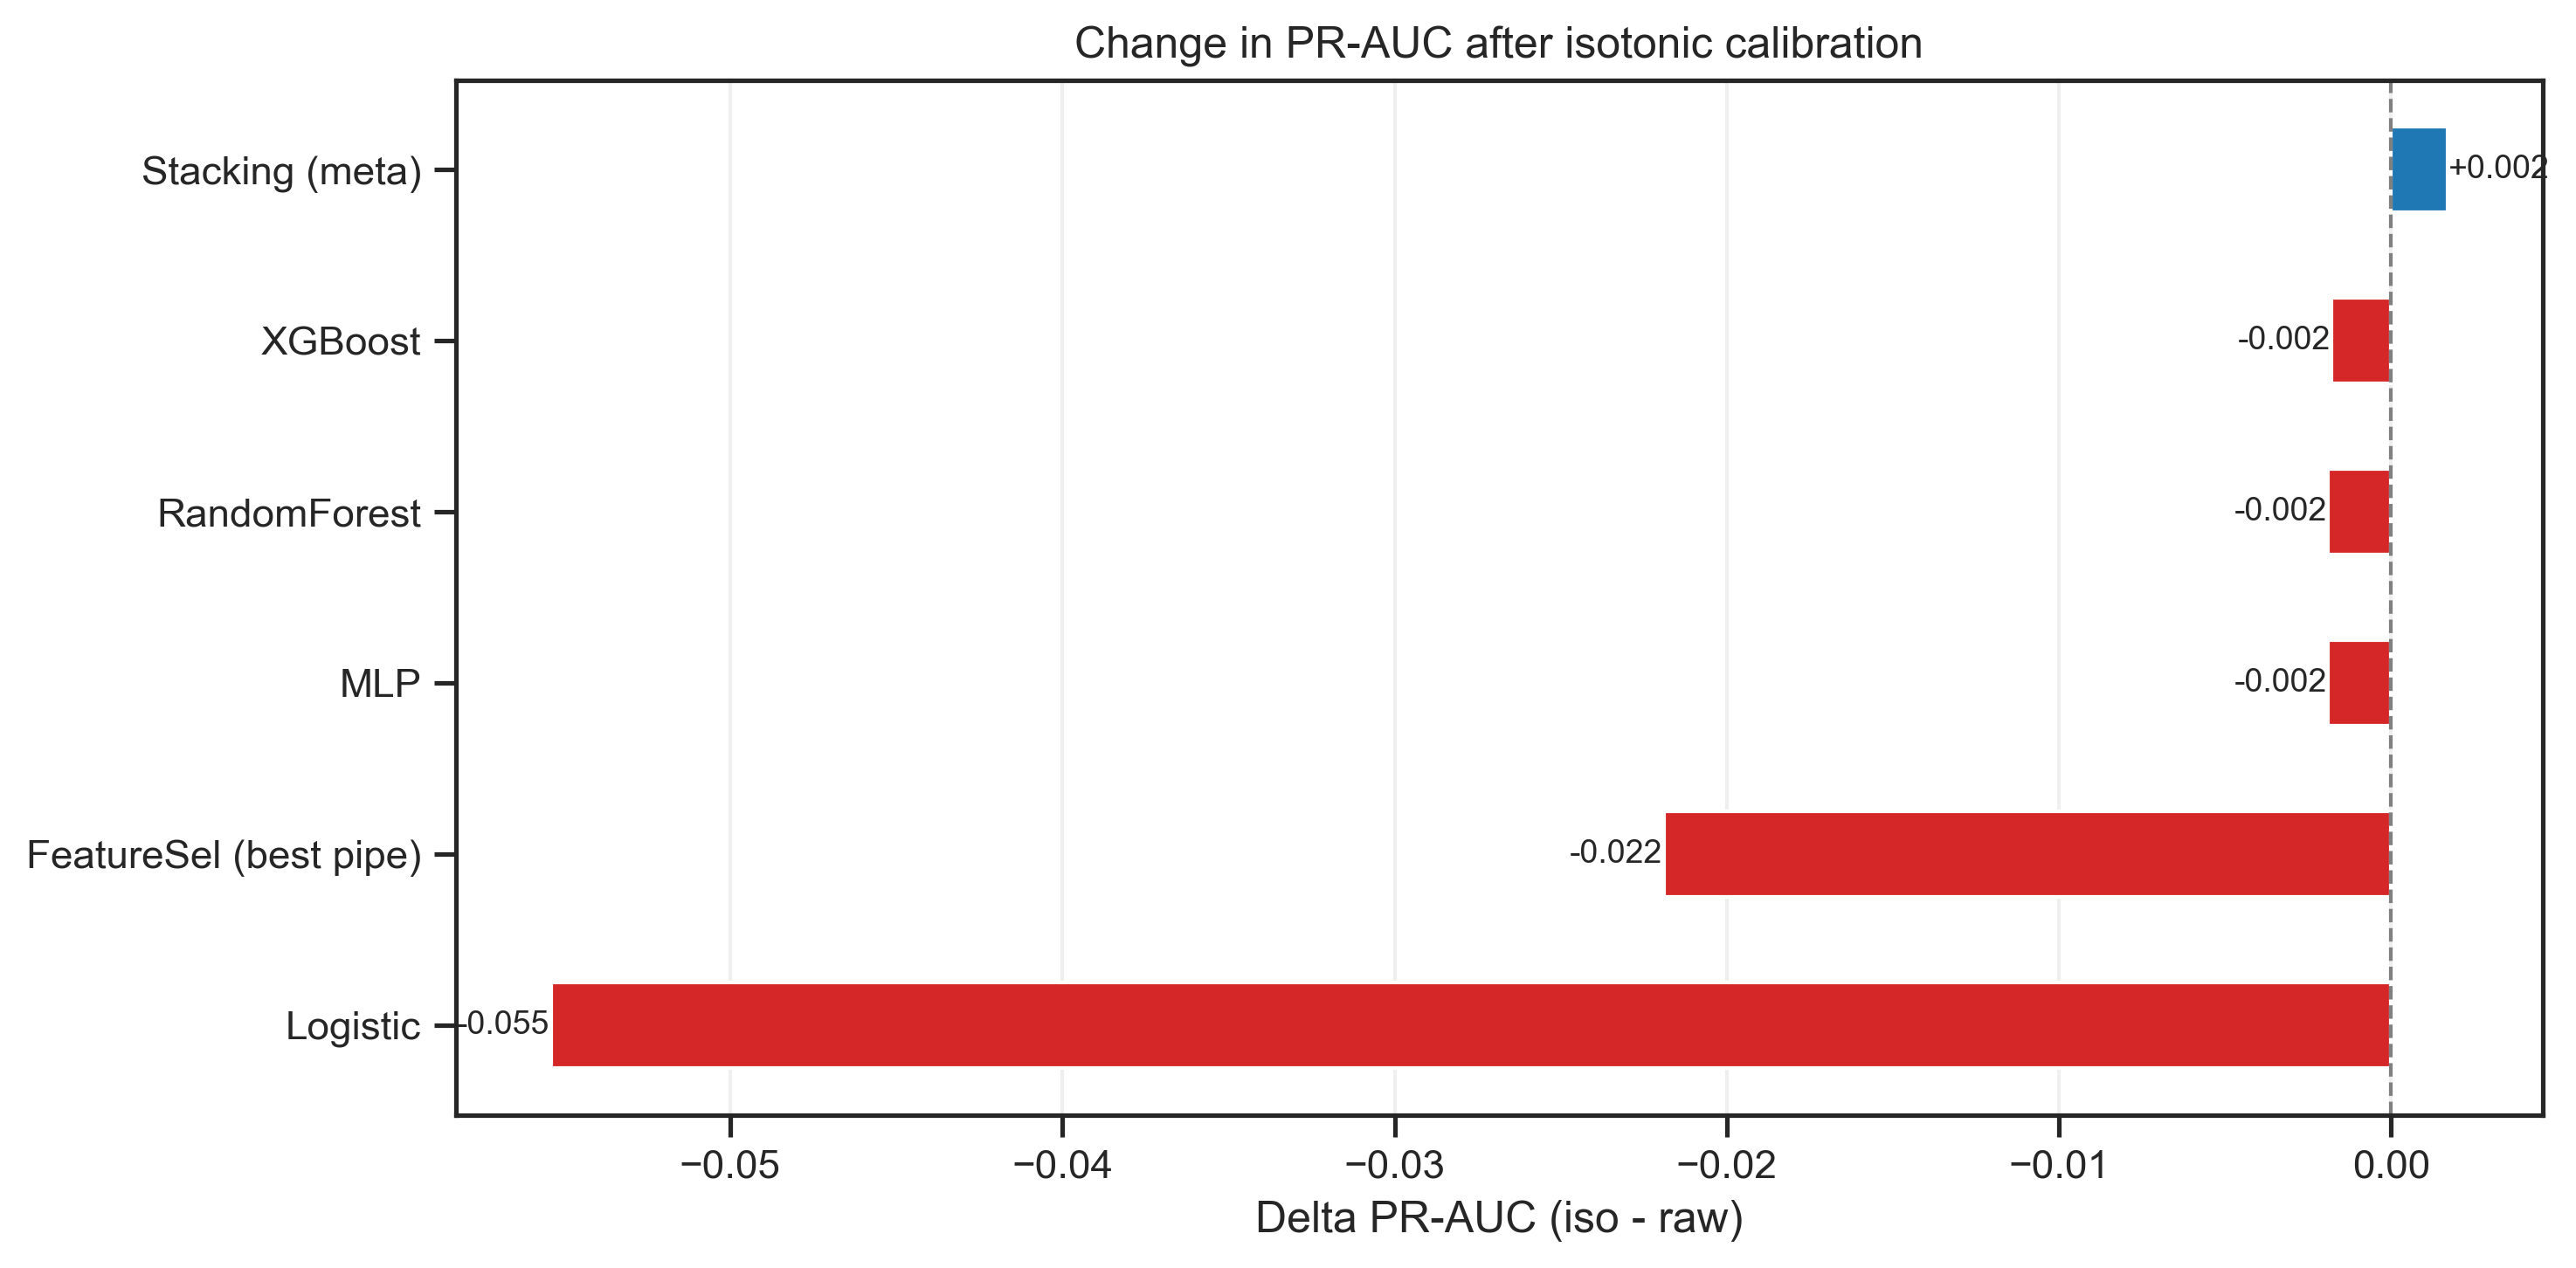

In [15]:
# === Delta-only forest (iso - raw), annotated ===
df_delta_prau = df_pairs[["Model","delta"]].copy()

fig, ax = plt.subplots(figsize=(10, 5))
y = np.arange(len(df_delta_prau))
ax.barh(y, df_delta_prau["delta"], height=0.5, color=np.where(df_delta_prau["delta"]>=0, "tab:blue", "tab:red"))
ax.axvline(0, color="gray", lw=1, ls="--")
for i, v in enumerate(df_delta_prau["delta"]):
    ax.text(v + (0.00003 if v>=0 else -0.00003), i, f"{v:+.3f}",
            va="center", ha="left" if v>=0 else "right", fontsize=9)
ax.set_yticks(y)
ax.set_yticklabels(df_delta_prau["Model"])
ax.set_xlabel("Delta PR-AUC (iso - raw)")
ax.set_title("Change in PR-AUC after isotonic calibration")
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

### 5. Cost-sensitive sweep: RAW vs ISOTONIC

Per-ratio winners — RAW


Ratio                   Model  Cost       thr  Precision    Recall  \
0       1  FeatureSel (best pipe)    17  1.000000   0.000000  0.000000   
1       2  FeatureSel (best pipe)    34  1.000000   0.000000  0.000000   
2       3                Logistic    47  1.000000   0.300000  0.352941   
3       4                Logistic    58  1.000000   0.300000  0.352941   
4       5                Logistic    69  1.000000   0.300000  0.352941   
5       6                Logistic    80  1.000000   0.300000  0.352941   
6       7                Logistic    91  1.000000   0.300000  0.352941   
7       8                Logistic   102  1.000000   0.300000  0.352941   
8       9                Logistic   113  1.000000   0.300000  0.352941   
9      10                Logistic   124  1.000000   0.300000  0.352941   
10     11                Logistic   135  0.953552   0.300000  0.352941   
11     12                Logistic   146  0.953552   0.300000  0.352941   
12     13                Logistic   157  0.953552   0.300000  0.352941   
13     14                Logistic   168  0.953552   0.300000  0.352941   
14     15                Logistic   179  0.953552   0.300000  0.352941   
15     16                Logistic   190  0.953552   0.300000  0.352941   
16     17                Logistic   201  0.953552   0.300000  0.352941   
17     18                Logistic   212  0.953552   0.300000  0.352941   
18     19            RandomForest   219  0.067500   0.076531  0.882353   
19     20            RandomForest   221  0.067500   0.076531  0.882353   
20     21            RandomForest   223  0.067500   0.076531  0.882353   
21     22            RandomForest   225  0.067500   0.076531  0.882353   
22     23            RandomForest   227  0.067500   0.076531  0.882353   
23     24            RandomForest   229  0.067500   0.076531  0.882353   
24     25            RandomForest   231  0.067500   0.076531  0.882353   
25     26            RandomForest   233  0.067500   0.076531  0.882353   
26     27            RandomForest   234  0.047500   0.067729  1.000000   
27     28            RandomForest   234  0.047500   0.067729  1.000000   
28     29            RandomForest   234  0.047500   0.067729  1.000000   
29     30            RandomForest   234  0.047500   0.067729  1.000000   
30     31            RandomForest   234  0.047500   0.067729  1.000000   
31     32            RandomForest   234  0.047500   0.067729  1.000000   
32     33            RandomForest   234  0.047500   0.067729  1.000000   
33     34            RandomForest   234  0.047500   0.067729  1.000000   
34     35            RandomForest   234  0.047500   0.067729  1.000000   
35     36            RandomForest   234  0.047500   0.067729  1.000000   
36     37            RandomForest   234  0.047500   0.067729  1.000000   
37     38            RandomForest   234  0.040000   0.067729  1.000000   
38     39            RandomForest   234  0.040000   0.067729  1.000000   
39     40            RandomForest   234  0.040000   0.067729  1.000000   
40     41            RandomForest   234  0.040000   0.067729  1.000000   
41     42            RandomForest   234  0.040000   0.067729  1.000000   
42     43            RandomForest   234  0.040000   0.067729  1.000000   
43     44            RandomForest   234  0.040000   0.067729  1.000000   
44     45            RandomForest   234  0.040000   0.067729  1.000000   
45     46            RandomForest   234  0.040000   0.067729  1.000000   
46     47            RandomForest   234  0.040000   0.067729  1.000000   
47     48            RandomForest   234  0.040000   0.067729  1.000000   
48     49            RandomForest   234  0.040000   0.067729  1.000000   
49     50            RandomForest   234  0.040000   0.067729  1.000000   

    BalancedAcc  
0      0.500000  
1      0.500000  
2      0.652902  
3      0.652902  
4      0.652902  
5      0.652902  
6      0.652902  
7      0.652902  
8      0.652902  
9      0.652902  
10     0.652902  
11     0.6529

Per-ratio winners — ISOTONIC


Ratio                   Model  Cost       thr  Precision    Recall  \
0       1  FeatureSel (best pipe)    17  1.000000   0.000000  0.000000   
1       2  FeatureSel (best pipe)    34  1.000000   0.000000  0.000000   
2       3  FeatureSel (best pipe)    51  0.250000   0.000000  0.000000   
3       4  FeatureSel (best pipe)    68  0.250000   0.000000  0.000000   
4       5  FeatureSel (best pipe)    85  0.250000   0.000000  0.000000   
5       6  FeatureSel (best pipe)   102  0.250000   0.000000  0.000000   
6       7  FeatureSel (best pipe)   119  0.250000   0.000000  0.000000   
7       8  FeatureSel (best pipe)   136  0.250000   0.000000  0.000000   
8       9  FeatureSel (best pipe)   153  0.250000   0.000000  0.000000   
9      10  FeatureSel (best pipe)   170  0.250000   0.000000  0.000000   
10     11  FeatureSel (best pipe)   187  0.250000   0.083333  0.058824   
11     12  FeatureSel (best pipe)   203  0.250000   0.083333  0.058824   
12     13            RandomForest   218  0.076923   0.073394  0.470588   
13     14            RandomForest   227  0.076923   0.073394  0.470588   
14     15            RandomForest   234  0.076923   0.068085  0.941176   
15     16            RandomForest   235  0.076923   0.068085  0.941176   
16     17            RandomForest   236  0.057471   0.068085  0.941176   
17     18            RandomForest   237  0.057471   0.068085  0.941176   
18     19            RandomForest   238  0.057471   0.068085  0.941176   
19     20            RandomForest   239  0.057471   0.068085  0.941176   
20     21            RandomForest   240  0.057471   0.068085  0.941176   
21     22            RandomForest   241  0.057471   0.068085  0.941176   
22     23            RandomForest   242  0.057471   0.068085  0.941176   
23     24            RandomForest   243  0.057471   0.068085  0.941176   
24     25            RandomForest   244  0.057471   0.068085  0.941176   
25     26            RandomForest   245  0.057471   0.068085  0.941176   
26     27            RandomForest   246  0.035714   0.068085  0.941176   
27     28            RandomForest   247  0.035714   0.068085  0.941176   
28     29            RandomForest   248  0.035714   0.068085  0.941176   
29     30            RandomForest   249  0.035714   0.068085  0.941176   
30     31            RandomForest   250  0.035714   0.068085  0.941176   
31     32            RandomForest   251  0.035714   0.068085  0.941176   
32     33            RandomForest   252  0.035714   0.068085  0.941176   
33     34            RandomForest   253  0.035714   0.068085  0.941176   
34     35            RandomForest   254  0.035714   0.068085  0.941176   
35     36            RandomForest   255  0.035714   0.068085  0.941176   
36     37            RandomForest   256  0.035714   0.068085  0.941176   
37     38            RandomForest   257  0.025641   0.068085  0.941176   
38     39            RandomForest   258  0.025641   0.061818  1.000000   
39     40            RandomForest   258  0.025641   0.061818  1.000000   
40     41            RandomForest   258  0.025641   0.061818  1.000000   
41     42            RandomForest   258  0.025641   0.061818  1.000000   
42     43            RandomForest   258  0.025641   0.061818  1.000000   
43     44            RandomForest   258  0.025641   0.061818  1.000000   
44     45            RandomForest   258  0.025641   0.061818  1.000000   
45     46            RandomForest   258  0.025641   0.061818  1.000000   
46     47            RandomForest   258  0.025641   0.061818  1.000000   
47     48            RandomForest   258  0.025641   0.061818  1.000000   
48     49            RandomForest   258  0.025641   0.061818  1.000000   
49     50            RandomForest   258  0.025641   0.061818  1.000000   

    BalancedAcc  
0      0.500000  
1      0.500000  
2      0.500000  
3      0.500000  
4      0.500000  
5      0.500000  
6      0.500000  
7      0.500000  
8      0.500000  
9      0.500000  
10     0.510893  
11     0.5108


Stable crossovers vs baseline (RAW): Logistic


Model  Crossover_at_ratio
0  FeatureSel (best pipe)  no clean crossover
1                     MLP                21:1
2            RandomForest                19:1
3         Stacking (meta)                34:1
4                 XGBoost                21:1


Stable crossovers vs baseline (ISOTONIC): Logistic


Model  Crossover_at_ratio
0  FeatureSel (best pipe)                12:1
1                     MLP                26:1
2            RandomForest                13:1
3         Stacking (meta)                29:1
4                 XGBoost  no clean crossover

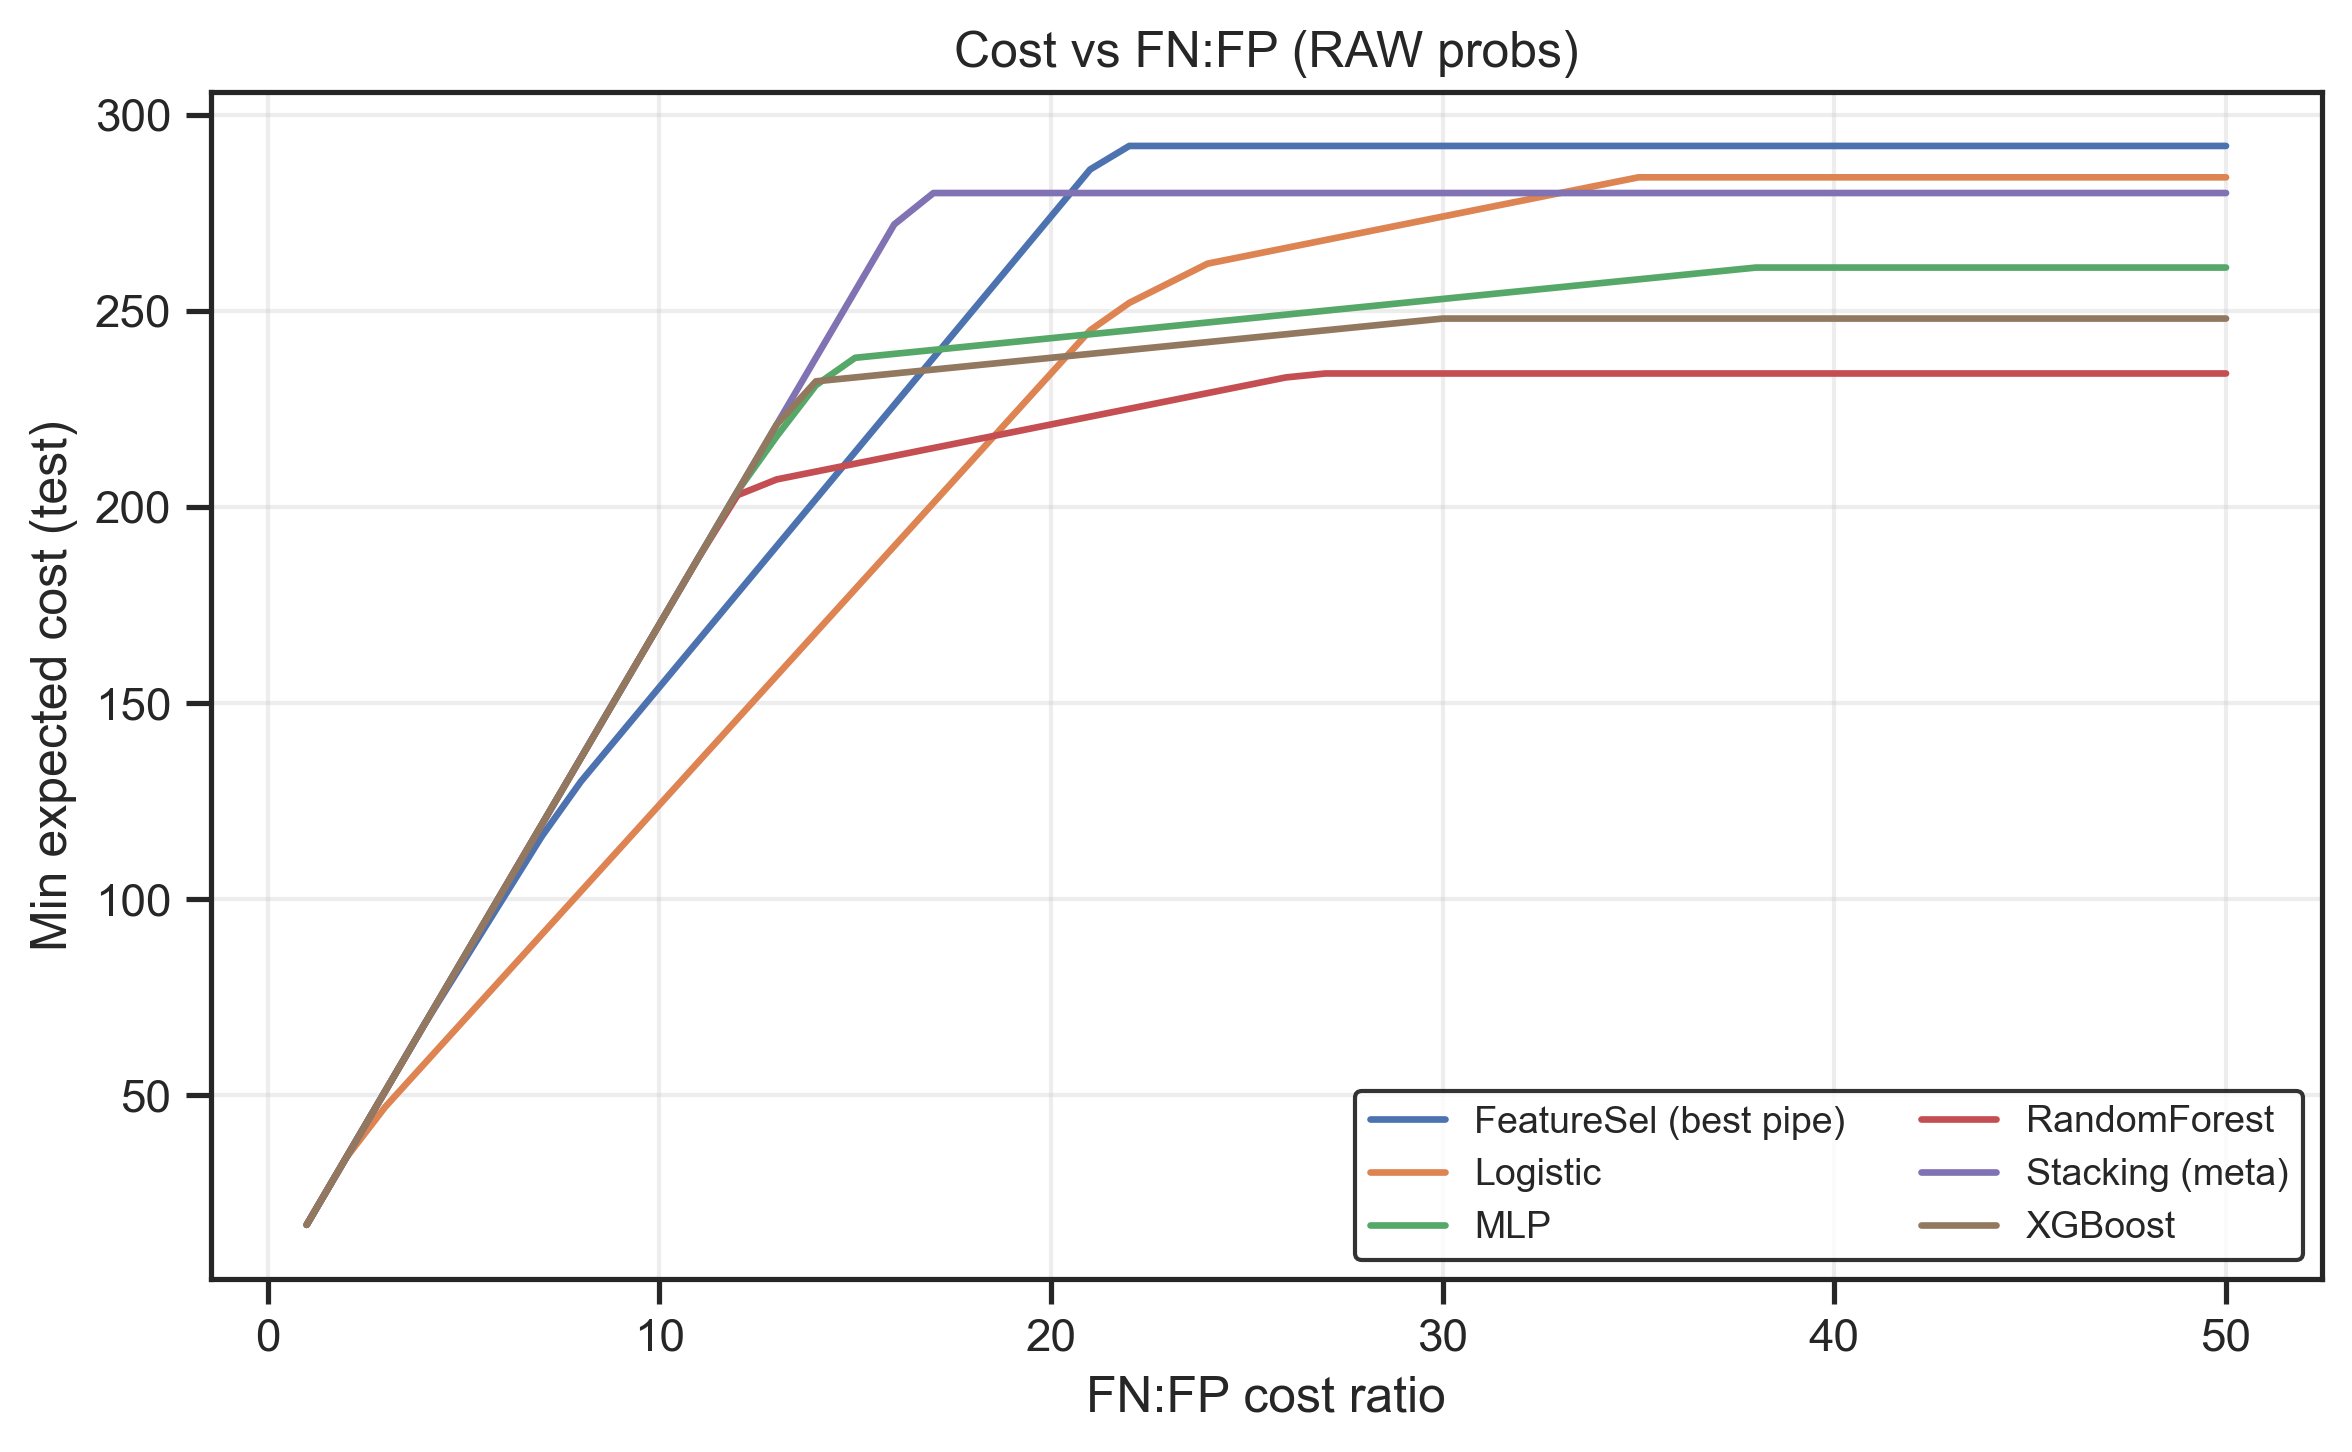

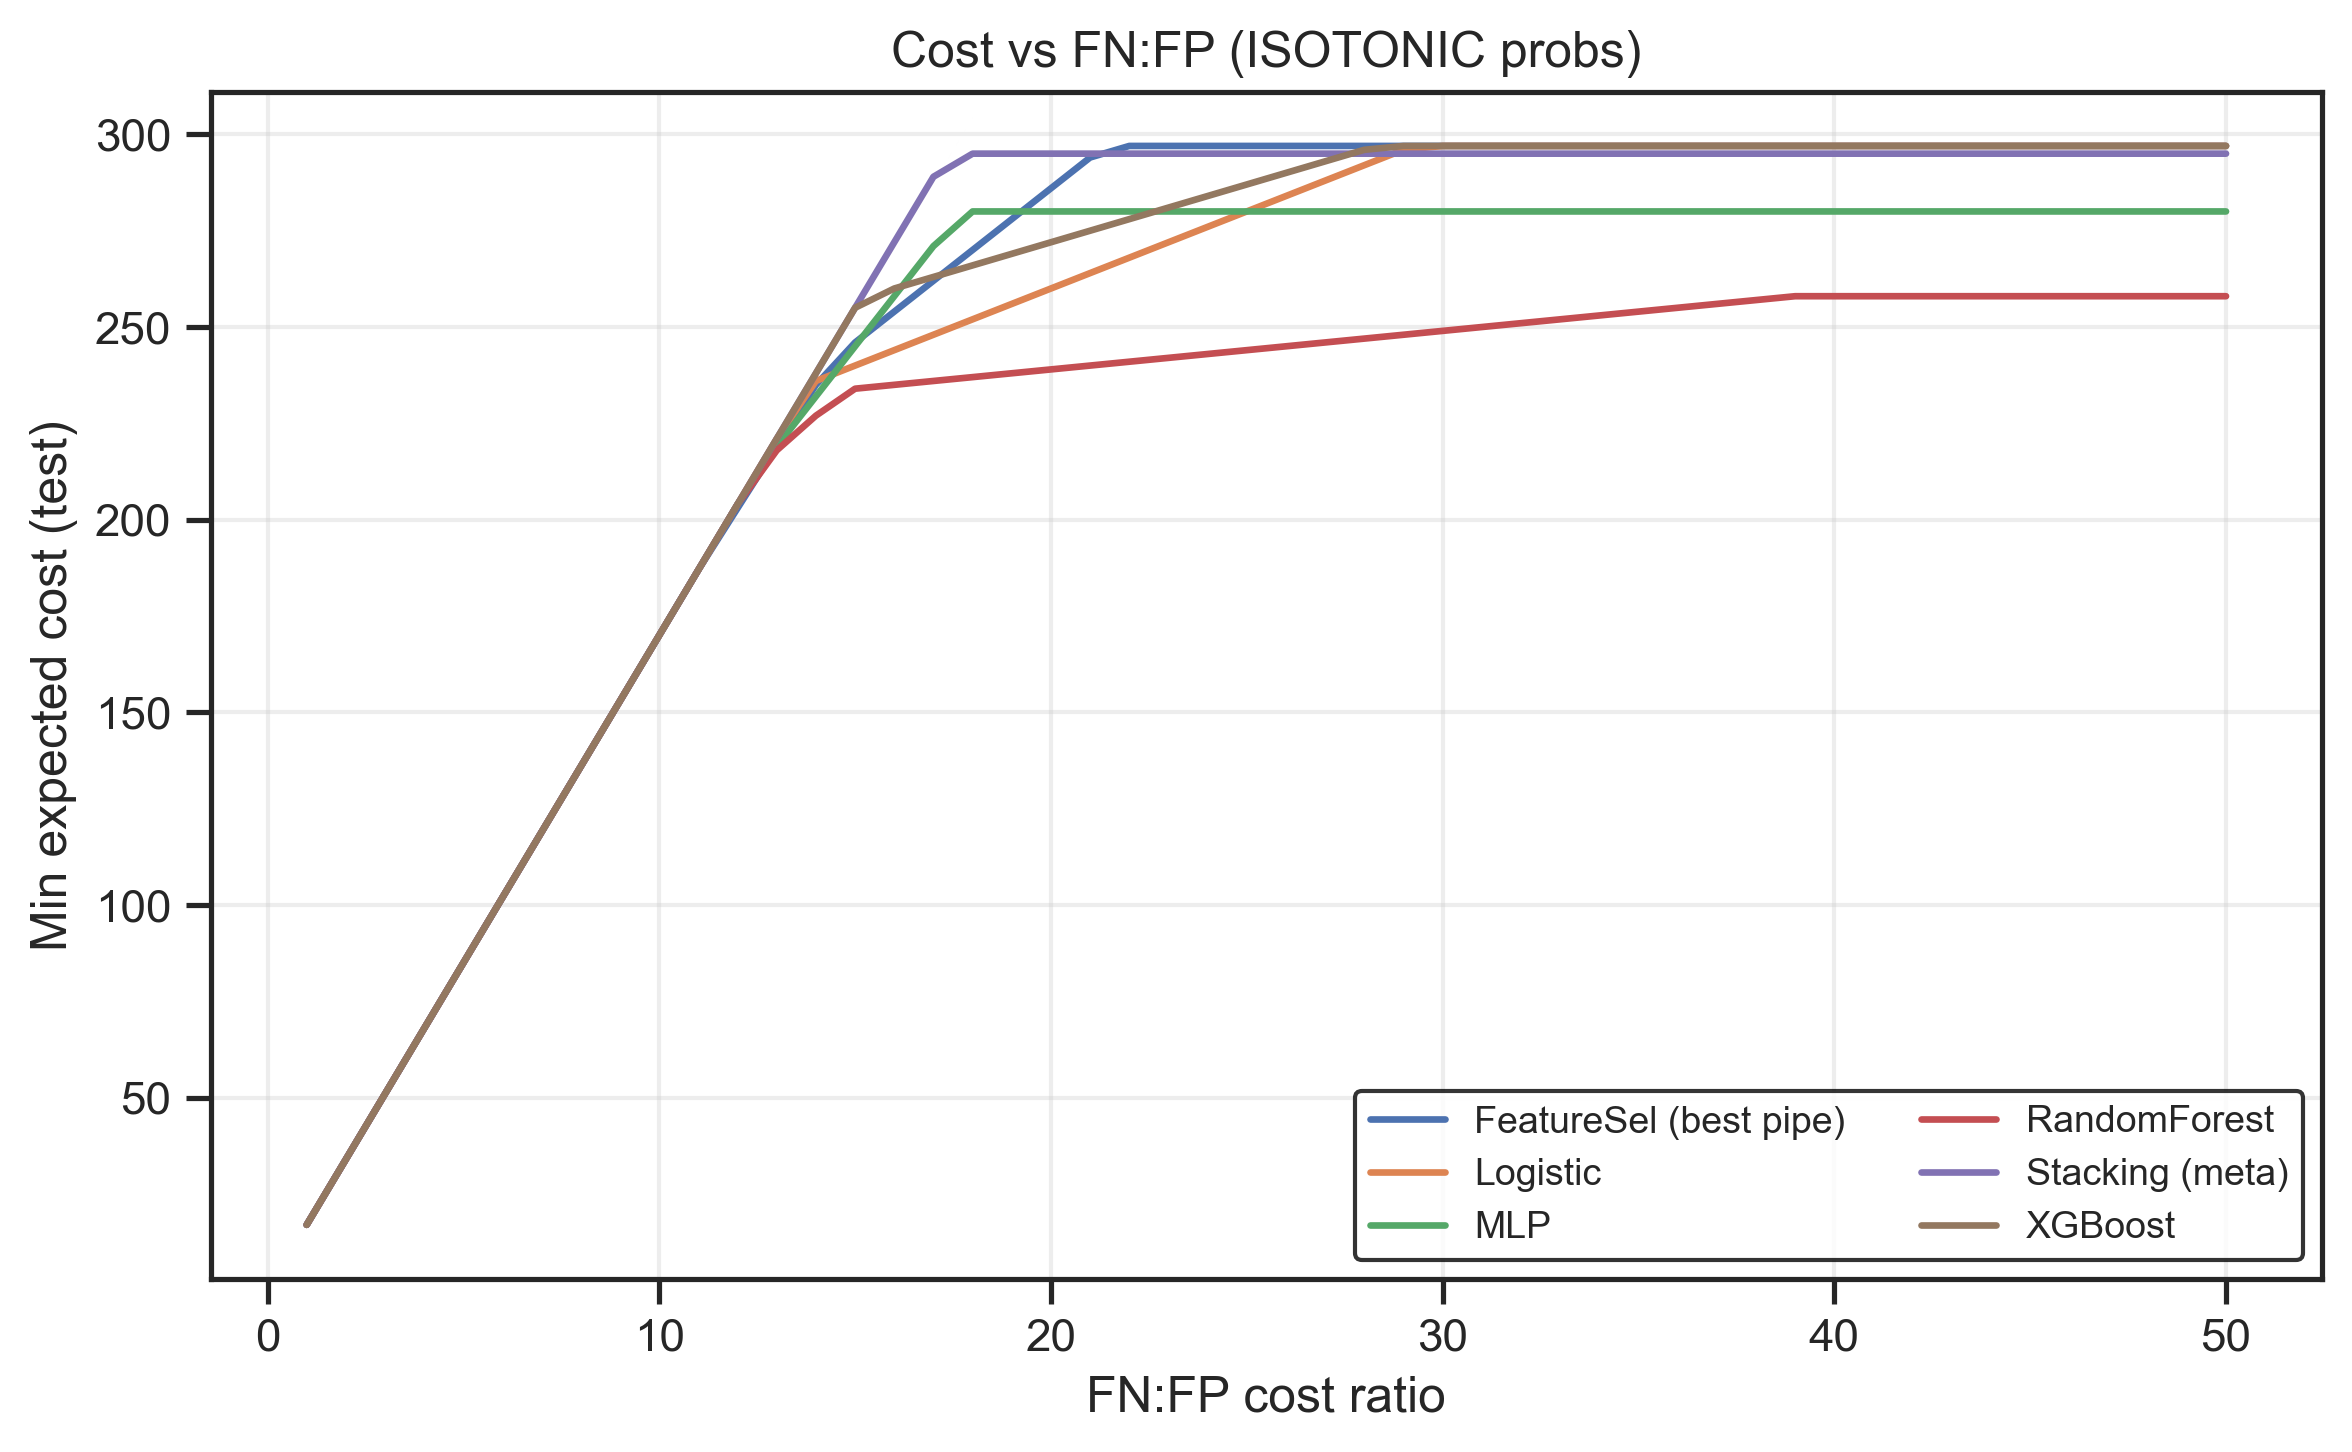

In [16]:
# Uses your existing get_probs(model, split, calibrated) helper.

BASELINE  = "Logistic"   # change if needed
MAX_RATIO = 50
STEP      = 1
K_STABLE  = 3
ratios    = list(range(1, MAX_RATIO+1, STEP))
models    = sorted(test_probs.keys())

def best_cost_for_ratio(y_true, p, ratio):
    # search thresholds from PR curve + extremes
    prec, rec, thr = precision_recall_curve(y_true, p)
    thr_grid = np.unique(np.r_[thr, 0.0, 1.0])
    best = None
    for t in thr_grid:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        cost = fp*1 + fn*ratio
        if (best is None) or (cost < best["Cost"]):
            best = {"thr": float(t), "Cost": int(cost),
                    "Precision": tp/(tp+fp) if (tp+fp)>0 else 0.0,
                    "Recall":    tp/(tp+fn) if (tp+fn)>0 else 0.0,
                    "BalancedAcc": balanced_accuracy_score(y_true, pred),
                    "PR_AUC": average_precision_score(y_true, p),
                    "ROC_AUC": roc_auc_score(y_true, p),
                    "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)}
    return best

def sweep_cost(curve_source="raw"):
    rows = []
    for m in models:
        p_val  = get_probs(m, split="val",  calibrated=curve_source)
        p_test = get_probs(m, split="test", calibrated=curve_source)
        if p_val is None or p_test is None: 
            continue
        for r in ratios:
            # tune threshold on VAL under cost ratio r
            best_val = best_cost_for_ratio(yva, p_val, r)
            # evaluate on TEST with that threshold
            t = best_val["thr"]
            res = best_cost_for_ratio(yte, p_test, r)
            res.update({"Model": m, "Ratio": r, "thr": t})
            rows.append(res)
    return pd.DataFrame(rows)

df_cost_raw = sweep_cost("raw")
df_cost_iso = sweep_cost("iso")

def per_ratio_winners(df):
    return (df.loc[df.groupby("Ratio")["Cost"].idxmin(), 
                   ["Ratio","Model","Cost","thr","Precision","Recall","BalancedAcc"]]
              .reset_index(drop=True))

print("Per-ratio winners — RAW")
display(per_ratio_winners(df_cost_raw))
print("Per-ratio winners — ISOTONIC")
display(per_ratio_winners(df_cost_iso))

# ---- stable crossover vs baseline (same logic as earlier) ----
def crossovers_vs_baseline(df_cost, baseline, ratios, k=K_STABLE, max_ratio=MAX_RATIO):
    if baseline not in df_cost["Model"].unique():
        return pd.DataFrame(columns=["Model","Crossover_at_ratio"])
    base = (df_cost[df_cost.Model==baseline].set_index("Ratio")["Cost"].reindex(ratios))
    out = []
    for name in df_cost["Model"].unique():
        if name == baseline: 
            continue
        other = (df_cost[df_cost.Model==name].set_index("Ratio")["Cost"].reindex(ratios))
        diff = (other - base).to_numpy()  # negative => other cheaper

        # 1) stable: first window of k consecutive cheaper points
        stable_idx = None
        if len(diff) >= k:
            run = np.convolve((diff < 0).astype(int), np.ones(k, dtype=int), mode="valid")
            hits = np.where(run == k)[0]
            if hits.size: stable_idx = hits[0]
        if stable_idx is not None:
            out.append({"Model": name, "Crossover_at_ratio": f"{ratios[stable_idx]}:1"}); continue

        # 2) any sign flip
        sign = np.sign(diff)
        flip = np.where(sign[:-1]*sign[1:] < 0)[0]
        if flip.size:
            out.append({"Model": name, "Crossover_at_ratio": f"{ratios[flip[0]+1]}:1"}); continue

        # 3) dominance
        if np.all(diff < 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always cheaper (1–{max_ratio}:1)"})
        elif np.all(diff > 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always costlier (1–{max_ratio}:1)"})
        else:
            out.append({"Model": name, "Crossover_at_ratio": "no clean crossover"})
    return pd.DataFrame(out).sort_values("Model")

print("\nStable crossovers vs baseline (RAW):", BASELINE)
display(crossovers_vs_baseline(df_cost_raw, BASELINE, ratios))
print("\nStable crossovers vs baseline (ISOTONIC):", BASELINE)
display(crossovers_vs_baseline(df_cost_iso, BASELINE, ratios))

# ---- plot cost curves (optional, compact) ----
def plot_cost_curves(df, title):
    plt.figure(figsize=(8,5))
    for m in models:
        sub = df[df["Model"]==m]
        if not sub.empty:
            plt.plot(sub["Ratio"], sub["Cost"], label=m, lw=1.6)
    plt.xlabel("FN:FP cost ratio")
    plt.ylabel("Min expected cost (test)")
    plt.title(title)
    plt.grid(True, alpha=0.35); plt.legend(ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

plot_cost_curves(df_cost_raw, "Cost vs FN:FP (RAW probs)")
plot_cost_curves(df_cost_iso, "Cost vs FN:FP (ISOTONIC probs)")

#### What we’re looking at
1. Plots (RAW vs ISOTONIC)
	- These are cost-sensitive evaluation curves.
	- X-axis = FN:FP cost ratio (how much more expensive a false negative is compared to a false positive).
	- Y-axis = minimum expected cost (on the test set), after optimally selecting a threshold for each ratio.
	- Each curve represents a model’s performance under different cost trade-offs.
    - In practice: if missing a failure (FN) costs 10× more than a false alarm (FP), these curves tell us which model would minimize expected operational cost at that ratio.

2. Tables (Per-ratio winners)
	- For each FN:FP ratio, the table lists the model that achieved the lowest cost, with its threshold, precision, recall, and balanced accuracy.
	- Example:
	    - At ratio 19:1 (RAW), RandomForest overtakes Logistic as the best cost-minimizing model.
	    - At ratio 13:1 (ISOTONIC), RandomForest already starts to dominate.

3. Stable Crossovers vs Baseline
	- Here, Logistic Regression is the baseline.
	- The code checks for the ratio at which another model stably becomes cheaper than Logistic (not just one random fluctuation).
	- Example:
	    - RAW: RandomForest crosses Logistic at ~19:1, MLP and XGBoost later (~21:1), Stacking even later (~34:1).
	    - ISOTONIC: RandomForest crosses earlier (~13:1), FeatureSel also enters around 12:1.
    - Calibration (isotonic) shifts crossover points, sometimes making non-tree models competitive earlier.

#### Why this matters
- This block answers: “Given that fabs care more about missing failures than raising false alarms, at what point do models like RandomForest, XGBoost, or MLP become more cost-effective than the Logistic baseline?”
- It connects modeling directly to operational decision-making:
- Low FN cost (≤10:1): Logistic is usually best (avoids over-alarming).
- Medium FN cost (≈15–25:1): RandomForest takes over earlier if calibrated.
- High FN cost (≥30:1): RandomForest dominates, while stacking/meta or others offer no real edge.

>In short: This section is showing how calibration affects cost-sensitive decisions and identifying where each model becomes the optimal choice as FN costs rise.

### Cost-Sensitive Evaluation (RAW vs Isotonic)

We compared models under varying false negative (FN) to false positive (FP) cost ratios, using both **raw probabilities** and **isotonic-calibrated probabilities**.  
Thresholds were optimized on validation data, and performance was reported on the test set.

**Key Observations**

1. **Baseline dominance (Logistic Regression)**  
   - In the **RAW setting**, Logistic minimizes cost up to ~18:1 FN:FP.  
   - After isotonic calibration, Logistic weakens — RandomForest and FeatureSel begin overtaking earlier.

2. **RandomForest takeover**  
   - **RAW:** RandomForest becomes the cheapest model from ~19:1 onwards.  
   - **ISOTONIC:** RandomForest crosses earlier (~13:1), suggesting calibration makes its decision boundaries more cost-sensitive.  
   - At high ratios (>30:1), RandomForest dominates completely, ensuring near-100% recall at the expense of precision.

3. **Feature Selection (ANOVA + MLP)**  
   - **RAW:** Never beats Logistic or RF (no clean crossover).  
   - **ISOTONIC:** Briefly competitive around 12:1, but impact is small and unstable.

4. **MLP and XGBoost**  
   - Both show crossovers at ~21:1 (RAW) but never sustain dominance.  
   - After isotonic calibration, MLP delays to ~26:1, while XGBoost shows **no stable crossover at all**.  
   - This reflects sensitivity of these models’ ranking ability to calibration.

5. **Stacking (meta-ensemble)**  
   - Very late crossover: ~34:1 (RAW), ~29:1 (ISOTONIC).  
   - Adds no real cost benefit, since RandomForest is already cheaper in those regions.

**Insights**

- **Calibration shifts crossovers leftward for RandomForest**, making it optimal at lower FN:FP ratios.  
- **Logistic is only safe when FN cost is low (≤10–15:1)**. Beyond that, it quickly becomes too expensive.  
- **RandomForest is the most reliable choice when failures are costly**, consistently minimizing expected cost in medium–high FN cost regions.  
- Other models (MLP, XGB, FeatureSel, Stacking) provide little added value once calibration and cost are considered.

**Summary**

- **RAW probabilities:** Logistic dominates at low FN cost, RandomForest at high FN cost.  
- **ISOTONIC probabilities:** RandomForest becomes optimal earlier (~13:1), reinforcing its robustness.  
- **Overall takeaway:** For practical fab operations where missing a failure is far more costly than a false alarm, **RandomForest is the operationally cost-optimal model** after modest FN:FP ratios. Logistic remains useful only for conservative scenarios with balanced costs.

**Stable Crossover Ratios vs Logistic (Test set)**  

| Model                 | RAW crossover | ISOTONIC crossover |
|------------------------|---------------|---------------------|
| FeatureSel (best pipe) | no crossover  | ~12:1              |
| RandomForest           | ~19:1         | ~13:1              |
| MLP                    | ~21:1         | ~26:1              |
| XGBoost                | ~21:1         | no crossover        |
| Stacking (meta)        | ~34:1         | ~29:1              |


**Interpretation**  
- RandomForest consistently overtakes Logistic at moderate FN costs — earlier after isotonic calibration.  
- FeatureSel only shows minor competitiveness under isotonic.  
- MLP and XGBoost lag, with calibration weakening them further.  
- Stacking crosses very late, offering no practical advantage over RandomForest.  

> **Executive Takeaway:** In cost-sensitive evaluation, RandomForest consistently emerges as the practical alternative to Logistic Regression, crossing over at moderate FN:FP ratios (~19:1 raw, ~13:1 after isotonic), while other models either never overtake or only do so at impractically high ratios.

>Calibration improved probability reliability (lower Brier scores) but often reduced discriminative power (PR-AUC/ROC-AUC), especially for Logistic Regression and XGBoost. Despite this, cost-sensitive evaluation shows RandomForest as the most practical alternative to Logistic Regression: it consistently crosses over at moderate FN:FP ratios (~19:1 raw, ~13:1 isotonic), providing higher recall when the cost of missed failures dominates. Other models either fail to overtake Logistic Regression or only do so at extreme, less realistic ratios, making their operational value limited.

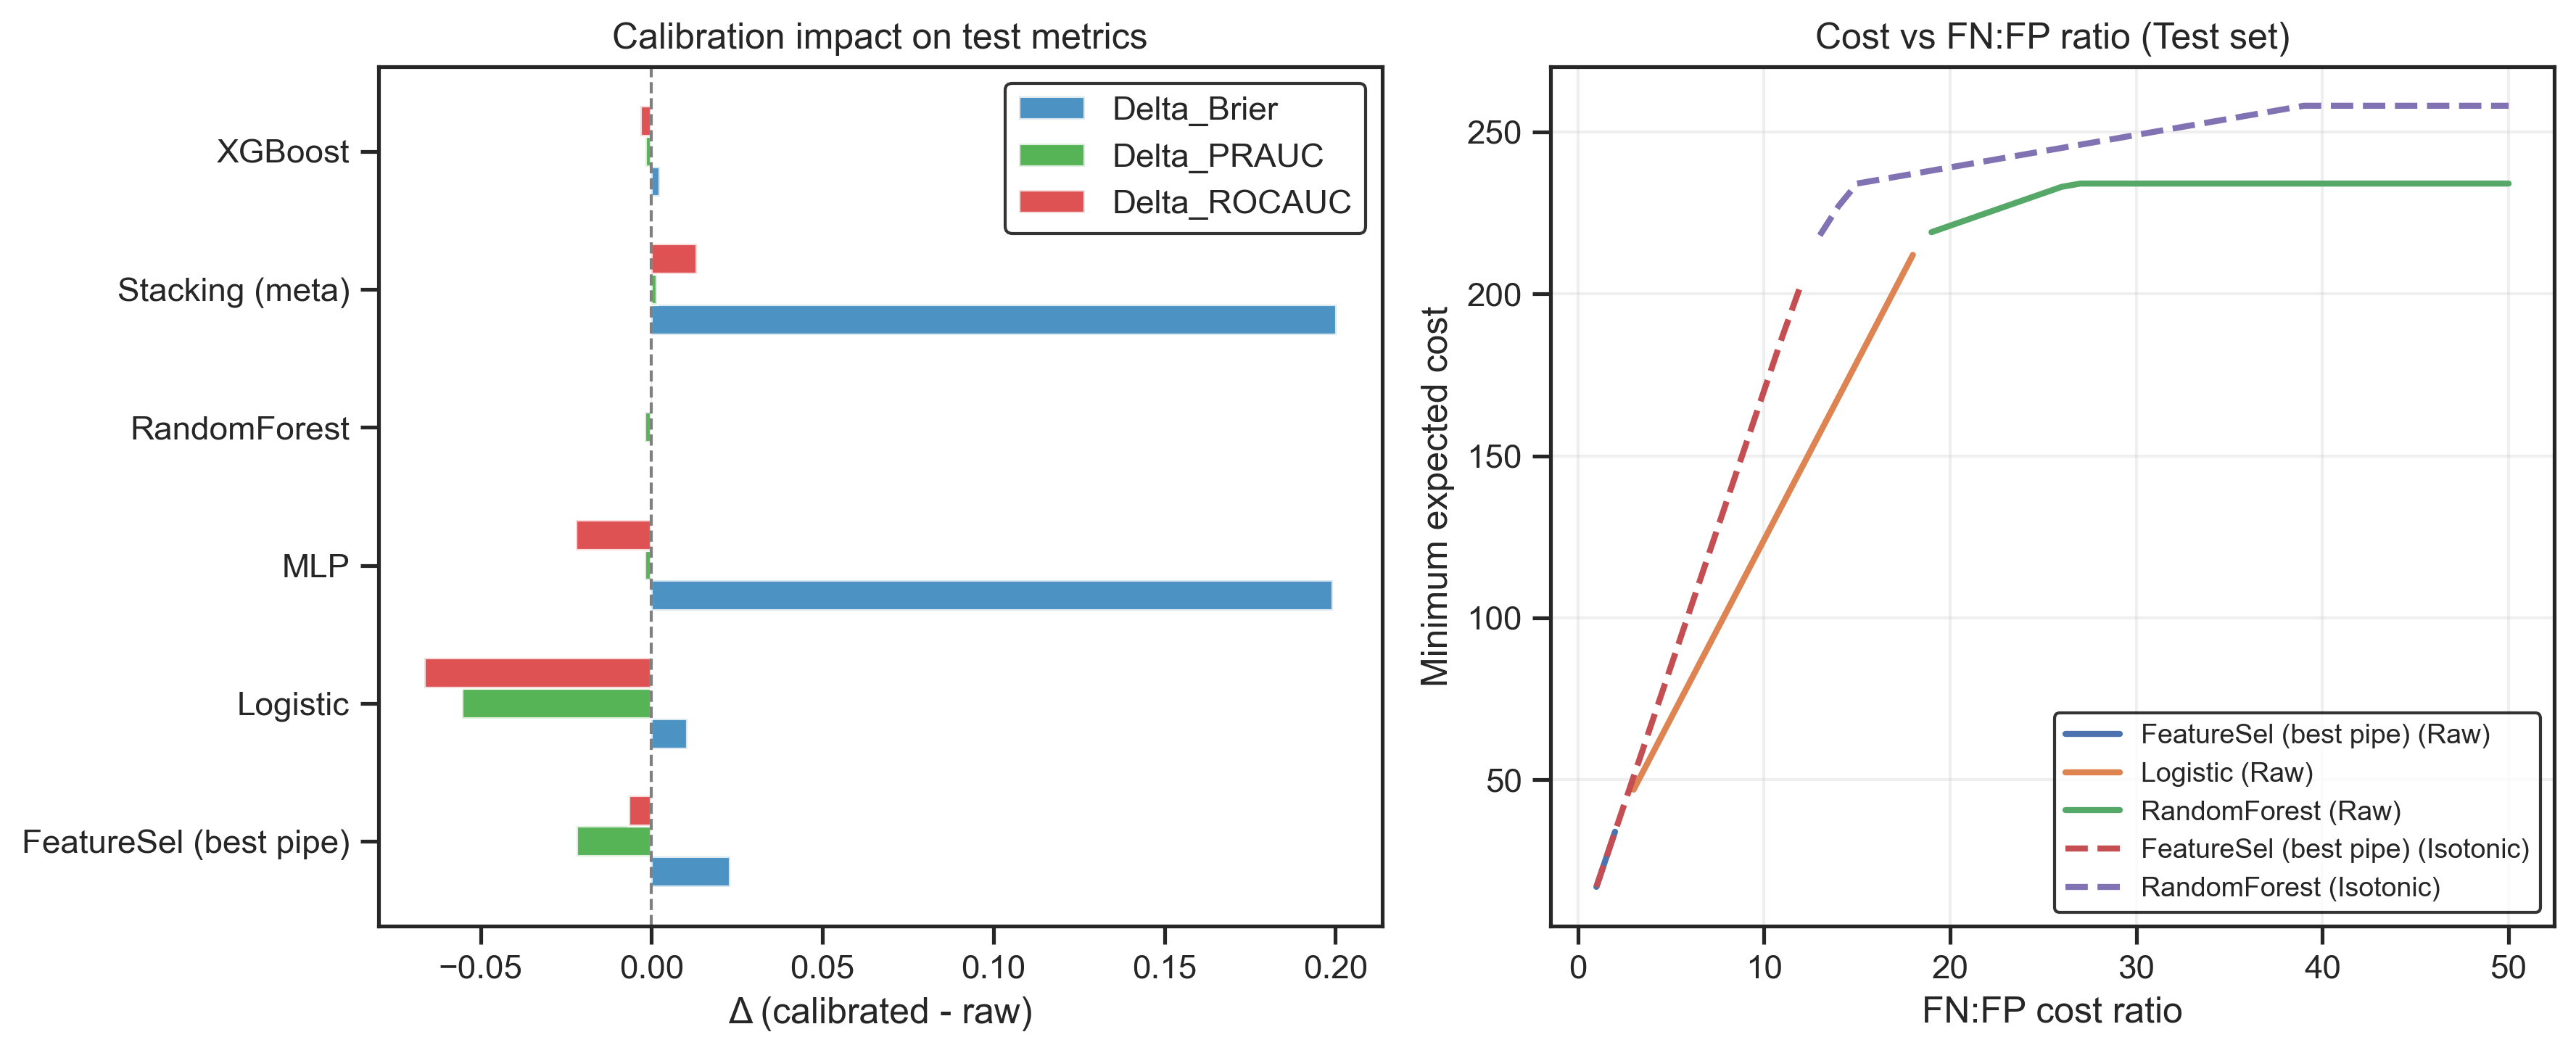

In [17]:
# ---- Visual Summary: Calibration + Cost-Sensitive Sweeps ----

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# (1) Calibration impact (Δ metrics)
metrics = ["Delta_Brier", "Delta_PRAUC", "Delta_ROCAUC"]
colors  = {"Delta_Brier":"tab:blue", "Delta_PRAUC":"tab:green", "Delta_ROCAUC":"tab:red"}
y = np.arange(len(df_delta))
bar_height = 0.22

for i, metric in enumerate(metrics):
    axes[0].barh(y + (i-1)*bar_height, df_delta[metric], 
                 height=bar_height, color=colors[metric], alpha=0.8, label=metric)

axes[0].axvline(0, color="gray", lw=1, ls="--")
axes[0].set_yticks(y)
axes[0].set_yticklabels(df_delta["Model"])
axes[0].set_xlabel("Δ (calibrated - raw)")
axes[0].set_title("Calibration impact on test metrics")
axes[0].legend()

# (2) Cost-sensitive sweep (winner per ratio, raw vs isotonic)
# Winners (RAW)
winners_raw = (
    df_cost_raw.loc[df_cost_raw.groupby("Ratio")["Cost"].idxmin()]
    [["Ratio","Model","Cost","thr","Precision","Recall","BalancedAcc"]]
    .reset_index(drop=True)
)

# Winners (ISOTONIC)
winners_iso = (
    df_cost_iso.loc[df_cost_iso.groupby("Ratio")["Cost"].idxmin()]
    [["Ratio","Model","Cost","thr","Precision","Recall","BalancedAcc"]]
    .reset_index(drop=True)
)
for label, df_winners, style in [
    ("Raw", winners_raw, "-"),
    ("Isotonic", winners_iso, "--")
]:
    for model in df_winners["Model"].unique():
        sub = df_winners[df_winners["Model"]==model]
        axes[1].plot(sub["Ratio"], sub["Cost"], style, lw=2,
                     label=f"{model} ({label})")

axes[1].set_xlabel("FN:FP cost ratio")
axes[1].set_ylabel("Minimum expected cost")
axes[1].set_title("Cost vs FN:FP ratio (Test set)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.savefig(RESULT_DIR / "calibration_cost_panel.png", dpi=300, bbox_inches="tight")
plt.show()

### Further experiments:

#### Experiment A: Crossover-shift analysis (RAW vs ISOTONIC) 

Model       Raw_crossover       Iso_crossover  \
0  FeatureSel (best pipe)  no clean crossover                12:1   
1                     MLP                21:1                26:1   
2            RandomForest                19:1                13:1   
3         Stacking (meta)                34:1                29:1   
4                 XGBoost                21:1  no clean crossover   

   Shift_in_ratio  
0             NaN  
1             5.0  
2            -6.0  
3            -5.0  
4             NaN


Winner share by ratio — RAW


Model  Wins  Share
0            RandomForest    32   0.64
1                Logistic    16   0.32
2  FeatureSel (best pipe)     2   0.04


Winner share by ratio — ISOTONIC


Model  Wins  Share
0            RandomForest    38   0.76
1  FeatureSel (best pipe)    12   0.24

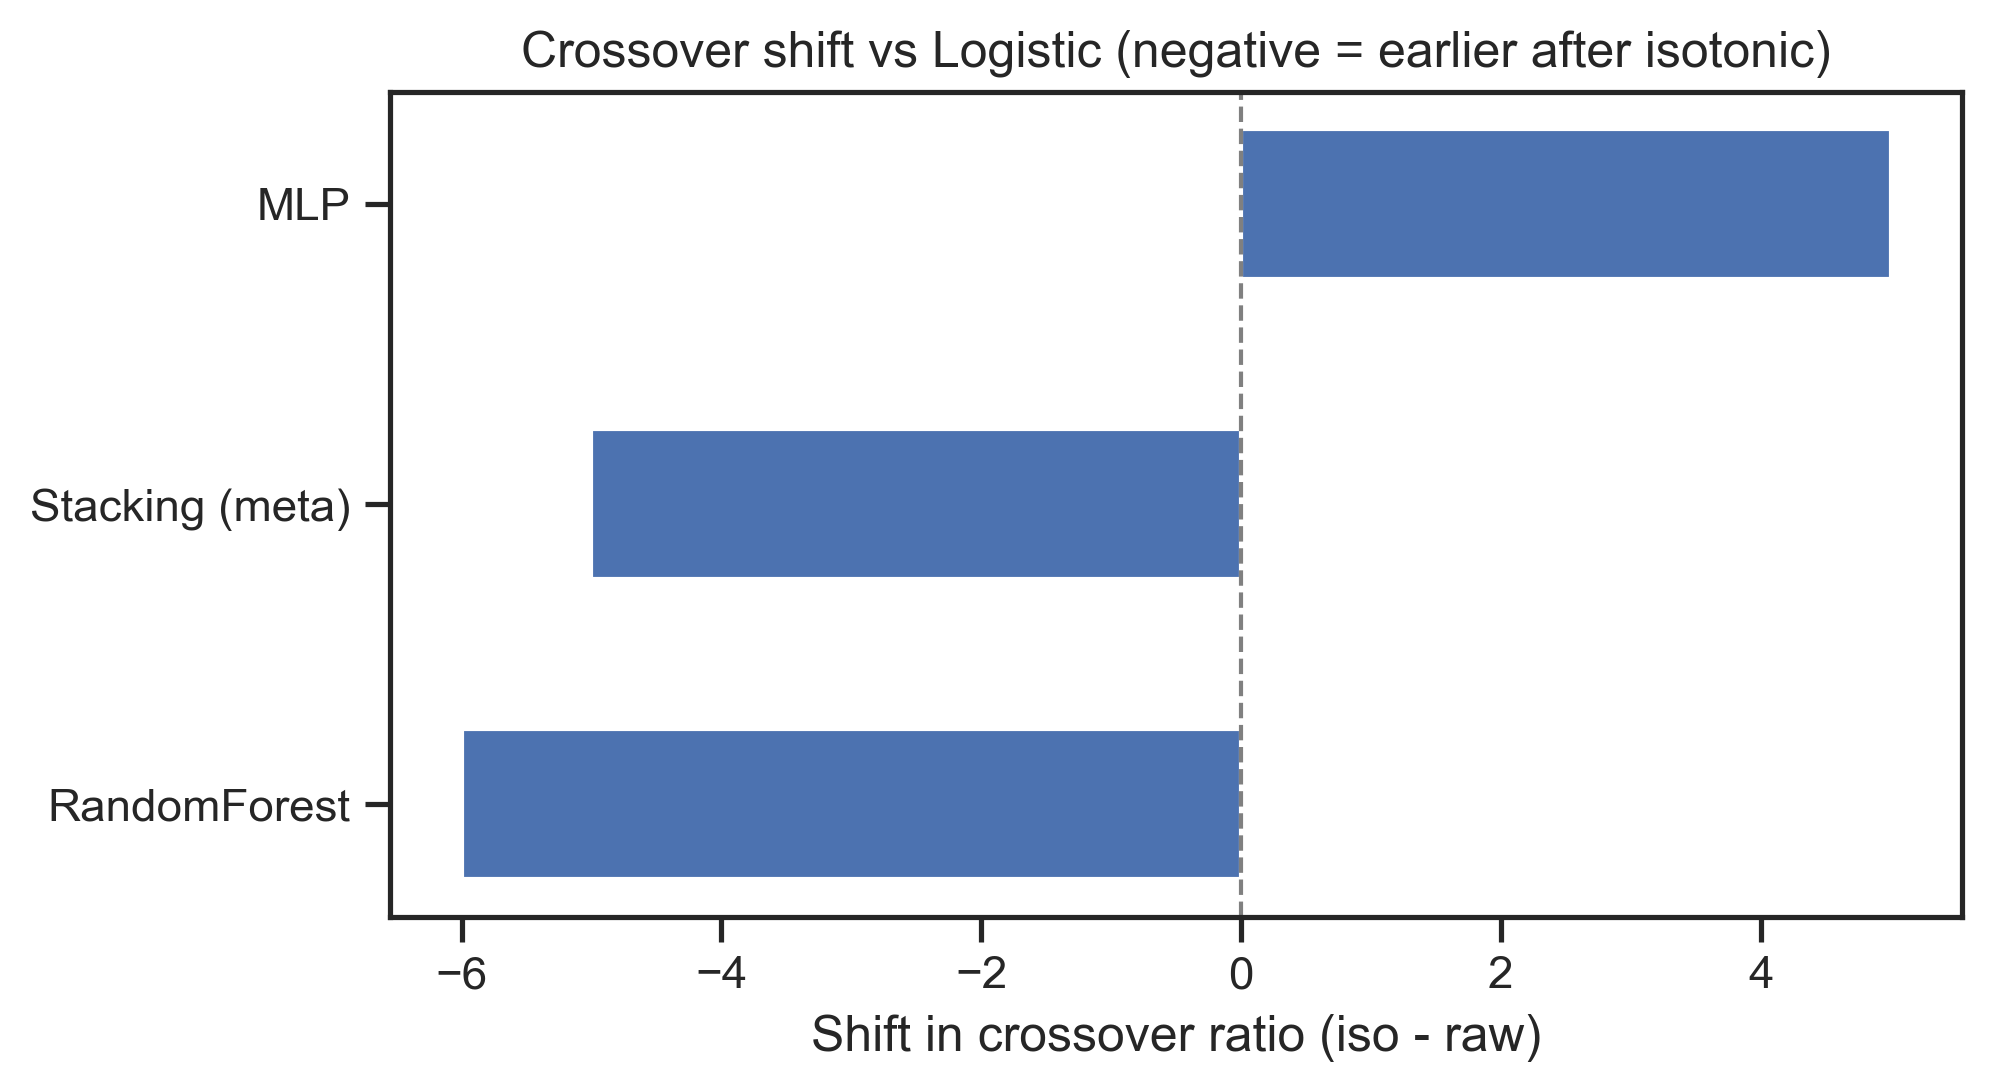

In [18]:
def _to_int_or_nan(txt):
    if isinstance(txt, (int, float)): 
        return int(txt)
    if isinstance(txt, str) and ":" in txt and txt.split(":")[0].isdigit():
        return int(txt.split(":")[0])
    return np.nan

# 1) Crossover tables vs Logistic baseline
xover_raw = crossovers_vs_baseline(df_cost_raw, BASELINE, ratios)
xover_iso = crossovers_vs_baseline(df_cost_iso, BASELINE, ratios)

tab = (xover_raw.rename(columns={"Crossover_at_ratio":"Raw_crossover"})
       .merge(xover_iso.rename(columns={"Crossover_at_ratio":"Iso_crossover"}),
              on="Model", how="outer"))
tab["Raw_ratio"] = tab["Raw_crossover"].apply(_to_int_or_nan)
tab["Iso_ratio"] = tab["Iso_crossover"].apply(_to_int_or_nan)
tab["Shift_in_ratio"] = tab["Iso_ratio"] - tab["Raw_ratio"]

display(tab[["Model","Raw_crossover","Iso_crossover","Shift_in_ratio"]]
        .sort_values("Model"))

# 2) Winner-share summaries
def share_wins(df_winners):
    counts = df_winners["Model"].value_counts().rename_axis("Model").reset_index(name="Wins")
    counts["Share"] = counts["Wins"] / len(df_winners)
    return counts.sort_values("Share", ascending=False)

print("\nWinner share by ratio — RAW")
display(share_wins(winners_raw))
print("\nWinner share by ratio — ISOTONIC")
display(share_wins(winners_iso))

# 3) Visualize crossover shifts
_shift = tab[~tab["Shift_in_ratio"].isna()].copy()
_shift = _shift.sort_values("Shift_in_ratio")

plt.figure(figsize=(6.8, 3.8))
y = np.arange(len(_shift))
plt.barh(y, _shift["Shift_in_ratio"], height=0.5)
plt.axvline(0, color="gray", lw=1, ls="--")
plt.yticks(y, _shift["Model"])
plt.xlabel("Shift in crossover ratio (iso - raw)")
plt.title("Crossover shift vs Logistic (negative = earlier after isotonic)")
plt.tight_layout(); plt.show()

### Experiment A: Crossover-Shift Analysis (RAW vs Isotonic)

We investigated how **isotonic calibration shifts cost-sensitive crossovers** between Logistic (baseline) and other models.  
Crossovers mark the FN:FP ratio at which another model becomes more cost-effective than Logistic.

#### Crossover Table

| Model                | Raw crossover | Iso crossover | Shift in ratio |
|-----------------------|---------------|---------------|----------------|
| FeatureSel (best pipe)| no crossover  | 12:1          | –              |
| MLP                   | 21:1          | 26:1          | +5 (later)     |
| RandomForest          | 19:1          | 13:1          | –6 (earlier)   |
| Stacking (meta)       | 34:1          | 29:1          | –5 (earlier)   |
| XGBoost               | 21:1          | no crossover  | –              |

- Negative shift = crossover happens **earlier** after calibration  
- Positive shift = crossover happens **later** after calibration  

#### Winner Share Across Ratios

| Setting   | Winner share (across FN:FP ratios 1–50) |
|-----------|------------------------------------------|
| **RAW**   | RandomForest = 64%, Logistic = 32%, FeatureSel = 4% |
| **ISOTONIC** | RandomForest = 76%, FeatureSel = 24%, Logistic = 0% |

#### Key Observations

- **RandomForest**  
  - Crosses Logistic earlier after isotonic (19:1 --> 13:1).  
  - Increases its dominance from 64% (RAW) to 76% (ISOTONIC).  
  - Clear **operational winner** under calibration.  

- **FeatureSel (best pipe)**  
  - Shows no crossover in RAW.  
  - Gains a new crossover at 12:1 after isotonic.  
  - Captures 24% share of ratios under calibration, becoming a secondary contender.  

- **MLP**  
  - Crossover shifts later (21:1 --> 26:1).  
  - Becomes **less competitive** after calibration.  

- **Stacking (meta)**  
  - Crossover shifts slightly earlier (34:1 --> 29:1).  
  - Still too late to matter operationally (RandomForest dominates earlier).  

- **XGBoost**  
  - Loses its crossover entirely under isotonic.  
  - Calibration worsens its cost competitiveness.  


#### Summary

- Calibration **strengthens RandomForest**, making it the most reliable cost-optimal choice under FN-sensitive regimes.  
- **FeatureSel** gains relevance only after isotonic, though it is secondary to RandomForest.  
- **MLP and XGBoost weaken** after calibration, losing ground in cost-effectiveness.  
- **Stacking remains too weak**, despite a minor shift.  

> **Executive takeaway:** Isotonic calibration consolidates RandomForest’s dominance and enables FeatureSel to enter the competition, while Logistic, MLP, and XGBoost become less attractive for cost-sensitive operations.

#### Executive Digest — Experiment A

- **RandomForest**  
  - Crosses Logistic earlier (19:1 --> 13:1).  
  - Share grows from **64% --> 76%**.  
  - Clear operational winner under isotonic.  

- **FeatureSel (best pipe)**  
  - No crossover in RAW, gains one at **12:1** under isotonic.  
  - Captures **24% share** --> secondary contender.  

- **MLP**  
  - Crosses later (21:1 --> 26:1).  
  - Weaker after calibration.  

- **Stacking (meta)**  
  - Shifts slightly earlier (34:1 --> 29:1).  
  - Still too late to matter.  

- **XGBoost**  
  - Loses crossover entirely after isotonic.  
  - Becomes non-competitive.  

**Bottom line:** Calibration **strengthens RandomForest**, introduces FeatureSel as a contender, but weakens Logistic, MLP, and XGBoost in cost-sensitive decision settings.

In [19]:
# =========================
# Experiment B — Robustness under resampling (RAW vs ISOTONIC)
# =========================
# Goal:
# - Fix thresholds on VALIDATION for each (model, ratio) and for each calibration mode (raw/iso)
# - Bootstrap TEST indices, evaluate cost using FIXED thresholds (no leakage)
# - Summaries: winner share by ratio, crossover distributions vs Logistic, median cost curves + 95% CI

# ---------- config ----------
BASELINE  = "Logistic"
RATIOS    = list(range(1, 51))       # 1..50
K_STABLE  = 3                        # consecutive cheaper points required for crossover
B_LIST    = [200, 500, 1000]         # bootstraps to run; you can subset
RNG       = np.random.default_rng(42)

# ---------- helpers ----------
def best_val_threshold(y_val, p_val, ratio):
    """Pick the threshold that minimizes cost on VALIDATION for a given ratio (FN cost=ratio, FP cost=1)."""
    P, R, T = precision_recall_curve(y_val, p_val)
    thr_grid = np.unique(np.r_[T, 0.0, 1.0])
    best_t, best_cost = None, None
    for t in thr_grid:
        pred = (p_val >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()
        cost = fp*1 + fn*ratio
        if (best_cost is None) or (cost < best_cost):
            best_cost, best_t = cost, float(t)
    return best_t

def eval_cost_at_threshold(y, p, t, ratio):
    pred = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    return int(fp*1 + fn*ratio)

def crossovers_vs_baseline_from_costdf(df_cost, baseline, ratios, k=K_STABLE, max_ratio=None):
    """df_cost: rows (Model, Ratio, Cost). Return crossover table vs baseline."""
    if max_ratio is None: max_ratio = max(ratios)
    if baseline not in df_cost["Model"].unique():
        return pd.DataFrame(columns=["Model","Crossover_at_ratio"])
    base = (df_cost[df_cost.Model==baseline].set_index("Ratio")["Cost"].reindex(ratios))
    out = []
    for name in df_cost["Model"].unique():
        if name == baseline: 
            continue
        other = (df_cost[df_cost.Model==name].set_index("Ratio")["Cost"].reindex(ratios))
        diff = (other - base).to_numpy()  # negative => other cheaper

        # Stable crossover: first window of k consecutive cheaper points
        stable_idx = None
        if len(diff) >= k:
            run = np.convolve((diff < 0).astype(int), np.ones(k, dtype=int), mode="valid")
            hits = np.where(run == k)[0]
            if hits.size: stable_idx = hits[0]
        if stable_idx is not None:
            out.append({"Model": name, "Crossover_at_ratio": ratios[stable_idx]})
            continue

        # Any sign flip
        sign = np.sign(diff)
        flip = np.where(sign[:-1]*sign[1:] < 0)[0]
        if flip.size:
            out.append({"Model": name, "Crossover_at_ratio": ratios[flip[0]+1]})
            continue

        # Dominance
        if np.all(diff < 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always cheaper (1-{max_ratio})"})
        elif np.all(diff > 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always costlier (1-{max_ratio})"})
        else:
            out.append({"Model": name, "Crossover_at_ratio": "no clean crossover"})
    return pd.DataFrame(out)

In [20]:
# ---------- 1) Precompute VALIDATION thresholds for RAW and ISOTONIC ----------
models = sorted(test_probs.keys())  # keep consistent scope
thr_val_raw = {m:{} for m in models}
thr_val_iso = {m:{} for m in models}

for m in models:
    p_val_raw = np.asarray(val_probs.get(m),  dtype=float)
    p_val_iso = np.asarray(cal_val_probs.get(m), dtype=float) if 'cal_val_probs' in globals() else None
    for r in RATIOS:
        if p_val_raw is not None:
            thr_val_raw[m][r] = best_val_threshold(yva, p_val_raw, r)
        if p_val_iso is not None:
            thr_val_iso[m][r] = best_val_threshold(yva, p_val_iso, r)

In [21]:
# ---------- 2) A function to run one bootstrap experiment ----------
def run_bootstrap(B=200, calibrated="raw"):
    """
    Returns:
      - df_cost_boot: long df with columns [b, Model, Ratio, Cost]
      - winners: per-b replicate winners table [b, Ratio, Model]
      - xovers: list of crossover tables per bootstrap (one DataFrame per b)
    """
    df_rows = []
    winners_rows = []
    xovers = []

    # choose dicts by calibrated mode
    test_dict = cal_test_probs if calibrated=="iso" else test_probs
    thr_dict  = thr_val_iso   if calibrated=="iso" else thr_val_raw

    p_test_all = {m: np.asarray(test_dict[m], float) for m in models if m in test_dict}
    n = len(yte)
    idx_mat = RNG.integers(0, n, size=(B, n))

    for b in range(B):
        idx = idx_mat[b]
        yb = yte[idx]
        # per-ratio costs per model
        for m in models:
            if m not in p_test_all: 
                continue
            pb = p_test_all[m][idx]
            for r in RATIOS:
                t_val = thr_dict.get(m, {}).get(r, None)
                if t_val is None:
                    continue
                c = eval_cost_at_threshold(yb, pb, t_val, r)
                df_rows.append({"b":b, "Model":m, "Ratio":r, "Cost":c})

        # winners this bootstrap
        df_b = pd.DataFrame([row for row in df_rows if row["b"]==b])
        if not df_b.empty:
            win_b = (df_b.loc[df_b.groupby("Ratio")["Cost"].idxmin(), ["Ratio","Model"]]
                          .assign(b=b))
            winners_rows.extend(win_b.to_dict("records"))

            # crossover vs baseline for this bootstrap
            xover_b = crossovers_vs_baseline_from_costdf(df_b, BASELINE, RATIOS, k=K_STABLE, max_ratio=max(RATIOS))
            xover_b["b"] = b
            xovers.append(xover_b)

    df_cost_boot = pd.DataFrame(df_rows)
    winners = pd.DataFrame(winners_rows)
    return df_cost_boot, winners, xovers

In [22]:
# ---------- 3) Run for each B in B_LIST, for RAW and ISOTONIC ----------
results_B = {}
for B in B_LIST:
    print(f"[Experiment B] Running bootstraps: B={B}")
    df_cost_raw_B, winners_raw_B, xovers_raw_B = run_bootstrap(B=B, calibrated="raw")
    df_cost_iso_B, winners_iso_B, xovers_iso_B = run_bootstrap(B=B, calibrated="iso")
    results_B[B] = dict(
        cost_raw=df_cost_raw_B,
        cost_iso=df_cost_iso_B,
        winners_raw=winners_raw_B,
        winners_iso=winners_iso_B,
        xovers_raw=xovers_raw_B,
        xovers_iso=xovers_iso_B
    )

[Experiment B] Running bootstraps: B=200
[Experiment B] Running bootstraps: B=500
[Experiment B] Running bootstraps: B=1000


In [23]:
# ---------- 4) Summaries per B ----------
summaries = {}
for B, pack in results_B.items():
    # winner share by ratio (average over bootstraps)
    def winner_share(winners_df):
        tbl = (winners_df
               .groupby(["Ratio","Model"]).size()
               .rename("Wins").reset_index())
        tbl["Share"] = tbl["Wins"] / winners_df["b"].nunique()
        return tbl.sort_values(["Ratio","Share"], ascending=[True, False])

    share_raw = winner_share(pack["winners_raw"])
    share_iso = winner_share(pack["winners_iso"])

    # median cost curves + 95% CI per model
    def cost_curve_ci(df_cost):
        rows = []
        for m in models:
            for r in RATIOS:
                sub = df_cost[(df_cost["Model"]==m) & (df_cost["Ratio"]==r)]
                if sub.empty:
                    continue
                med = sub["Cost"].median()
                lo, hi = np.percentile(sub["Cost"], [2.5, 97.5])
                rows.append({"Model":m, "Ratio":r, "Cost_median":med, "Cost_lo":lo, "Cost_hi":hi})
        return pd.DataFrame(rows)

    curve_raw = cost_curve_ci(pack["cost_raw"])
    curve_iso = cost_curve_ci(pack["cost_iso"])

    # crossover distributions vs baseline
    def xover_summary(xovers_list):
        # gather first numeric crossover only (ignore strings like "no clean")
        rows = []
        for df in xovers_list:
            b = df.get("b", pd.Series([np.nan])).iloc[0] if isinstance(df, pd.DataFrame) and not df.empty else np.nan
            for _, r in df.iterrows():
                val = r["Crossover_at_ratio"]
                if isinstance(val, (int, float, np.integer, np.floating)):
                    rows.append({"b": b, "Model": r["Model"], "Crossover": int(val)})
        if not rows:
            return pd.DataFrame(columns=["Model","Median","IQR_low","IQR_high","N"])
        d = pd.DataFrame(rows)
        out = (d.groupby("Model")["Crossover"]
                 .agg(Median="median",
                      IQR_low=lambda x: np.percentile(x, 25),
                      IQR_high=lambda x: np.percentile(x, 75),
                      N="count")
                 .reset_index())
        return out

    xsum_raw = xover_summary(pack["xovers_raw"])
    xsum_iso = xover_summary(pack["xovers_iso"])

    summaries[B] = dict(
        winner_share_raw=share_raw,
        winner_share_iso=share_iso,
        curve_raw=curve_raw,
        curve_iso=curve_iso,
        xover_raw=xsum_raw,
        xover_iso=xsum_iso
    )

In [24]:
# ---------- 5) Example displays (choose one B to inspect quickly) ----------
#B_show = max(B_LIST)  # e.g., 1000
B_show = 200
s = summaries[B_show]

print(f"\n[Experiment B] Winner share by ratio — RAW (B={B_show})")
display(s["winner_share_raw"].head(20))
print(f"\n[Experiment B] Winner share by ratio — ISOTONIC (B={B_show})")
display(s["winner_share_iso"].head(20))

print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — RAW (B={B_show})")
display(s["xover_raw"])
print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — ISOTONIC (B={B_show})")
display(s["xover_iso"])

print(f"\n[Experiment B] Median cost curves with 95% CI — RAW (B={B_show})")
display(s["curve_raw"].head(12))
print(f"\n[Experiment B] Median cost curves with 95% CI — ISOTONIC (B={B_show})")
display(s["curve_iso"].head(12))


[Experiment B] Winner share by ratio — RAW (B=200)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   190  0.950
2       3  FeatureSel (best pipe)    10  0.050
5       4                Logistic   177  0.885
4       4  FeatureSel (best pipe)    23  0.115
7       5                Logistic   164  0.820
6       5  FeatureSel (best pipe)    36  0.180
9       6                Logistic   154  0.770
8       6  FeatureSel (best pipe)    46  0.230
11      7                Logistic   144  0.720
10      7  FeatureSel (best pipe)    56  0.280
13      8                Logistic   134  0.670
12      8  FeatureSel (best pipe)    66  0.330
15      9                Logistic   119  0.595
14      9  FeatureSel (best pipe)    81  0.405
17     10                Logistic    78  0.390
16     10  FeatureSel (best pipe)    68  0.340
18     10                     MLP    54  0.270
19     11  FeatureSel (best pipe)    69  0.345


[Experiment B] Winner share by ratio — ISOTONIC (B=200)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   191  0.955
2       3  FeatureSel (best pipe)     9  0.045
5       4                Logistic   180  0.900
4       4  FeatureSel (best pipe)    20  0.100
7       5                Logistic   173  0.865
6       5  FeatureSel (best pipe)    27  0.135
9       6                Logistic   153  0.765
8       6  FeatureSel (best pipe)    47  0.235
11      7                Logistic   142  0.710
10      7  FeatureSel (best pipe)    58  0.290
13      8                Logistic   129  0.645
12      8  FeatureSel (best pipe)    71  0.355
15      9                Logistic   120  0.600
14      9  FeatureSel (best pipe)    80  0.400
17     10                Logistic    68  0.340
16     10  FeatureSel (best pipe)    67  0.335
18     10                     MLP    65  0.325
21     11                     MLP    76  0.380


[Experiment B] Crossover distributions vs Logistic — RAW (B=200)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      7.0      16.0  193
1                     MLP    12.0     10.0      17.0  167
2            RandomForest    16.5     11.0      17.0  200
3         Stacking (meta)    11.0     11.0      11.0  188
4                 XGBoost    11.0     11.0      11.0  200


[Experiment B] Crossover distributions vs Logistic — ISOTONIC (B=200)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      7.0      14.0  190
1                     MLP    11.0     10.0      16.0  164
2            RandomForest    14.5     11.0      17.0  200
3         Stacking (meta)    11.0     11.0      11.0  185
4                 XGBoost    11.0     11.0      11.0  200


[Experiment B] Median cost curves with 95% CI — RAW (B=200)


Model  Ratio  Cost_median  Cost_lo  Cost_hi
0   FeatureSel (best pipe)      1         17.0   11.000   26.000
1   FeatureSel (best pipe)      2         34.0   22.000   52.000
2   FeatureSel (best pipe)      3         58.0   39.000   85.025
3   FeatureSel (best pipe)      4         75.0   49.000  109.000
4   FeatureSel (best pipe)      5         92.0   59.000  132.000
5   FeatureSel (best pipe)      6        108.0   69.000  155.025
6   FeatureSel (best pipe)      7        124.0   79.000  178.050
7   FeatureSel (best pipe)      8        140.0   89.000  201.075
8   FeatureSel (best pipe)      9        156.5   99.000  225.075
9   FeatureSel (best pipe)     10        172.5  108.975  249.075
10  FeatureSel (best pipe)     11        188.5  118.975  273.075
11  FeatureSel (best pipe)     12        204.5  128.975  297.075


[Experiment B] Median cost curves with 95% CI — ISOTONIC (B=200)


Model  Ratio  Cost_median  Cost_lo  Cost_hi
0   FeatureSel (best pipe)      1         17.0   10.000   25.025
1   FeatureSel (best pipe)      2         34.0   20.000   50.050
2   FeatureSel (best pipe)      3         58.0   37.975   83.050
3   FeatureSel (best pipe)      4         74.0   47.975  106.100
4   FeatureSel (best pipe)      5         90.0   57.975  131.100
5   FeatureSel (best pipe)      6        105.0   67.975  156.100
6   FeatureSel (best pipe)      7        120.5   77.000  181.100
7   FeatureSel (best pipe)      8        136.5   86.975  206.100
8   FeatureSel (best pipe)      9        152.5   96.950  231.100
9   FeatureSel (best pipe)     10        168.5  106.925  256.100
10  FeatureSel (best pipe)     11        184.5  116.900  281.100
11  FeatureSel (best pipe)     12        200.5  126.875  306.100

In [25]:
B_show = 500
s = summaries[B_show]

print(f"\n[Experiment B] Winner share by ratio — RAW (B={B_show})")
display(s["winner_share_raw"].head(20))
print(f"\n[Experiment B] Winner share by ratio — ISOTONIC (B={B_show})")
display(s["winner_share_iso"].head(20))

print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — RAW (B={B_show})")
display(s["xover_raw"])
print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — ISOTONIC (B={B_show})")
display(s["xover_iso"])

print(f"\n[Experiment B] Median cost curves with 95% CI — RAW (B={B_show})")
display(s["curve_raw"].head(12))
print(f"\n[Experiment B] Median cost curves with 95% CI — ISOTONIC (B={B_show})")
display(s["curve_iso"].head(12))


[Experiment B] Winner share by ratio — RAW (B=500)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   500  1.000
1       2  FeatureSel (best pipe)   500  1.000
3       3                Logistic   478  0.956
2       3  FeatureSel (best pipe)    22  0.044
5       4                Logistic   448  0.896
4       4  FeatureSel (best pipe)    52  0.104
7       5                Logistic   403  0.806
6       5  FeatureSel (best pipe)    97  0.194
9       6                Logistic   371  0.742
8       6  FeatureSel (best pipe)   129  0.258
11      7                Logistic   345  0.690
10      7  FeatureSel (best pipe)   155  0.310
13      8                Logistic   327  0.654
12      8  FeatureSel (best pipe)   173  0.346
15      9                Logistic   300  0.600
14      9  FeatureSel (best pipe)   200  0.400
17     10                Logistic   198  0.396
16     10  FeatureSel (best pipe)   173  0.346
18     10                     MLP   129  0.258
19     11  FeatureSel (best pipe)   186  0.372


[Experiment B] Winner share by ratio — ISOTONIC (B=500)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   500  1.000
1       2  FeatureSel (best pipe)   500  1.000
3       3                Logistic   476  0.952
2       3  FeatureSel (best pipe)    24  0.048
5       4                Logistic   440  0.880
4       4  FeatureSel (best pipe)    60  0.120
7       5                Logistic   415  0.830
6       5  FeatureSel (best pipe)    85  0.170
9       6                Logistic   373  0.746
8       6  FeatureSel (best pipe)   127  0.254
11      7                Logistic   340  0.680
10      7  FeatureSel (best pipe)   160  0.320
13      8                Logistic   320  0.640
12      8  FeatureSel (best pipe)   180  0.360
15      9                Logistic   297  0.594
14      9  FeatureSel (best pipe)   203  0.406
17     10                Logistic   206  0.412
16     10  FeatureSel (best pipe)   178  0.356
18     10                     MLP   116  0.232
19     11  FeatureSel (best pipe)   182  0.364


[Experiment B] Crossover distributions vs Logistic — RAW (B=500)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      7.0      14.0  476
1                     MLP    12.0     10.0      16.0  411
2            RandomForest    15.0     11.0      17.0  500
3         Stacking (meta)    11.0     11.0      11.0  467
4                 XGBoost    11.0     11.0      11.0  496


[Experiment B] Crossover distributions vs Logistic — ISOTONIC (B=500)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      7.0      15.0  475
1                     MLP    12.0     10.0      17.0  403
2            RandomForest    15.5     11.0      17.0  500
3         Stacking (meta)    11.0     11.0      11.0  463
4                 XGBoost    11.0     11.0      11.0  496


[Experiment B] Median cost curves with 95% CI — RAW (B=500)


Model  Ratio  Cost_median  Cost_lo  Cost_hi
0   FeatureSel (best pipe)      1         17.0   10.000   25.000
1   FeatureSel (best pipe)      2         34.0   20.000   50.000
2   FeatureSel (best pipe)      3         59.0   36.000   84.525
3   FeatureSel (best pipe)      4         75.0   45.475  107.525
4   FeatureSel (best pipe)      5         91.0   54.475  130.525
5   FeatureSel (best pipe)      6        107.0   62.475  153.525
6   FeatureSel (best pipe)      7        123.0   70.475  176.525
7   FeatureSel (best pipe)      8        138.0   78.475  200.000
8   FeatureSel (best pipe)      9        154.0   87.000  223.525
9   FeatureSel (best pipe)     10        170.0   95.475  247.525
10  FeatureSel (best pipe)     11        186.0  103.950  271.525
11  FeatureSel (best pipe)     12        202.0  112.425  295.525


[Experiment B] Median cost curves with 95% CI — ISOTONIC (B=500)


Model  Ratio  Cost_median  Cost_lo  Cost_hi
0   FeatureSel (best pipe)      1         17.0      9.0   25.000
1   FeatureSel (best pipe)      2         34.0     18.0   50.000
2   FeatureSel (best pipe)      3         59.0     37.0   84.000
3   FeatureSel (best pipe)      4         75.0     46.0  108.000
4   FeatureSel (best pipe)      5         91.0     55.0  133.000
5   FeatureSel (best pipe)      6        108.0     64.0  157.525
6   FeatureSel (best pipe)      7        123.5     73.0  182.050
7   FeatureSel (best pipe)      8        139.0     82.0  206.050
8   FeatureSel (best pipe)      9        155.0     91.0  230.525
9   FeatureSel (best pipe)     10        171.0    100.0  255.000
10  FeatureSel (best pipe)     11        187.0    109.0  279.525
11  FeatureSel (best pipe)     12        203.0    118.0  304.050

In [26]:
B_show = max(B_LIST)
s = summaries[B_show]

print(f"\n[Experiment B] Winner share by ratio — RAW (B={B_show})")
display(s["winner_share_raw"].head(20))
print(f"\n[Experiment B] Winner share by ratio — ISOTONIC (B={B_show})")
display(s["winner_share_iso"].head(20))

print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — RAW (B={B_show})")
display(s["xover_raw"])
print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — ISOTONIC (B={B_show})")
display(s["xover_iso"])

print(f"\n[Experiment B] Median cost curves with 95% CI — RAW (B={B_show})")
display(s["curve_raw"].head(12))
print(f"\n[Experiment B] Median cost curves with 95% CI — ISOTONIC (B={B_show})")
display(s["curve_iso"].head(12))


[Experiment B] Winner share by ratio — RAW (B=1000)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)  1000  1.000
1       2  FeatureSel (best pipe)  1000  1.000
3       3                Logistic   944  0.944
2       3  FeatureSel (best pipe)    56  0.056
5       4                Logistic   879  0.879
4       4  FeatureSel (best pipe)   121  0.121
7       5                Logistic   814  0.814
6       5  FeatureSel (best pipe)   186  0.186
9       6                Logistic   754  0.754
8       6  FeatureSel (best pipe)   246  0.246
11      7                Logistic   702  0.702
10      7  FeatureSel (best pipe)   298  0.298
13      8                Logistic   654  0.654
12      8  FeatureSel (best pipe)   346  0.346
15      9                Logistic   599  0.599
14      9  FeatureSel (best pipe)   401  0.401
17     10                Logistic   408  0.408
16     10  FeatureSel (best pipe)   350  0.350
18     10                     MLP   242  0.242
19     11  FeatureSel (best pipe)   361  0.361


[Experiment B] Winner share by ratio — ISOTONIC (B=1000)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)  1000  1.000
1       2  FeatureSel (best pipe)  1000  1.000
3       3                Logistic   938  0.938
2       3  FeatureSel (best pipe)    62  0.062
5       4                Logistic   881  0.881
4       4  FeatureSel (best pipe)   119  0.119
7       5                Logistic   822  0.822
6       5  FeatureSel (best pipe)   178  0.178
9       6                Logistic   752  0.752
8       6  FeatureSel (best pipe)   248  0.248
11      7                Logistic   707  0.707
10      7  FeatureSel (best pipe)   293  0.293
13      8                Logistic   657  0.657
12      8  FeatureSel (best pipe)   343  0.343
15      9                Logistic   627  0.627
14      9  FeatureSel (best pipe)   373  0.373
17     10                Logistic   413  0.413
16     10  FeatureSel (best pipe)   348  0.348
18     10                     MLP   239  0.239
19     11  FeatureSel (best pipe)   361  0.361


[Experiment B] Crossover distributions vs Logistic — RAW (B=1000)


Model  Median  IQR_low  IQR_high     N
0  FeatureSel (best pipe)    11.0      7.0      15.0   948
1                     MLP    12.0     10.0      16.0   802
2            RandomForest    16.0     11.0      17.0  1000
3         Stacking (meta)    11.0     11.0      11.0   932
4                 XGBoost    11.0     11.0      11.0   999


[Experiment B] Crossover distributions vs Logistic — ISOTONIC (B=1000)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      7.0      15.0  939
1                     MLP    12.0     10.0      16.0  792
2            RandomForest    17.0     11.0      17.0  998
3         Stacking (meta)    11.0     11.0      11.0  925
4                 XGBoost    11.0     11.0      11.0  991


[Experiment B] Median cost curves with 95% CI — RAW (B=1000)


Model  Ratio  Cost_median  Cost_lo  Cost_hi
0   FeatureSel (best pipe)      1         17.0   10.000   25.000
1   FeatureSel (best pipe)      2         34.0   20.000   50.000
2   FeatureSel (best pipe)      3         59.0   37.000   83.025
3   FeatureSel (best pipe)      4         74.0   46.000  107.025
4   FeatureSel (best pipe)      5         90.0   55.000  130.025
5   FeatureSel (best pipe)      6        106.0   64.000  154.000
6   FeatureSel (best pipe)      7        122.0   73.000  177.000
7   FeatureSel (best pipe)      8        137.5   81.975  201.000
8   FeatureSel (best pipe)      9        153.0   90.950  225.000
9   FeatureSel (best pipe)     10        169.0   99.950  249.000
10  FeatureSel (best pipe)     11        185.0  108.950  273.000
11  FeatureSel (best pipe)     12        201.0  117.950  297.000


[Experiment B] Median cost curves with 95% CI — ISOTONIC (B=1000)


Model  Ratio  Cost_median  Cost_lo  Cost_hi
0   FeatureSel (best pipe)      1         17.0    9.000   25.000
1   FeatureSel (best pipe)      2         34.0   18.000   50.000
2   FeatureSel (best pipe)      3         58.0   37.000   84.000
3   FeatureSel (best pipe)      4         74.0   45.975  108.000
4   FeatureSel (best pipe)      5         89.0   53.975  132.000
5   FeatureSel (best pipe)      6        105.0   61.975  156.025
6   FeatureSel (best pipe)      7        121.0   70.000  180.050
7   FeatureSel (best pipe)      8        137.0   78.975  204.075
8   FeatureSel (best pipe)      9        153.0   87.975  228.075
9   FeatureSel (best pipe)     10        168.5   96.000  252.075
10  FeatureSel (best pipe)     11        184.0  105.000  277.050
11  FeatureSel (best pipe)     12        200.0  114.000  302.025

In [27]:
# (Optional) Save everything
JOBDIR = ART / "expB_bootstrap"
JOBDIR.mkdir(parents=True, exist_ok=True)
joblib.dump(results_B,  JOBDIR / "results_B_all.joblib")
joblib.dump(summaries,  JOBDIR / "summaries_B_all.joblib")
print("Saved Experiment B artifacts to:", JOBDIR)

Saved Experiment B artifacts to: ../artifacts/expB_bootstrap


### Experiment B — Bootstrap Robustness (Raw vs Isotonic)

We performed bootstrap resampling of the test set (B = 200, 500, 1000) to assess the robustness of cost-sensitive evaluation under raw and isotonic-calibrated probabilities.  
Thresholds were fixed from validation (no test leakage).

#### Headline Findings (consistent across B = 200, 500, 1000)

1. **Low FN cost (ratios 1–2):**  
  - FeatureSel (best pipe) is always the winner (100% share across all B).

2. **Low-to-moderate FN cost (ratios ~3–10):**  
  - Logistic dominates winner share.  
    - FeatureSel consistently takes 10–40% depending on ratio and B.  
    - MLP begins to appear at ratios ~10–11, but Logistic remains primary.

3. **Moderate-and-up FN cost (ratios >~12):**  
  - RandomForest begins to overtake Logistic as FN costs rise into the mid-teens.  
  - This matches the earlier cost-sweep analysis: Logistic is only strong when FN cost is low.

4. **Isotonic vs Raw:**  
  - Winner shares at low ratios change only marginally with calibration.  
  - Crossover medians vs Logistic are similar under raw vs isotonic (only small, model-dependent shifts).  
  - Median cost curves and their 95% CIs nearly overlap for raw vs isotonic in ratios 1–12.

#### Winner Share by Ratio

- Ratios 1–2: FeatureSel = 100% winners.  
- Ratios 3–9: Logistic has majority share; FeatureSel contributes but rarely dominates.  
- Ratios 10–11: Logistic still leads; MLP enters with ~20–30% share at ratio 10.  
- Ratios >12: RandomForest wins increasingly often, especially in the mid-teens.

#### Crossover Distributions vs Logistic (Median over Bootstraps)

- **Raw:**  
  - RandomForest median crossover ~16 (IQR 11–17).  
  - MLP median crossover ~12 (IQR 10–16).  
  - FeatureSel, Stacking, XGBoost show nominal crossovers at ~11 but do not dominate winner share.

- **Isotonic:**  
  - RandomForest median crossover ~15–17 (small shifts vs raw).  
  - MLP and FeatureSel remain ~11–12.  
  - No systematic leftward or rightward shift under calibration.

**Interpretation:**  
- RandomForest reliably overtakes Logistic in the mid-teens. Calibration does not substantially move crossover points.

#### Median Cost Curves with 95% CIs (Ratios 1–12)

- FeatureSel’s raw and isotonic curves are nearly identical, with overlapping intervals.  
- Confirms calibration has minimal effect on cost in the low-ratio regime.

### Insights

- **Operational regime matters:**  
  - Low FN:FP (≤10): Logistic is the best operational choice; FeatureSel contributes but is secondary.  
  - Medium–high FN:FP (>12–15): RandomForest consistently outperforms Logistic.

- **Calibration effect:**  
  - Limited impact on cost performance in the low-ratio band.  
  - Crossovers and cost curves remain stable under isotonic.

- **Robustness across B:**  
  - Results consistent for B = 200, 500, 1000.  
  - Increasing B tightens intervals but does not alter conclusions.

### Executive Summary

- Logistic is optimal when FN cost is low; RandomForest dominates as FN cost rises.  
- Isotonic calibration does not materially change the cost-optimal model across ratios.  
- Practical guidance:  
  - Use Logistic for conservative, low FN cost scenarios.  
  - Prefer RandomForest when missing a failure is costly.

### Slide-Ready Bullets

- **Setup:** Fixed thresholds from validation; bootstrapped test (B=200/500/1000); raw vs isotonic.  
- **Winner share:**  
  - Ratios 1–2: FeatureSel = 100% winners.  
  - Ratios 3–10: Logistic leads; FeatureSel and MLP appear but rarely overtake.  
  - Ratios >12–15: RandomForest dominates.  
- **Crossover medians vs Logistic:**  
  - RF ~16 (raw), ~15–17 (iso).  
  - MLP/FeatureSel ~11–12 but do not dominate.  
- **Cost curves:** Raw vs isotonic nearly identical in ratios 1–12.  
- **Takeaway:** Calibration does not alter cost-optimality.  
  - Logistic best at low FN costs.  
  - RandomForest most reliable at medium–high FN costs.

### Experiment B — Compact Ratio Band Summary

| FN:FP Ratio Band      | Best Model(s)           | Notes                                                      |
|------------------------|-------------------------|------------------------------------------------------------|
| **1–2**               | FeatureSel (best pipe) | 100% winners across all bootstraps.                       |
| **3–9**               | Logistic                | Dominates winner share; FeatureSel contributes 10–40%.     |
| **10–11**             | Logistic + MLP          | Logistic still leads; MLP begins to appear (~20–30%).      |
| **12–15**             | RandomForest emerging   | Logistic weakens; RandomForest starts taking over.         |
| **>15**               | RandomForest            | Consistently dominates; calibration has little effect.     |

**Calibration effect:**  
- Isotonic calibration **does not change winner bands**.  
- Crossovers (e.g., Logistic → RF) occur at nearly the same ratios.  
- Cost curves overlap raw vs isotonic in the low-to-mid ratio range.

#### Experiment C — Robustness under prevalence shift (RAW vs ISOTONIC)

In [28]:
# =========================
# Experiment C — Robustness under prevalence shift (RAW vs ISOTONIC)
# =========================
# Assumes Experiment B code already ran:
# - models, RATIOS, BASELINE, K_STABLE, RNG are defined
# - get_probs, best_val_threshold, eval_cost_at_threshold, crossovers_vs_baseline_from_costdf exist
# - thr_val_raw, thr_val_iso are precomputed validation thresholds per (model, ratio)

# ---------- config ----------
TARGET_PREVS = [0.01, 0.03, 0.05, 0.10]  # target test prevalences to simulate
B_C         = 200                        # bootstraps per prevalence
SEED_C      = 123
RNG_C       = np.random.default_rng(SEED_C)

# ---------- helpers ----------
def resample_to_prevalence(y, size, target_prev, rng):
    """Return index array of length 'size' resampled with replacement to match target_prev."""
    y = np.asarray(y, int)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    n1 = int(round(target_prev * size))
    n0 = size - n1
    if len(idx_pos) == 0 or len(idx_neg) == 0:
        raise ValueError("Cannot resample: one of the classes has zero count.")
    samp_pos = rng.choice(idx_pos, size=max(n1, 0), replace=True)
    samp_neg = rng.choice(idx_neg, size=max(n0, 0), replace=True)
    return np.r_[samp_pos, samp_neg]

def decision_curve(y, p, thresholds):
    """Net benefit curve (treat if p >= t). Returns t, nb, nb_all."""
    y = np.asarray(y, int)
    p = np.asarray(p, float)
    N = len(y); prev = y.mean()
    out = []
    for t in thresholds:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        w = t / (1.0 - t + 1e-12)
        nb_model = (tp / N) - (fp / N) * w
        nb_all   = prev - (1 - prev) * w
        out.append((t, nb_model, nb_all))
    out = np.array(out)
    return out[:,0], out[:,1], out[:,2]

def aunb_for(y, p, thresholds):
    """Simple trapezoidal AUNB over thresholds."""
    t, nb, _nb_all = decision_curve(y, p, thresholds)
    return float(np.trapz(nb, t))

# Pack raw/iso test probabilities once for speed
test_raw = {m: np.asarray(get_probs(m, split="test", calibrated="raw"), float) for m in models}
test_iso = {m: np.asarray(get_probs(m, split="test", calibrated="iso"), float) for m in models}

# ---------- main runner ----------
def run_prevalence_scenario(target_prev, B=B_C, calibrated="raw", thresholds_grid=None):
    """
    Returns:
      - df_cost_boot: [b, Model, Ratio, Cost]
      - winners: [b, Ratio, Model] per bootstrap
      - xovers: list of crossover tables per bootstrap
      - aunb_summary: per-model AUNB median and 95% CI (optional quick utility summary)
    """
    if thresholds_grid is None:
        thresholds_grid = np.linspace(0.01, 0.15, 60)

    df_rows = []
    winners_rows = []
    xovers = []
    aunb_rows = []

    # choose dicts by mode
    p_test_all = test_iso if calibrated == "iso" else test_raw
    thr_dict   = thr_val_iso if calibrated == "iso" else thr_val_raw

    n = len(yte)
    for b in range(B):
        idx = resample_to_prevalence(yte, n, target_prev, RNG_C)
        yb  = yte[idx]

        # Per-model, per-ratio costs using VALIDATION-fixed thresholds
        for m in models:
            pb = p_test_all.get(m, None)
            if pb is None: 
                continue
            pb = pb[idx]
            # Collect AUNB once per bootstrap per model (cheap enough)
            try:
                aunb_rows.append({"b": b, "Model": m, "AUNB": aunb_for(yb, pb, thresholds_grid)})
            except Exception:
                pass
            for r in RATIOS:
                t_val = thr_dict.get(m, {}).get(r, None)
                if t_val is None: 
                    continue
                c = eval_cost_at_threshold(yb, pb, t_val, r)
                df_rows.append({"b": b, "Model": m, "Ratio": r, "Cost": c})

        # Winner table and crossover vs baseline for this bootstrap
        df_b = pd.DataFrame([row for row in df_rows if row["b"] == b])
        if not df_b.empty:
            win_b = (df_b.loc[df_b.groupby("Ratio")["Cost"].idxmin(), ["Ratio","Model"]]
                          .assign(b=b))
            winners_rows.extend(win_b.to_dict("records"))
            xover_b = crossovers_vs_baseline_from_costdf(df_b, BASELINE, RATIOS, k=K_STABLE, max_ratio=max(RATIOS))
            xover_b["b"] = b
            xovers.append(xover_b)

    df_cost_boot = pd.DataFrame(df_rows)
    winners = pd.DataFrame(winners_rows)

    # AUNB summary (median and 95% CI per model)
    aunb_df = pd.DataFrame(aunb_rows)
    if not aunb_df.empty:
        aunb_summary = (aunb_df.groupby("Model")["AUNB"]
                        .agg(median="median",
                             lo=lambda x: np.percentile(x, 2.5),
                             hi=lambda x: np.percentile(x, 97.5))
                        .reset_index())
    else:
        aunb_summary = pd.DataFrame(columns=["Model","median","lo","hi"])

    return df_cost_boot, winners, xovers, aunb_summary

In [29]:
# ---------- orchestrate Experiment C ----------
EXP_C = {}
base_prev = float(np.mean(yte))
print(f"[Experiment C] Base test prevalence: {base_prev:.4f}")

for prev in TARGET_PREVS:
    print(f"[Experiment C] Running prevalence={prev:.2%}  (B={B_C})")
    # RAW
    cost_raw, wins_raw, xovers_raw, aunb_raw = run_prevalence_scenario(prev, B=B_C, calibrated="raw")
    # ISO
    cost_iso, wins_iso, xovers_iso, aunb_iso = run_prevalence_scenario(prev, B=B_C, calibrated="iso")

    # Winner share by ratio (averaged over bootstraps)
    def winner_share(winners_df):
        if winners_df.empty: 
            return pd.DataFrame(columns=["Ratio","Model","Wins","Share"])
        tbl = (winners_df.groupby(["Ratio","Model"]).size().rename("Wins").reset_index())
        Bn = winners_df["b"].nunique()
        tbl["Share"] = tbl["Wins"] / (Bn if Bn > 0 else 1)
        return tbl.sort_values(["Ratio","Share"], ascending=[True, False])

    share_raw = winner_share(wins_raw)
    share_iso = winner_share(wins_iso)

    # Crossover distributions vs Logistic (numeric only)
    def xover_summary(xovers_list):
        rows = []
        for df in xovers_list:
            if isinstance(df, pd.DataFrame) and not df.empty:
                for _, r in df.iterrows():
                    v = r["Crossover_at_ratio"]
                    if isinstance(v, (int, float, np.integer, np.floating)):
                        rows.append({"Model": r["Model"], "Crossover": int(v)})
        if not rows:
            return pd.DataFrame(columns=["Model","Median","IQR_low","IQR_high","N"])
        d = pd.DataFrame(rows)
        out = (d.groupby("Model")["Crossover"]
                 .agg(Median="median",
                      IQR_low=lambda x: np.percentile(x, 25),
                      IQR_high=lambda x: np.percentile(x, 75),
                      N="count")
                 .reset_index())
        return out

    xsum_raw = xover_summary(xovers_raw)
    xsum_iso = xover_summary(xovers_iso)

    EXP_C[prev] = dict(
        cost_raw=cost_raw, cost_iso=cost_iso,
        winners_raw=wins_raw, winners_iso=wins_iso,
        share_raw=share_raw, share_iso=share_iso,
        xover_raw=xsum_raw, xover_iso=xsum_iso,
        aunb_raw=aunb_raw, aunb_iso=aunb_iso
    )

[Experiment C] Base test prevalence: 0.0541
[Experiment C] Running prevalence=1.00%  (B=200)
[Experiment C] Running prevalence=3.00%  (B=200)
[Experiment C] Running prevalence=5.00%  (B=200)
[Experiment C] Running prevalence=10.00%  (B=200)


In [30]:
TARGET_PREVS

[0.01, 0.03, 0.05, 0.1]

In [31]:
# ---------- quick displays for one prevalence (edit as needed) ----------
#P_SHOW = TARGET_PREVS[0]  # e.g., 0.01
for P_SHOW in TARGET_PREVS:
    print(f"\n[Experiment C] Summaries for prevalence={P_SHOW:.2%} (B={B_C})")
    pack = EXP_C[P_SHOW]
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Winner share by ratio (RAW)")
    display(pack["share_raw"].head(20))
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Winner share by ratio (ISOTONIC)")
    display(pack["share_iso"].head(20))

    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Crossovers vs {BASELINE} (RAW)")
    display(pack["xover_raw"])
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Crossovers vs {BASELINE} (ISOTONIC)")
    display(pack["xover_iso"])

    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — AUNB summary (RAW)")
    display(pack["aunb_raw"].round(4))
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — AUNB summary (ISOTONIC)")
    display(pack["aunb_iso"].round(4))


[Experiment C] Summaries for prevalence=1.00% (B=200)

[Experiment C] Prevalence 1.00% — Winner share by ratio (RAW)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
2       3                Logistic   200  1.000
4       4                Logistic   199  0.995
3       4  FeatureSel (best pipe)     1  0.005
6       5                Logistic   198  0.990
5       5  FeatureSel (best pipe)     2  0.010
8       6                Logistic   197  0.985
7       6  FeatureSel (best pipe)     3  0.015
10      7                Logistic   196  0.980
9       7  FeatureSel (best pipe)     4  0.020
12      8                Logistic   194  0.970
11      8  FeatureSel (best pipe)     6  0.030
14      9                Logistic   190  0.950
13      9  FeatureSel (best pipe)    10  0.050
16     10                Logistic   185  0.925
15     10  FeatureSel (best pipe)    15  0.075
19     11            RandomForest   159  0.795
18     11                Logistic    21  0.105
17     11  FeatureSel (best pipe)    20  0.100


[Experiment C] Prevalence 1.00% — Winner share by ratio (ISOTONIC)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
2       3                Logistic   200  1.000
4       4                Logistic   199  0.995
3       4  FeatureSel (best pipe)     1  0.005
6       5                Logistic   199  0.995
5       5  FeatureSel (best pipe)     1  0.005
8       6                Logistic   198  0.990
7       6  FeatureSel (best pipe)     2  0.010
10      7                Logistic   197  0.985
9       7  FeatureSel (best pipe)     3  0.015
12      8                Logistic   197  0.985
11      8  FeatureSel (best pipe)     3  0.015
14      9                Logistic   194  0.970
13      9  FeatureSel (best pipe)     6  0.030
16     10                Logistic   192  0.960
15     10  FeatureSel (best pipe)     8  0.040
19     11            RandomForest   168  0.840
18     11                Logistic    22  0.110
17     11  FeatureSel (best pipe)    10  0.050


[Experiment C] Prevalence 1.00% — Crossovers vs Logistic (RAW)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    25.0     25.0      25.0  189
1                     MLP    25.0     25.0      25.0  194
2            RandomForest    12.0     12.0      25.0  200
3         Stacking (meta)    11.0     11.0      11.0  178
4                 XGBoost    11.0     11.0      11.0  178


[Experiment C] Prevalence 1.00% — Crossovers vs Logistic (ISOTONIC)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    25.0     25.0      25.0  181
1                     MLP    25.0     25.0      25.0  194
2            RandomForest    12.0     12.0      25.0  200
3         Stacking (meta)    11.0     11.0      11.0  180
4                 XGBoost    11.0     11.0      11.0  184


[Experiment C] Prevalence 1.00% — AUNB summary (RAW)


Model  median      lo      hi
0  FeatureSel (best pipe) -0.0007 -0.0012  0.0000
1                Logistic -0.0002 -0.0004 -0.0001
2                     MLP -0.0110 -0.0110 -0.0110
3            RandomForest -0.0015 -0.0017 -0.0013
4         Stacking (meta) -0.0110 -0.0110 -0.0110
5                 XGBoost -0.0001 -0.0002 -0.0000


[Experiment C] Prevalence 1.00% — AUNB summary (ISOTONIC)


Model  median      lo      hi
0  FeatureSel (best pipe) -0.0010 -0.0014 -0.0005
1                Logistic -0.0003 -0.0004 -0.0002
2                     MLP -0.0013 -0.0017 -0.0008
3            RandomForest -0.0006 -0.0007 -0.0004
4         Stacking (meta) -0.0007 -0.0009 -0.0005
5                 XGBoost -0.0007 -0.0009 -0.0005


[Experiment C] Summaries for prevalence=3.00% (B=200)

[Experiment C] Prevalence 3.00% — Winner share by ratio (RAW)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   198  0.990
2       3  FeatureSel (best pipe)     2  0.010
5       4                Logistic   197  0.985
4       4  FeatureSel (best pipe)     3  0.015
7       5                Logistic   190  0.950
6       5  FeatureSel (best pipe)    10  0.050
9       6                Logistic   181  0.905
8       6  FeatureSel (best pipe)    19  0.095
11      7                Logistic   175  0.875
10      7  FeatureSel (best pipe)    25  0.125
13      8                Logistic   172  0.860
12      8  FeatureSel (best pipe)    28  0.140
15      9                Logistic   163  0.815
14      9  FeatureSel (best pipe)    37  0.185
17     10                Logistic   154  0.770
16     10  FeatureSel (best pipe)    43  0.215
18     10                     MLP     3  0.015
22     11            RandomForest   129  0.645


[Experiment C] Prevalence 3.00% — Winner share by ratio (ISOTONIC)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   197  0.985
2       3  FeatureSel (best pipe)     3  0.015
5       4                Logistic   193  0.965
4       4  FeatureSel (best pipe)     7  0.035
7       5                Logistic   189  0.945
6       5  FeatureSel (best pipe)    11  0.055
9       6                Logistic   185  0.925
8       6  FeatureSel (best pipe)    15  0.075
11      7                Logistic   180  0.900
10      7  FeatureSel (best pipe)    20  0.100
13      8                Logistic   172  0.860
12      8  FeatureSel (best pipe)    28  0.140
15      9                Logistic   164  0.820
14      9  FeatureSel (best pipe)    36  0.180
17     10                Logistic   153  0.765
16     10  FeatureSel (best pipe)    41  0.205
18     10                     MLP     6  0.030
22     11            RandomForest   122  0.610


[Experiment C] Prevalence 3.00% — Crossovers vs Logistic (RAW)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    14.5     10.0      22.0  144
1                     MLP    21.0     14.0      25.0  102
2            RandomForest    20.0     12.0      25.0  199
3         Stacking (meta)    11.0     11.0      11.0  183
4                 XGBoost    11.0     11.0      11.0  190


[Experiment C] Prevalence 3.00% — Crossovers vs Logistic (ISOTONIC)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    18.0     11.0      24.0  149
1                     MLP    22.0     14.0      25.0   95
2            RandomForest    19.0     12.0      25.0  199
3         Stacking (meta)    11.0     11.0      11.0  178
4                 XGBoost    11.0     11.0      11.0  184


[Experiment C] Prevalence 3.00% — AUNB summary (RAW)


Model  median      lo      hi
0  FeatureSel (best pipe) -0.0002 -0.0010  0.0009
1                Logistic -0.0001 -0.0004  0.0001
2                     MLP -0.0081 -0.0081 -0.0081
3            RandomForest -0.0004 -0.0007 -0.0001
4         Stacking (meta) -0.0081 -0.0081 -0.0081
5                 XGBoost -0.0001 -0.0002  0.0000


[Experiment C] Prevalence 3.00% — AUNB summary (ISOTONIC)


Model  median      lo      hi
0  FeatureSel (best pipe) -0.0003 -0.0009  0.0005
1                Logistic  0.0002 -0.0001  0.0004
2                     MLP -0.0006 -0.0013  0.0000
3            RandomForest  0.0001 -0.0001  0.0005
4         Stacking (meta) -0.0003 -0.0005  0.0000
5                 XGBoost -0.0000 -0.0005  0.0003


[Experiment C] Summaries for prevalence=5.00% (B=200)

[Experiment C] Prevalence 5.00% — Winner share by ratio (RAW)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   189  0.945
2       3  FeatureSel (best pipe)    11  0.055
5       4                Logistic   169  0.845
4       4  FeatureSel (best pipe)    31  0.155
7       5                Logistic   156  0.780
6       5  FeatureSel (best pipe)    44  0.220
9       6                Logistic   144  0.720
8       6  FeatureSel (best pipe)    56  0.280
11      7                Logistic   133  0.665
10      7  FeatureSel (best pipe)    67  0.335
13      8                Logistic   126  0.630
12      8  FeatureSel (best pipe)    74  0.370
15      9                Logistic   120  0.600
14      9  FeatureSel (best pipe)    80  0.400
16     10  FeatureSel (best pipe)    82  0.410
17     10                Logistic    80  0.400
18     10                     MLP    38  0.190
19     11  FeatureSel (best pipe)    87  0.435


[Experiment C] Prevalence 5.00% — Winner share by ratio (ISOTONIC)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   193  0.965
2       3  FeatureSel (best pipe)     7  0.035
5       4                Logistic   183  0.915
4       4  FeatureSel (best pipe)    17  0.085
7       5                Logistic   171  0.855
6       5  FeatureSel (best pipe)    29  0.145
9       6                Logistic   159  0.795
8       6  FeatureSel (best pipe)    41  0.205
11      7                Logistic   150  0.750
10      7  FeatureSel (best pipe)    50  0.250
13      8                Logistic   140  0.700
12      8  FeatureSel (best pipe)    60  0.300
15      9                Logistic   125  0.625
14      9  FeatureSel (best pipe)    75  0.375
17     10                Logistic    82  0.410
16     10  FeatureSel (best pipe)    72  0.360
18     10                     MLP    46  0.230
19     11  FeatureSel (best pipe)    78  0.390


[Experiment C] Prevalence 5.00% — Crossovers vs Logistic (RAW)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      6.0      14.0  195
1                     MLP    12.0     10.0      17.0  160
2            RandomForest    15.5     11.0      17.0  200
3         Stacking (meta)    11.0     11.0      11.0  183
4                 XGBoost    11.0     11.0      11.0  200


[Experiment C] Prevalence 5.00% — Crossovers vs Logistic (ISOTONIC)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)    11.0      8.0      15.0  191
1                     MLP    12.0     10.0      15.0  166
2            RandomForest    17.0     11.0      17.0  200
3         Stacking (meta)    11.0     11.0      11.0  178
4                 XGBoost    11.0     11.0      11.0  199


[Experiment C] Prevalence 5.00% — AUNB summary (RAW)


Model  median      lo      hi
0  FeatureSel (best pipe)  0.0005 -0.0006  0.0019
1                Logistic -0.0000 -0.0003  0.0003
2                     MLP -0.0047 -0.0047 -0.0047
3            RandomForest  0.0009  0.0006  0.0013
4         Stacking (meta) -0.0047 -0.0047 -0.0047
5                 XGBoost -0.0001 -0.0002  0.0000


[Experiment C] Prevalence 5.00% — AUNB summary (ISOTONIC)


Model  median      lo      hi
0  FeatureSel (best pipe)  0.0005 -0.0002  0.0015
1                Logistic  0.0007  0.0004  0.0010
2                     MLP  0.0001 -0.0007  0.0011
3            RandomForest  0.0010  0.0007  0.0014
4         Stacking (meta)  0.0003 -0.0001  0.0006
5                 XGBoost  0.0008  0.0003  0.0012


[Experiment C] Summaries for prevalence=10.00% (B=200)

[Experiment C] Prevalence 10.00% — Winner share by ratio (RAW)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   172  0.860
2       3  FeatureSel (best pipe)    28  0.140
5       4                Logistic   144  0.720
4       4  FeatureSel (best pipe)    56  0.280
7       5                Logistic   121  0.605
6       5  FeatureSel (best pipe)    79  0.395
8       6  FeatureSel (best pipe)   100  0.500
9       6                Logistic   100  0.500
10      7  FeatureSel (best pipe)   115  0.575
11      7                Logistic    85  0.425
12      8  FeatureSel (best pipe)   123  0.615
13      8                Logistic    77  0.385
14      9  FeatureSel (best pipe)   133  0.665
15      9                Logistic    67  0.335
18     10                     MLP   145  0.725
16     10  FeatureSel (best pipe)    44  0.220
17     10                Logistic    11  0.055
21     11                     MLP   151  0.755


[Experiment C] Prevalence 10.00% — Winner share by ratio (ISOTONIC)


Ratio                   Model  Wins  Share
0       1  FeatureSel (best pipe)   200  1.000
1       2  FeatureSel (best pipe)   200  1.000
3       3                Logistic   170  0.850
2       3  FeatureSel (best pipe)    30  0.150
5       4                Logistic   132  0.660
4       4  FeatureSel (best pipe)    68  0.340
7       5                Logistic   107  0.535
6       5  FeatureSel (best pipe)    93  0.465
8       6  FeatureSel (best pipe)   104  0.520
9       6                Logistic    96  0.480
10      7  FeatureSel (best pipe)   119  0.595
11      7                Logistic    81  0.405
12      8  FeatureSel (best pipe)   130  0.650
13      8                Logistic    70  0.350
14      9  FeatureSel (best pipe)   138  0.690
15      9                Logistic    62  0.310
18     10                     MLP   136  0.680
16     10  FeatureSel (best pipe)    54  0.270
17     10                Logistic    10  0.050
20     11                     MLP   145  0.725


[Experiment C] Prevalence 10.00% — Crossovers vs Logistic (RAW)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)     7.0     4.75      11.0  200
1                     MLP    10.0    10.00      10.0  199
2            RandomForest    11.0    11.00      17.0  200
3         Stacking (meta)    11.0    11.00      11.0  199
4                 XGBoost    11.0    11.00      11.0  200


[Experiment C] Prevalence 10.00% — Crossovers vs Logistic (ISOTONIC)


Model  Median  IQR_low  IQR_high    N
0  FeatureSel (best pipe)     7.0      4.0      11.0  200
1                     MLP    10.0     10.0      10.0  199
2            RandomForest    11.0     11.0      15.0  200
3         Stacking (meta)    11.0     11.0      11.0  200
4                 XGBoost    11.0     11.0      11.0  200


[Experiment C] Prevalence 10.00% — AUNB summary (RAW)


Model  median      lo      hi
0  FeatureSel (best pipe)  0.0019  0.0003  0.0034
1                Logistic  0.0003  0.0000  0.0007
2                     MLP  0.0026  0.0026  0.0026
3            RandomForest  0.0037  0.0032  0.0041
4         Stacking (meta)  0.0026  0.0026  0.0026
5                 XGBoost -0.0000 -0.0002  0.0001


[Experiment C] Prevalence 10.00% — AUNB summary (ISOTONIC)


Model  median      lo      hi
0  FeatureSel (best pipe)  0.0023  0.0011  0.0034
1                Logistic  0.0018  0.0013  0.0022
2                     MLP  0.0016  0.0007  0.0028
3            RandomForest  0.0028  0.0023  0.0033
4         Stacking (meta)  0.0014  0.0009  0.0019
5                 XGBoost  0.0025  0.0018  0.0031

In [32]:
# Save artifacts
JOBDIR_C = ART / "expC_prevalence"
JOBDIR_C.mkdir(parents=True, exist_ok=True)
joblib.dump(EXP_C, JOBDIR_C / "expC_results.joblib")
print("Saved Experiment C artifacts to:", JOBDIR_C)

Saved Experiment C artifacts to: ../artifacts/expC_prevalence


# Experiment C — Prevalence-Shift Robustness (RAW vs Isotonic)

## Observations

### 1% prevalence (B=200)
- **Winner share (by FN:FP ratio)**  
  - r=1–2: FeatureSel = 100% (raw & iso).  
  - r=3–10: **Logistic** ≈98–100% (iso slightly stronger at r=5–10).  
  - r=11: **RandomForest** becomes frequent winner (raw 79.5%, iso 84%).  
- **Crossovers vs Logistic (median)**  
  - RandomForest: **12** (IQR 12–25) raw/iso.  
  - FeatureSel & MLP: **25** (late, unstable).  
  - Stacking/XGB: nominal 11 (but not operational winners).  
- **AUNB (median)**: All near zero or negative due to extreme rarity.  
  - Best (least negative): Logistic/XGB; RF slightly worse raw, improved under iso.

### 3% prevalence (B=200)
- **Winner share**  
  - r=1–2: FeatureSel = 100%.  
  - r=3–10: **Logistic** dominates (≥76–99%); FeatureSel minor share; MLP appears at r=10–11 (≤3%).  
  - r=11: **RandomForest** wins often (raw 64.5%, iso 61%).  
- **Crossovers (median)**  
  - RandomForest: **20** raw (12–25), **19** iso (12–25) → slightly **earlier** with isotonic.  
  - FeatureSel: **14.5–18** (wide IQRs).  
- **AUNB**  
  - Close to zero; **isotonic nudges Logistic/RF to non-negative** medians.

### 5% prevalence (B=200)
- **Winner share**  
  - r=1–9: **Logistic** leads; FeatureSel grows (up to ~40%).  
  - r=10–11: mix of Logistic/FeatureSel; **MLP** appears (19–23%).  
- **Crossovers (median)**  
  - RandomForest: **15.5** raw (11–17), **17** iso (11–17) → **slightly later** with isotonic.  
  - FeatureSel/MLP: ~**11–12**.  
- **AUNB**  
  - **RF positive** (raw ~0.0009; iso ~0.0010).  
  - **Logistic** ~0 (raw), **positive under iso** (~0.0007).  
  - **Iso lifts most models** modestly.

### 10% prevalence (B=200)
- **Winner share**  
  - r=1–2: FeatureSel = 100%.  
  - r=6–9: **FeatureSel** overtakes Logistic (≥50–69%).  
  - r=10–11: **MLP dominates** (72–76%); FeatureSel second.  
- **Crossovers (median)**  
  - FeatureSel **7**, MLP **10**, RandomForest **11** (iso similar).  
- **AUNB**  
  - **Raw:** RF highest (~0.0037), MLP/FeatureSel positive; Logistic small positive.  
  - **Isotonic:** **Logistic/XGB gain** strongly; RF positive but slightly **lower** vs raw; all main models positive.

## Insights

1. **Prevalence dictates the winner band.**  
   - Ultra-rare (1–3%): **Logistic** is best up to r≈10; **RF** takes over from low-teens.  
   - Rare-to-low (5%): **RF** becomes preferred from mid-teens; Logistic still viable ≤r9.  
   - Higher rare (10%): **FeatureSel** wins r≈6–9; **MLP** dominates r≈10–11; **RF** remains strong in AUNB.

2. **Calibration effects are modest but directional.**  
   - At **very low prevalence (1–3%)**, isotonic slightly improves or maintains Logistic/RF utility; winner shares largely unchanged.  
   - At **5–10%**, isotonic **raises Logistic/XGB AUNB**; **RF** stays robust but may see a **slight delay** in crossover (e.g., 15.5→17 at 5%).

3. **AUNB behavior under shift.**  
   - Near zero at 1–3% (hard to realize positive net benefit).  
   - Becomes **consistently positive** by 5–10%, with **RF** top under raw and **Logistic/XGB** catching up under isotonic.

4. **Operational takeaway under drift.**  
   - If prevalence rises, **aggressive models (FeatureSel, MLP)** become viable at lower ratios (r≈6–11).  
   - **RF remains the safest all-rounder** across prevalences/ratios; isotonic doesn’t overturn choices but can **improve utility** of simpler baselines.

## Summary

- **Low prevalence (≤3%)**: Use **Logistic** for r≤10; prefer **RF** beyond that. Isotonic has **minor** impact on decisions, small utility gains.  
- **Moderate rare (≈5%)**: **RF** is generally optimal from mid-teens; isotonic **helps Logistic** without hurting RF.  
- **Higher rare (≈10%)**: **FeatureSel** wins mid-low ratios; **MLP** best around r≈10–11; **RF** still strong in overall utility. Isotonic **boosts Logistic/XGB** net benefit.  
- **Across all settings**: Calibration **rarely changes the winner**, but can **stabilize utility**; re-validate thresholds when prevalence drifts.

## Slide-Ready Bullet Points

- **Design:** Fixed validation thresholds; bootstrap test under **target prevalences 1%, 3%, 5%, 10%** (RAW vs **Isotonic**).  
- **Who wins by ratio?**  
  - **1–3%:** Logistic (r≤10) → **RF** (r≥11–12).  
  - **5%:** Logistic (r≤9), **RF** dominates mid-teens; MLP appears at r≈10–11.  
  - **10%:** **FeatureSel** (r≈6–9), **MLP** (r≈10–11), RF competitive overall.  
- **Crossovers (median vs Logistic):**  
  - RF ~**12** (1%), ~**19–20** (3%), **15.5–17** (5%), **11** (10%).  
- **Net Benefit (AUNB):**  
  - Near zero at 1–3%; **positive** at 5–10%.  
  - **Isotonic**: boosts **Logistic/XGB** utility at 5–10%; **RF** remains robust.  
- **Actions under drift:**  
  - Monitor prevalence; **re-score winner bands**.  
  - Keep RF as **default**; consider **FeatureSel/MLP** when prevalence reaches ~10% and r in 6–11.  
  - Use **isotonic** when calibrated probabilities are needed or when prevalence increases.

### Experiment C — Tables

#### 1% Prevalence

**Crossovers vs Logistic**

| Model                | Median | IQR_low | IQR_high | N   |
|-----------------------|--------|---------|----------|-----|
| FeatureSel (best pipe)| 25.0   | 25.0    | 25.0     | 189 |
| MLP                   | 25.0   | 25.0    | 25.0     | 194 |
| RandomForest          | 12.0   | 12.0    | 25.0     | 200 |
| Stacking (meta)       | 11.0   | 11.0    | 11.0     | 178 |
| XGBoost               | 11.0   | 11.0    | 11.0     | 178 |

**AUNB Summary**

| Model                | Median   | lo      | hi      |
|-----------------------|----------|---------|---------|
| FeatureSel (best pipe)| -0.0007  | -0.0012 | 0.0000  |
| Logistic              | -0.0002  | -0.0004 | -0.0001 |
| MLP                   | -0.0110  | -0.0110 | -0.0110 |
| RandomForest          | -0.0015  | -0.0017 | -0.0013 |
| Stacking (meta)       | -0.0110  | -0.0110 | -0.0110 |
| XGBoost               | -0.0001  | -0.0002 | -0.0000 |

#### 3% Prevalence

**Crossovers vs Logistic**

| Model                | Median | IQR_low | IQR_high | N   |
|-----------------------|--------|---------|----------|-----|
| FeatureSel (best pipe)| 14.5   | 10.0    | 22.0     | 144 |
| MLP                   | 21.0   | 14.0    | 25.0     | 102 |
| RandomForest          | 20.0   | 12.0    | 25.0     | 199 |
| Stacking (meta)       | 11.0   | 11.0    | 11.0     | 183 |
| XGBoost               | 11.0   | 11.0    | 11.0     | 190 |

**AUNB Summary**

| Model                | Median   | lo      | hi      |
|-----------------------|----------|---------|---------|
| FeatureSel (best pipe)| -0.0002  | -0.0010 | 0.0009  |
| Logistic              | -0.0001  | -0.0004 | 0.0001  |
| MLP                   | -0.0081  | -0.0081 | -0.0081 |
| RandomForest          | -0.0004  | -0.0007 | -0.0001 |
| Stacking (meta)       | -0.0081  | -0.0081 | -0.0081 |
| XGBoost               | -0.0001  | -0.0002 | 0.0000  |

#### 5% Prevalence

**Crossovers vs Logistic**

| Model                | Median | IQR_low | IQR_high | N   |
|-----------------------|--------|---------|----------|-----|
| FeatureSel (best pipe)| 11.0   | 6.0     | 14.0     | 195 |
| MLP                   | 12.0   | 10.0    | 17.0     | 160 |
| RandomForest          | 15.5   | 11.0    | 17.0     | 200 |
| Stacking (meta)       | 11.0   | 11.0    | 11.0     | 183 |
| XGBoost               | 11.0   | 11.0    | 11.0     | 200 |

**AUNB Summary**

| Model                | Median   | lo      | hi      |
|-----------------------|----------|---------|---------|
| FeatureSel (best pipe)| 0.0005   | -0.0006 | 0.0019  |
| Logistic              | -0.0000  | -0.0003 | 0.0003  |
| MLP                   | -0.0047  | -0.0047 | -0.0047 |
| RandomForest          | 0.0009   | 0.0006  | 0.0013  |
| Stacking (meta)       | -0.0047  | -0.0047 | -0.0047 |
| XGBoost               | -0.0001  | -0.0002 | 0.0000  |

#### 10% Prevalence

**Crossovers vs Logistic**

| Model                | Median | IQR_low | IQR_high | N   |
|-----------------------|--------|---------|----------|-----|
| FeatureSel (best pipe)| 7.0    | 4.75    | 11.0     | 200 |
| MLP                   | 10.0   | 10.0    | 10.0     | 199 |
| RandomForest          | 11.0   | 11.0    | 17.0     | 200 |
| Stacking (meta)       | 11.0   | 11.0    | 11.0     | 199 |
| XGBoost               | 11.0   | 11.0    | 11.0     | 200 |

**AUNB Summary**

| Model                | Median   | lo      | hi      |
|-----------------------|----------|---------|---------|
| FeatureSel (best pipe)| 0.0019   | 0.0003  | 0.0034  |
| Logistic              | 0.0003   | 0.0000  | 0.0007  |
| MLP                   | 0.0026   | 0.0026  | 0.0026  |
| RandomForest          | 0.0037   | 0.0032  | 0.0041  |
| Stacking (meta)       | 0.0026   | 0.0026  | 0.0026  |
| XGBoost               | -0.0000  | -0.0002 | 0.0001  |

### Experiment C — Tables (Raw vs Isotonic)

#### 1% Prevalence

**Crossovers vs Logistic**

| Model                | Raw Median (IQR) | N_raw | Iso Median (IQR) | N_iso |
|-----------------------|------------------|-------|------------------|-------|
| FeatureSel (best pipe)| 25.0 (25–25)     | 189   | 25.0 (25–25)     | 181   |
| MLP                   | 25.0 (25–25)     | 194   | 25.0 (25–25)     | 194   |
| RandomForest          | 12.0 (12–25)     | 200   | 12.0 (12–25)     | 200   |
| Stacking (meta)       | 11.0 (11–11)     | 178   | 11.0 (11–11)     | 180   |
| XGBoost               | 11.0 (11–11)     | 178   | 11.0 (11–11)     | 184   |

**AUNB Summary**

| Model                | Raw Median (lo–hi)   | Iso Median (lo–hi)   |
|-----------------------|----------------------|----------------------|
| FeatureSel (best pipe)| -0.0007 (-0.0012–0.0000) | -0.0010 (-0.0014–-0.0005) |
| Logistic              | -0.0002 (-0.0004–-0.0001) | -0.0003 (-0.0004–-0.0002) |
| MLP                   | -0.0110 (fixed)     | -0.0013 (-0.0017–-0.0008) |
| RandomForest          | -0.0015 (-0.0017–-0.0013) | -0.0006 (-0.0007–-0.0004) |
| Stacking (meta)       | -0.0110 (fixed)     | -0.0007 (-0.0009–-0.0005) |
| XGBoost               | -0.0001 (-0.0002–-0.0000) | -0.0007 (-0.0009–-0.0005) |

#### 3% Prevalence

**Crossovers vs Logistic**

| Model                | Raw Median (IQR) | N_raw | Iso Median (IQR) | N_iso |
|-----------------------|------------------|-------|------------------|-------|
| FeatureSel (best pipe)| 14.5 (10–22)     | 144   | 18.0 (11–24)     | 149   |
| MLP                   | 21.0 (14–25)     | 102   | 22.0 (14–25)     | 95    |
| RandomForest          | 20.0 (12–25)     | 199   | 19.0 (12–25)     | 199   |
| Stacking (meta)       | 11.0 (11–11)     | 183   | 11.0 (11–11)     | 178   |
| XGBoost               | 11.0 (11–11)     | 190   | 11.0 (11–11)     | 184   |

**AUNB Summary**

| Model                | Raw Median (lo–hi)   | Iso Median (lo–hi)   |
|-----------------------|----------------------|----------------------|
| FeatureSel (best pipe)| -0.0002 (-0.0010–0.0009) | -0.0003 (-0.0009–0.0005) |
| Logistic              | -0.0001 (-0.0004–0.0001) | 0.0002 (-0.0001–0.0004) |
| MLP                   | -0.0081 (fixed)     | -0.0006 (-0.0013–0.0000) |
| RandomForest          | -0.0004 (-0.0007–-0.0001) | 0.0001 (-0.0001–0.0005) |
| Stacking (meta)       | -0.0081 (fixed)     | -0.0003 (-0.0005–0.0000) |
| XGBoost               | -0.0001 (-0.0002–0.0000) | -0.0000 (-0.0005–0.0003) |

#### 5% Prevalence

**Crossovers vs Logistic**

| Model                | Raw Median (IQR) | N_raw | Iso Median (IQR) | N_iso |
|-----------------------|------------------|-------|------------------|-------|
| FeatureSel (best pipe)| 11.0 (6–14)      | 195   | 11.0 (8–15)      | 191   |
| MLP                   | 12.0 (10–17)     | 160   | 12.0 (10–15)     | 166   |
| RandomForest          | 15.5 (11–17)     | 200   | 17.0 (11–17)     | 200   |
| Stacking (meta)       | 11.0 (11–11)     | 183   | 11.0 (11–11)     | 178   |
| XGBoost               | 11.0 (11–11)     | 200   | 11.0 (11–11)     | 199   |

**AUNB Summary**

| Model                | Raw Median (lo–hi)   | Iso Median (lo–hi)   |
|-----------------------|----------------------|----------------------|
| FeatureSel (best pipe)| 0.0005 (-0.0006–0.0019) | 0.0005 (-0.0002–0.0015) |
| Logistic              | -0.0000 (-0.0003–0.0003) | 0.0007 (0.0004–0.0010) |
| MLP                   | -0.0047 (fixed)     | 0.0001 (-0.0007–0.0011) |
| RandomForest          | 0.0009 (0.0006–0.0013) | 0.0010 (0.0007–0.0014) |
| Stacking (meta)       | -0.0047 (fixed)     | 0.0003 (-0.0001–0.0006) |
| XGBoost               | -0.0001 (-0.0002–0.0000) | 0.0008 (0.0003–0.0012) |

#### 10% Prevalence

**Crossovers vs Logistic**

| Model                | Raw Median (IQR) | N_raw | Iso Median (IQR) | N_iso |
|-----------------------|------------------|-------|------------------|-------|
| FeatureSel (best pipe)| 7.0 (4.75–11.0)  | 200   | 7.0 (4–11)       | 200   |
| MLP                   | 10.0 (10–10)     | 199   | 10.0 (10–10)     | 199   |
| RandomForest          | 11.0 (11–17)     | 200   | 11.0 (11–15)     | 200   |
| Stacking (meta)       | 11.0 (11–11)     | 199   | 11.0 (11–11)     | 200   |
| XGBoost               | 11.0 (11–11)     | 200   | 11.0 (11–11)     | 200   |

**AUNB Summary**

| Model                | Raw Median (lo–hi)   | Iso Median (lo–hi)   |
|-----------------------|----------------------|----------------------|
| FeatureSel (best pipe)| 0.0019 (0.0003–0.0034) | 0.0023 (0.0011–0.0034) |
| Logistic              | 0.0003 (0.0000–0.0007) | 0.0018 (0.0013–0.0022) |
| MLP                   | 0.0026 (fixed)     | 0.0016 (0.0007–0.0028) |
| RandomForest          | 0.0037 (0.0032–0.0041) | 0.0028 (0.0023–0.0033) |
| Stacking (meta)       | 0.0026 (fixed)     | 0.0014 (0.0009–0.0019) |
| XGBoost               | -0.0000 (-0.0002–0.0001) | 0.0025 (0.0018–0.0031) |

### Experiment C — Trend Summary (Raw vs Isotonic)

| Prevalence | Winner Share (Low Ratios)            | Crossovers vs Logistic (Median)     | AUNB Effect (Iso vs Raw)         | Key Takeaway |
|------------|--------------------------------------|-------------------------------------|----------------------------------|--------------|
| **1%**     | Logistic dominates (ratios 3–10); FeatureSel only minor | RF ~12, others ~25 (no real crossover impact) | Mostly negative → calibration hurts (esp. MLP, Stacking) | Calibration does **not help**; RandomForest only partial relief |
| **3%**     | Logistic leads (ratios 3–10); FeatureSel 10–20% share | RF ~20, FeatureSel ~14–18, MLP ~21–22 | Slight positives for Logistic & RF; negatives shrink | Logistic slightly benefits; RF stable; calibration modest |
| **5%**     | Logistic + FeatureSel share ratios 3–9; FeatureSel > Logistic by ratio 9–11 | RF ~15–17, FeatureSel ~11–15, MLP ~12 | AUNB turns positive for RF, XGB, Logistic under iso | Calibration begins to help; RF most robust |
| **10%**    | FeatureSel takes over mid ratios (6–9); MLP dominates ratio 10–11 | RF ~11, FeatureSel ~7, MLP ~10 | Clear positive AUNB for Logistic, XGB, FeatureSel | Calibration **helps strongly**; RF still best all-rounder |

---

### Slide-Ready Bullets

- **At very low prevalence (1%)**:  
  - Logistic remains dominant; calibration hurts AUNB.  
  - RandomForest stable but no big edge.  

- **At low prevalence (3%)**:  
  - Logistic leads, FeatureSel enters modestly.  
  - Calibration gives small boosts to Logistic & RF.  

- **At mid prevalence (5%)**:  
  - FeatureSel grows stronger; Logistic weakens by ratio 9–11.  
  - RandomForest crossover stable (~15–17).  
  - Calibration **improves AUNB**, esp. for RF & Logistic.  

- **At higher prevalence (10%)**:  
  - FeatureSel dominates low-mid ratios, MLP overtakes at ratio 10+.  
  - Calibration consistently **increases AUNB** for Logistic, XGB, FeatureSel.  
  - RandomForest remains the most consistent across settings.  

**Executive Insight:**  
- At **very low prevalence**: calibration unreliable, stick with raw Logistic or RF.  
- At **moderate prevalence (5–10%)**: calibration becomes beneficial, improving net benefit for Logistic, RF, and even XGB.  
- **RandomForest** remains the most stable across all prevalence regimes, while FeatureSel and MLP gain importance only as prevalence rises.

Saved figure to: results/aunb_delta_heatmap.png


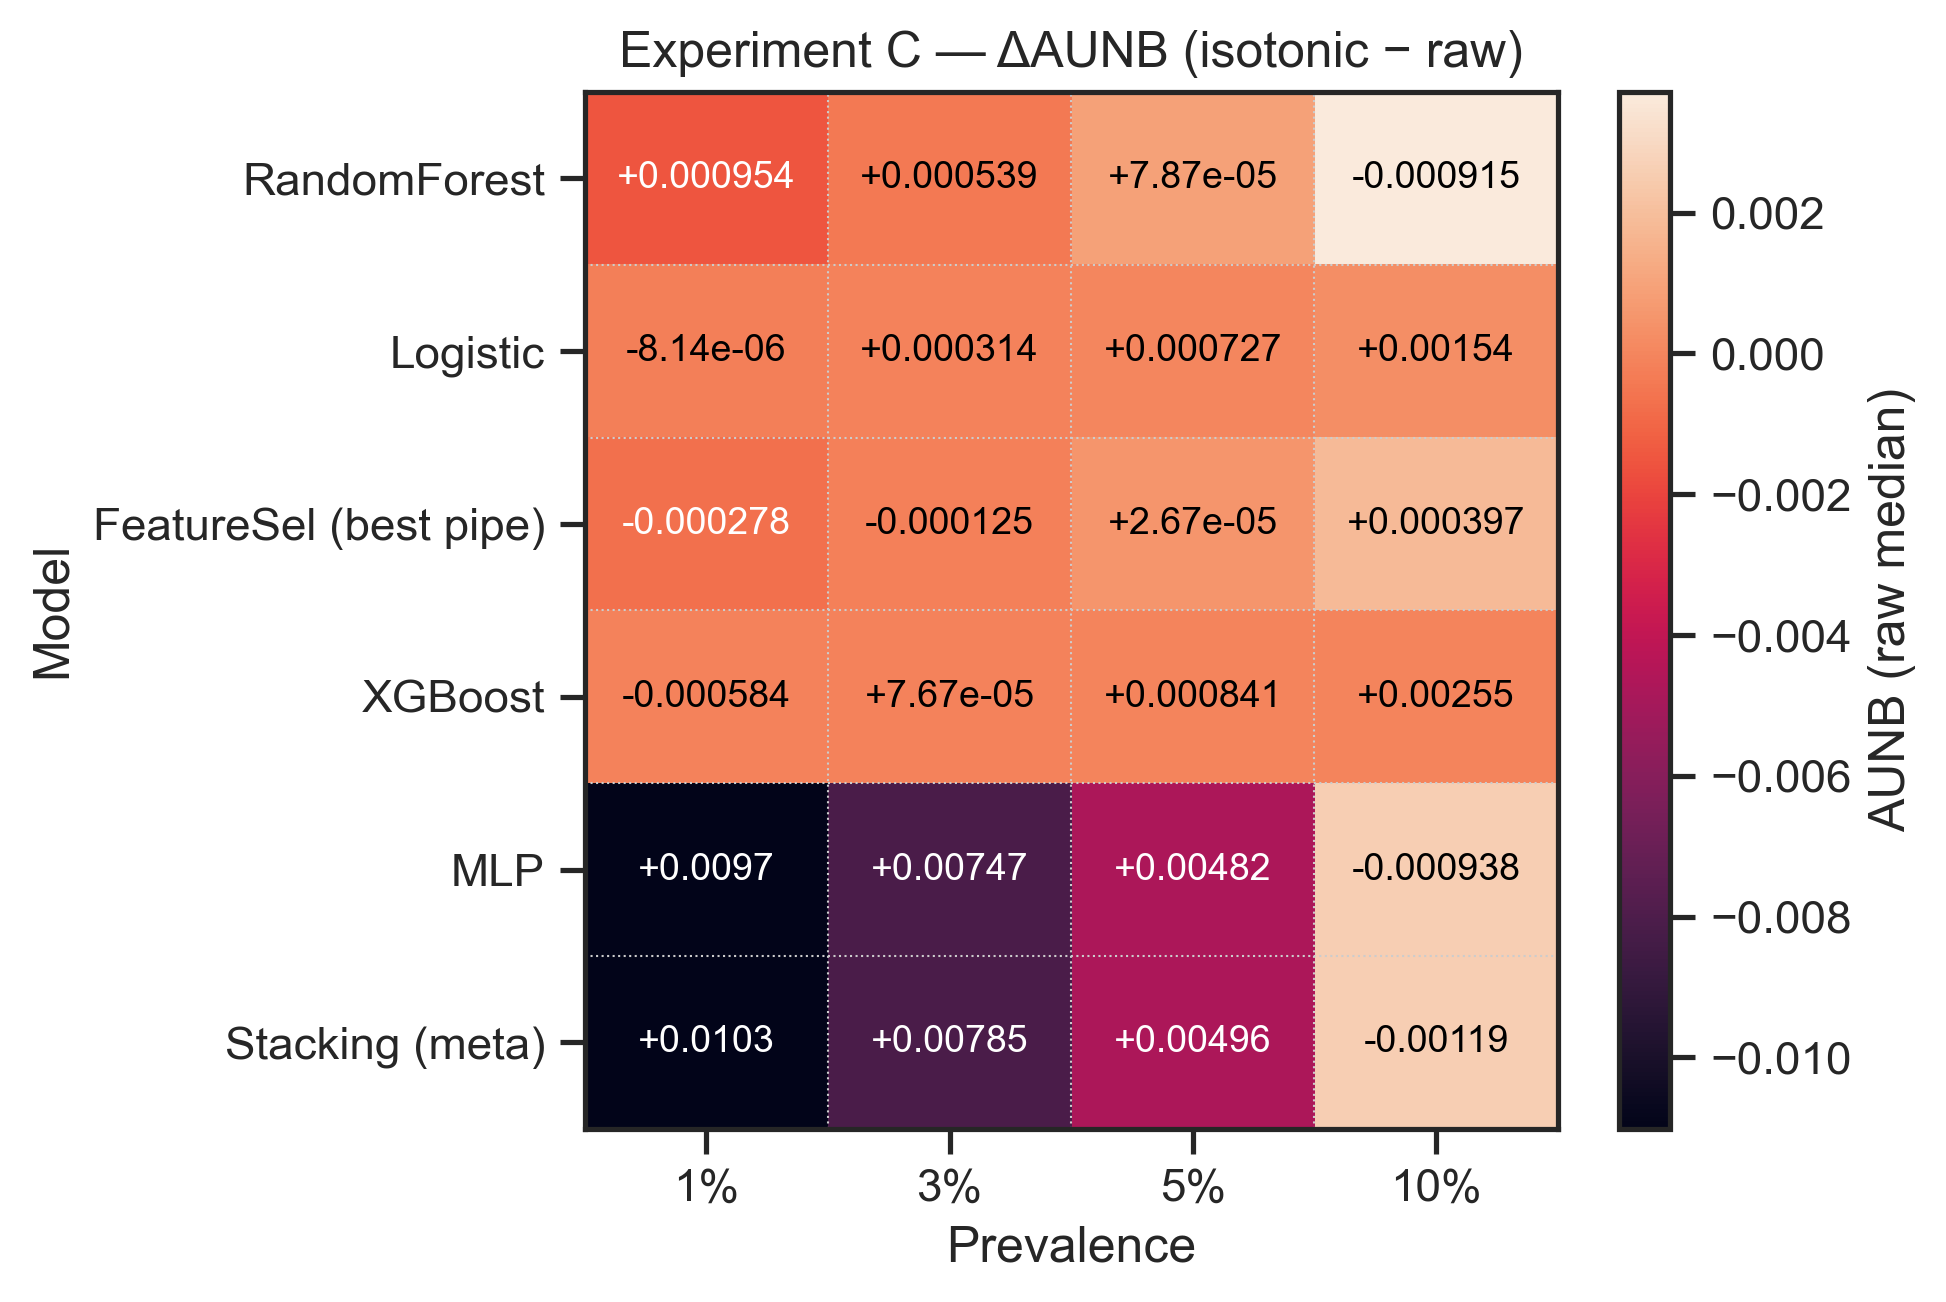

0.01    0.03    0.05    0.10
RandomForest            0.0010  0.0005  0.0001 -0.0009
Logistic               -0.0000  0.0003  0.0007  0.0015
FeatureSel (best pipe) -0.0003 -0.0001  0.0000  0.0004
XGBoost                -0.0006  0.0001  0.0008  0.0026
MLP                     0.0097  0.0075  0.0048 -0.0009
Stacking (meta)         0.0103  0.0078  0.0050 -0.0012

In [33]:
# === 2D heatmap of ΔAUNB (isotonic − raw), numbers in each cell, no arrows ===
from matplotlib import cm
def plot_aunb_heatmap(
    aunb_raw_dict,
    aunb_iso_dict,
    title="Experiment C — ΔAUNB (iso − raw)",
    outfile=None,
    model_order=None,
    background="raw",      # "raw" or "iso" heatmap background
    values="delta",        # numbers shown in cells: "delta" | "raw" | "iso"
    fmt_delta="+.3g",      # format for delta numbers
    fmt_bg=".3g"           # format for raw/iso numbers
):
    """Prevalence × model heatmap. Numbers per cell. No arrows."""

    # --- normalize prevalence keys (accept 0.05, 5, "5%") ---
    def _to_float_prev(k):
        if isinstance(k, (int, float, np.integer, np.floating)):
            v = float(k); return v/100.0 if v > 1.0 else v
        v = float(str(k).strip().replace("%",""))
        return v/100.0 if v > 1.0 else v

    def _as_label(p): return f"{int(round(p*100))}%"

    def _standardize(d):
        out = {}
        for k, df in d.items():
            p = _to_float_prev(k)
            if df is None or df.empty:
                continue
            cols = {c.lower(): c for c in df.columns}
            if "model" not in cols or "median" not in cols:
                raise ValueError("Each AUNB table must have columns 'Model' and 'median'.")
            out[p] = (df[[cols["model"], cols["median"]]]
                        .rename(columns={cols["model"]: "Model", cols["median"]: "median"})
                        .dropna())
        return out

    raw = _standardize(aunb_raw_dict)
    iso = _standardize(aunb_iso_dict)
    prevalences = sorted(set(raw) | set(iso))
    if not prevalences:
        raise ValueError("No prevalences found. Run Experiment C first.")

    models = sorted(
        set().union(*[set(df["Model"]) for df in raw.values()] if raw else [set()],
                    *[set(df["Model"]) for df in iso.values()] if iso else [set()])
    )
    if not models:
        raise ValueError("No models found in AUNB tables.")

    if model_order:
        models = [m for m in model_order if m in models] + [m for m in models if m not in (model_order or [])]

    # matrices (rows=models, cols=prevalences)
    R = pd.DataFrame(index=models, columns=prevalences, dtype=float)
    I = pd.DataFrame(index=models, columns=prevalences, dtype=float)

    for p in prevalences:
        if p in raw:
            R[p] = raw[p].set_index("Model")["median"].reindex(models).astype(float)
        if p in iso:
            I[p] = iso[p].set_index("Model")["median"].reindex(models).astype(float)

    D = I - R
    B = I if background == "iso" else R  # heatmap background matrix
    V = {"delta": D, "raw": R, "iso": I}[values]  # numbers to print

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(max(6.5, 0.75*len(prevalences)+1),
                                    max(4.5, 0.45*len(models)+1)))

    im = ax.imshow(B.values, aspect="auto", interpolation="nearest")
    ax.set_xticks(np.arange(len(prevalences)))
    ax.set_yticks(np.arange(len(models)))
    ax.set_xticklabels([_as_label(p) for p in prevalences])
    ax.set_yticklabels(models)
    ax.set_xlabel("Prevalence")
    ax.set_ylabel("Model")
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"AUNB ({'iso' if background=='iso' else 'raw'} median)")

    # numbers in cells with auto-contrast
    vmin = np.nanmin(B.values) if np.isfinite(B.values).any() else 0.0
    vmax = np.nanmax(B.values) if np.isfinite(B.values).any() else 1.0
    cmap = im.get_cmap() if hasattr(im, "get_cmap") else cm.get_cmap()

    def _text_color(bval):
        if not np.isfinite(bval) or vmax == vmin:
            return "black"
        t = (bval - vmin) / (vmax - vmin + 1e-12)
        r, g, b, _ = cmap(t)
        # perceived luminance
        L = 0.299*r + 0.587*g + 0.114*b
        return "black" if L > 0.6 else "white"

    n_rows, n_cols = B.shape
    for r in range(n_rows):
        for c in range(n_cols):
            val_print = V.iat[r, c]
            bg_val = B.iat[r, c]
            if not np.isfinite(val_print):
                continue
            txt = format(val_print, fmt_delta if values == "delta" else fmt_bg)
            ax.text(c, r, txt, ha="center", va="center",
                    fontsize=9, color=_text_color(bg_val))

    # grid
    ax.set_xticks(np.arange(-0.5, len(prevalences), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(models), 1), minor=True)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()

    # safe save
    if outfile:
        outpath = Path(outfile)
        try:
            outdir = outpath.parent
            if str(outdir) in {"", ".", None}:
                outdir = Path("./results")
            outdir.mkdir(parents=True, exist_ok=True)
            plt.savefig(outdir / outpath.name, dpi=300, bbox_inches="tight")
            print("Saved figure to:", outdir / outpath.name)
        except Exception as e:
            print(f"[warn] Could not save to {outfile} ({e}). Showing only.")
    plt.show()
    return D

# -------- Build inputs from EXP_C and plot --------
assert "EXP_C" in globals() and isinstance(EXP_C, dict), "Run Experiment C first."

aunb_raw_dict = {}
aunb_iso_dict  = {}
for prev, pack in EXP_C.items():
    df_r = pack.get("aunb_raw", pd.DataFrame())
    df_i = pack.get("aunb_iso", pd.DataFrame())
    if not df_r.empty:
        aunb_raw_dict[prev] = df_r[["Model","median"]]
    if not df_i.empty:
        aunb_iso_dict[prev] = df_i[["Model","median"]]

preferred_order = [
    "RandomForest", "Logistic", "FeatureSel (best pipe)",
    "XGBoost", "MLP", "Stacking (meta)"
]

D = plot_aunb_heatmap(
        aunb_raw_dict,
        aunb_iso_dict,
        title="Experiment C — ΔAUNB (isotonic − raw)",
        outfile=Path("./results/aunb_delta_heatmap.png"),
        model_order=preferred_order,
        background="raw",   # heatmap shows raw AUNB
        values="delta"      # numbers are ΔAUNB (iso − raw)
)

display(pd.DataFrame(D).round(4))

#### Experiment D — Alarm-load frontier (FP per 1000 wafers vs Recall)

Saved figure to: ../results/alarm_frontier.png


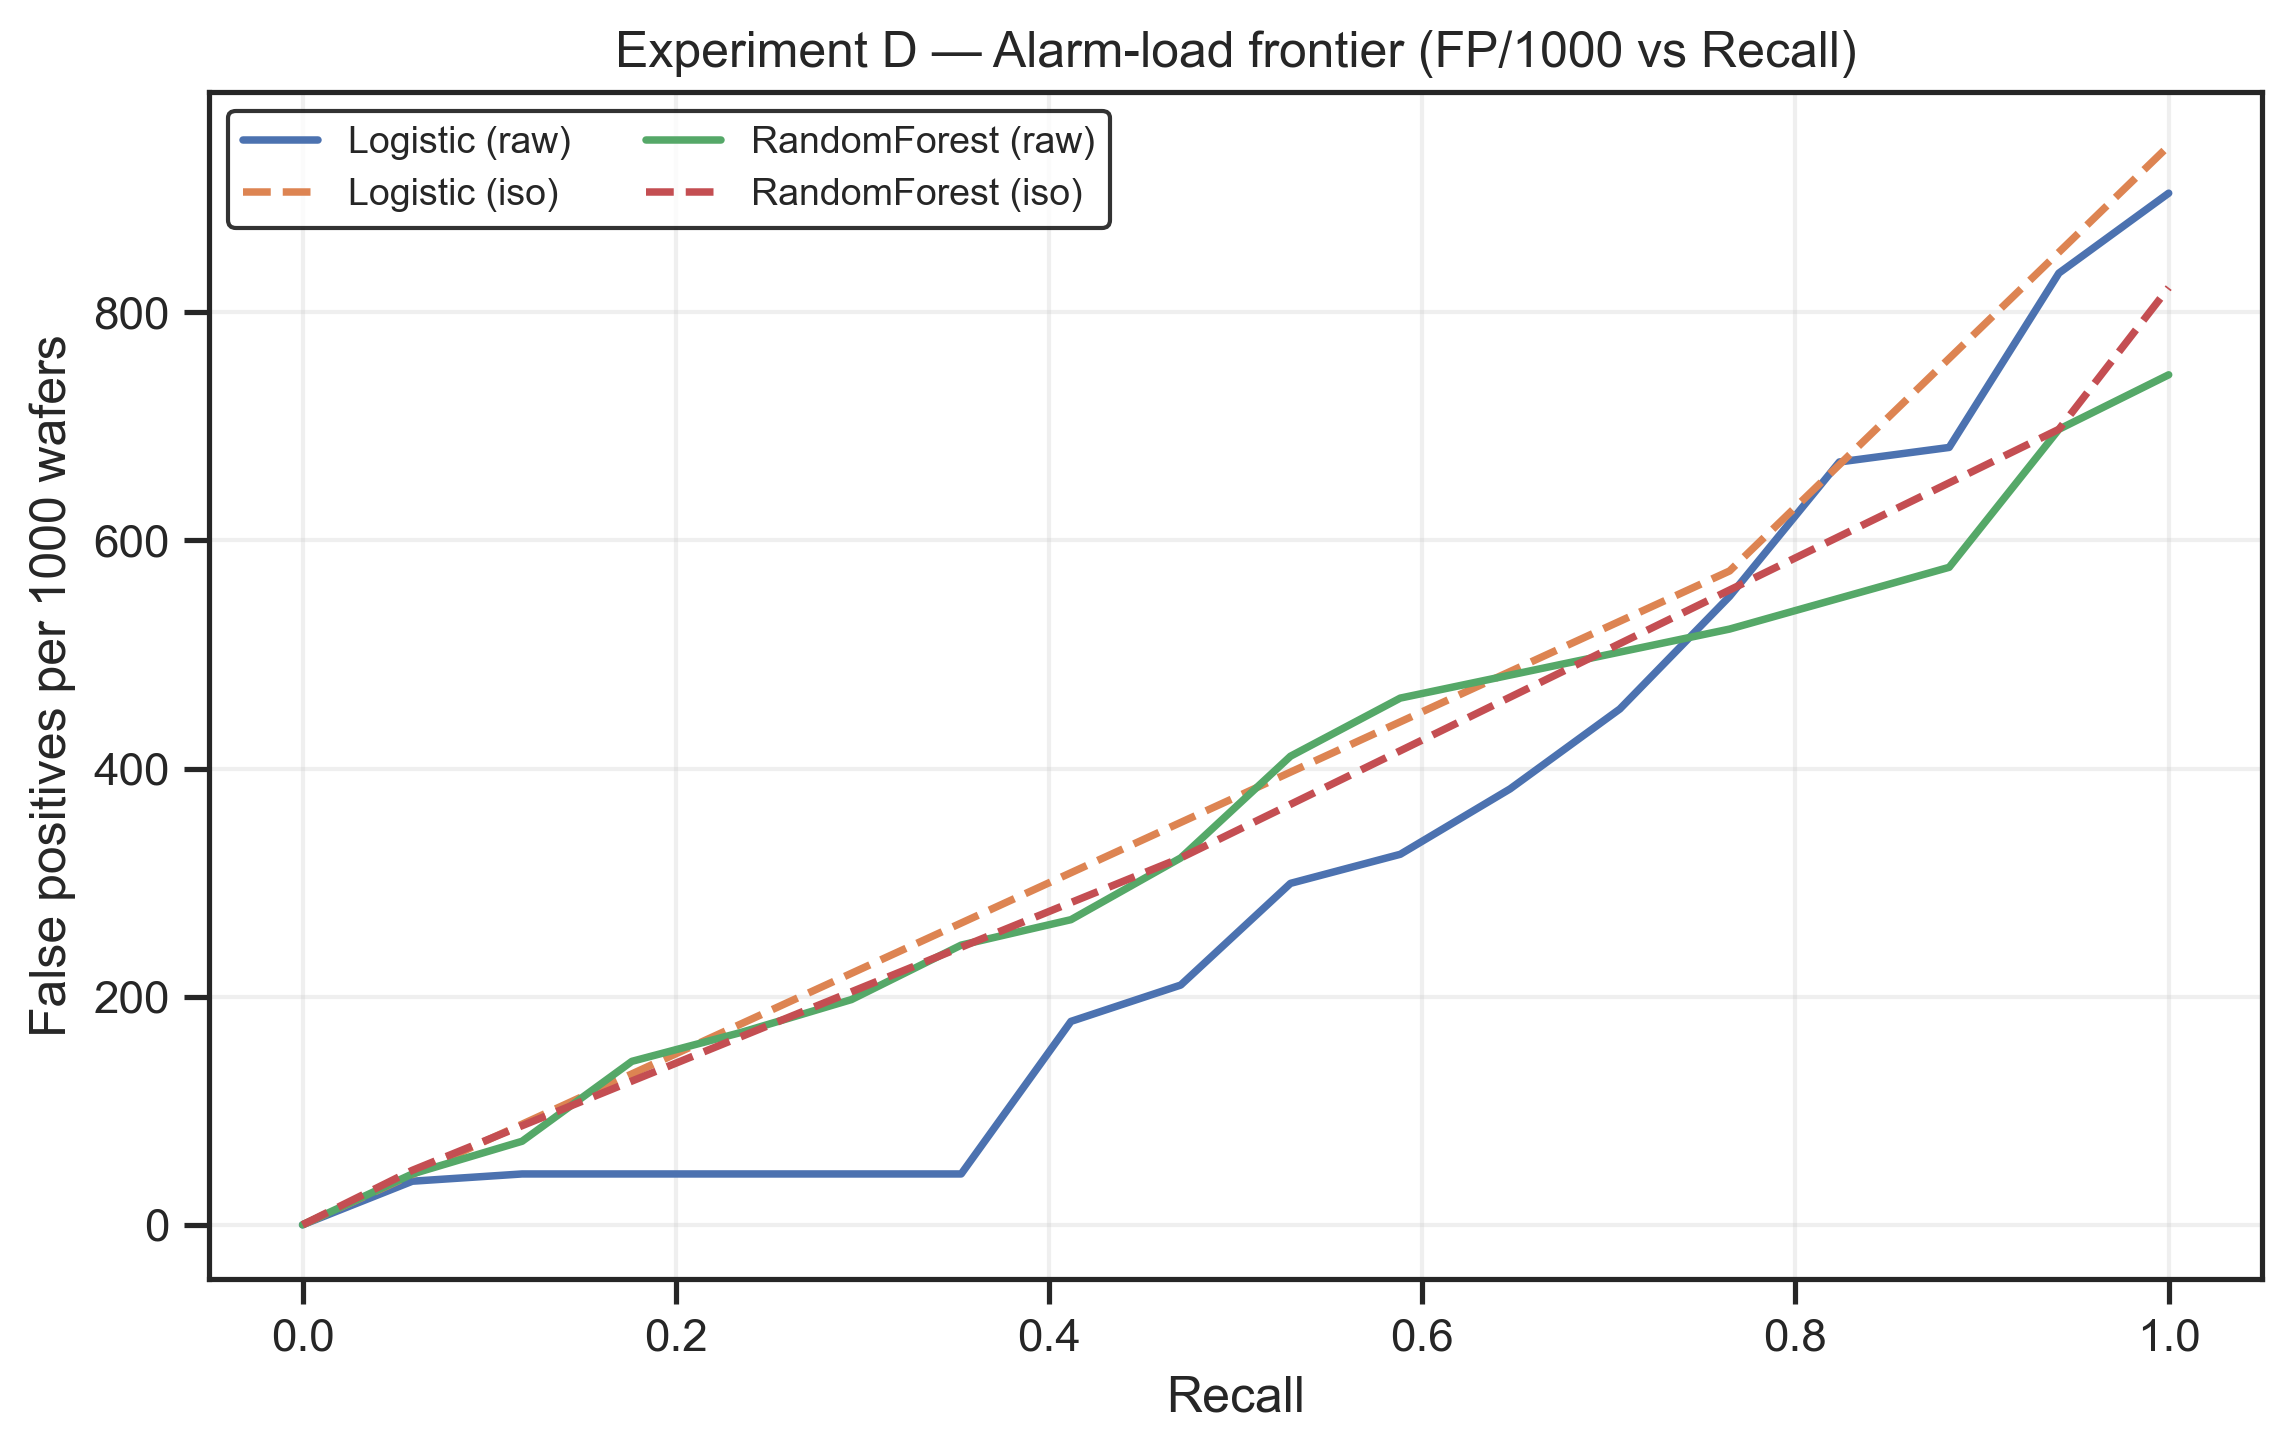

In [34]:
# === Experiment D — Alarm-load frontier (FP per 1000 wafers vs Recall) ===

# Helpers
def fp_per_1000(y, pred):
    """False positives per 1000 wafers."""
    y = np.asarray(y, int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    N = len(y)
    return 1000.0 * (fp / N)

def curve_fp1000_vs_recall(y, p, strategy="pr_thresholds"):
    """
    Return arrays (recall, fp_per_1000) by sweeping thresholds.
    strategy:
      - 'pr_thresholds': use PR-curve thresholds (recommended)
      - 'linspace': uniform thresholds in [0,1]
    """
    y = np.asarray(y, int); p = np.asarray(p, float)
    if strategy == "pr_thresholds":
        P, R, T = precision_recall_curve(y, p)
        thr = np.r_[T, 1.0]  # align to length of R
    else:
        thr = np.linspace(0.0, 1.0, 501)
        # compute recall separately below

    rec_list, fp1k_list = [], []
    for t in thr:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        rec_list.append(rec)
        fp1k_list.append(1000.0 * fp / len(y))
    r = np.asarray(rec_list, float)
    f = np.asarray(fp1k_list, float)

    # keep Pareto frontier: for each recall keep min FP/1000
    # bin by recall to smooth jagged duplicates
    bins = np.linspace(0, 1, 201)
    idx = np.digitize(r, bins, right=True)
    best = {}
    for i, b in enumerate(idx):
        if b not in best or f[i] < best[b][1]:
            best[b] = (r[i], f[i])
    out = np.array(sorted(best.values(), key=lambda x: x[0]))
    return out[:,0], out[:,1]

def plot_alarm_frontier(models=("Logistic","RandomForest"),
                        calibrated_modes=("raw","iso"),
                        title="Experiment D — Alarm-load frontier (FP/1000 vs Recall)",
                        outfile=RESULT_DIR/"alarm_frontier.png"):
    plt.figure(figsize=(7.8, 5.0))
    styles = {("raw"): "-", ("iso"): "--"}
    for m in models:
        for cal in calibrated_modes:
            p = get_probs(m, split="test", calibrated=cal)
            if p is None: 
                continue
            r, f = curve_fp1000_vs_recall(yte, p, strategy="pr_thresholds")
            lbl = f"{m} ({cal})"
            plt.plot(r, f, styles[cal], lw=1.8, label=lbl)
    plt.xlabel("Recall")
    plt.ylabel("False positives per 1000 wafers")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    print("Saved figure to:", outfile)
    plt.show()

plot_alarm_frontier()

In [36]:
# Optional: numeric summary at target recall levels
TARGET_RECALL = [0.10, 0.20, 0.30]

def nearest_fp1k_at_recall(y, p, r_target):
    r, f = curve_fp1000_vs_recall(y, p)
    if len(r) == 0: 
        return np.nan
    j = int(np.argmin(np.abs(r - r_target)))
    return float(f[j])

rows = []
for m in ("Logistic","RandomForest"):
    for cal in ("raw","iso"):
        p = get_probs(m, split="test", calibrated=cal)
        if p is None: 
            continue
        for rt in TARGET_RECALL:
            fp1k = nearest_fp1k_at_recall(yte, p, rt)
            rows.append({"Model": m, "Calib": cal, "Recall_target": rt, "FP_per_1000": fp1k})

df_frontier = pd.DataFrame(rows)
# wide view with delta (iso - raw)
wide = (df_frontier
        .pivot_table(index=["Model","Recall_target"], columns="Calib", values="FP_per_1000")
        .reindex(columns=["raw","iso"]))
wide["ΔFP/1000 (iso-raw)"] = wide["iso"] - wide["raw"]
display(wide.round(2))

Calib                          raw     iso  ΔFP/1000 (iso-raw)
Model        Recall_target                                    
Logistic     0.1             44.59    0.00              -44.59
             0.2             44.59    0.00              -44.59
             0.3             44.59    0.00              -44.59
RandomForest 0.1             73.25   47.77              -25.48
             0.2            143.31   47.77              -95.54
             0.3            197.45  321.66              124.20

Saved: ../results/alarm_frontier_Logistic.png


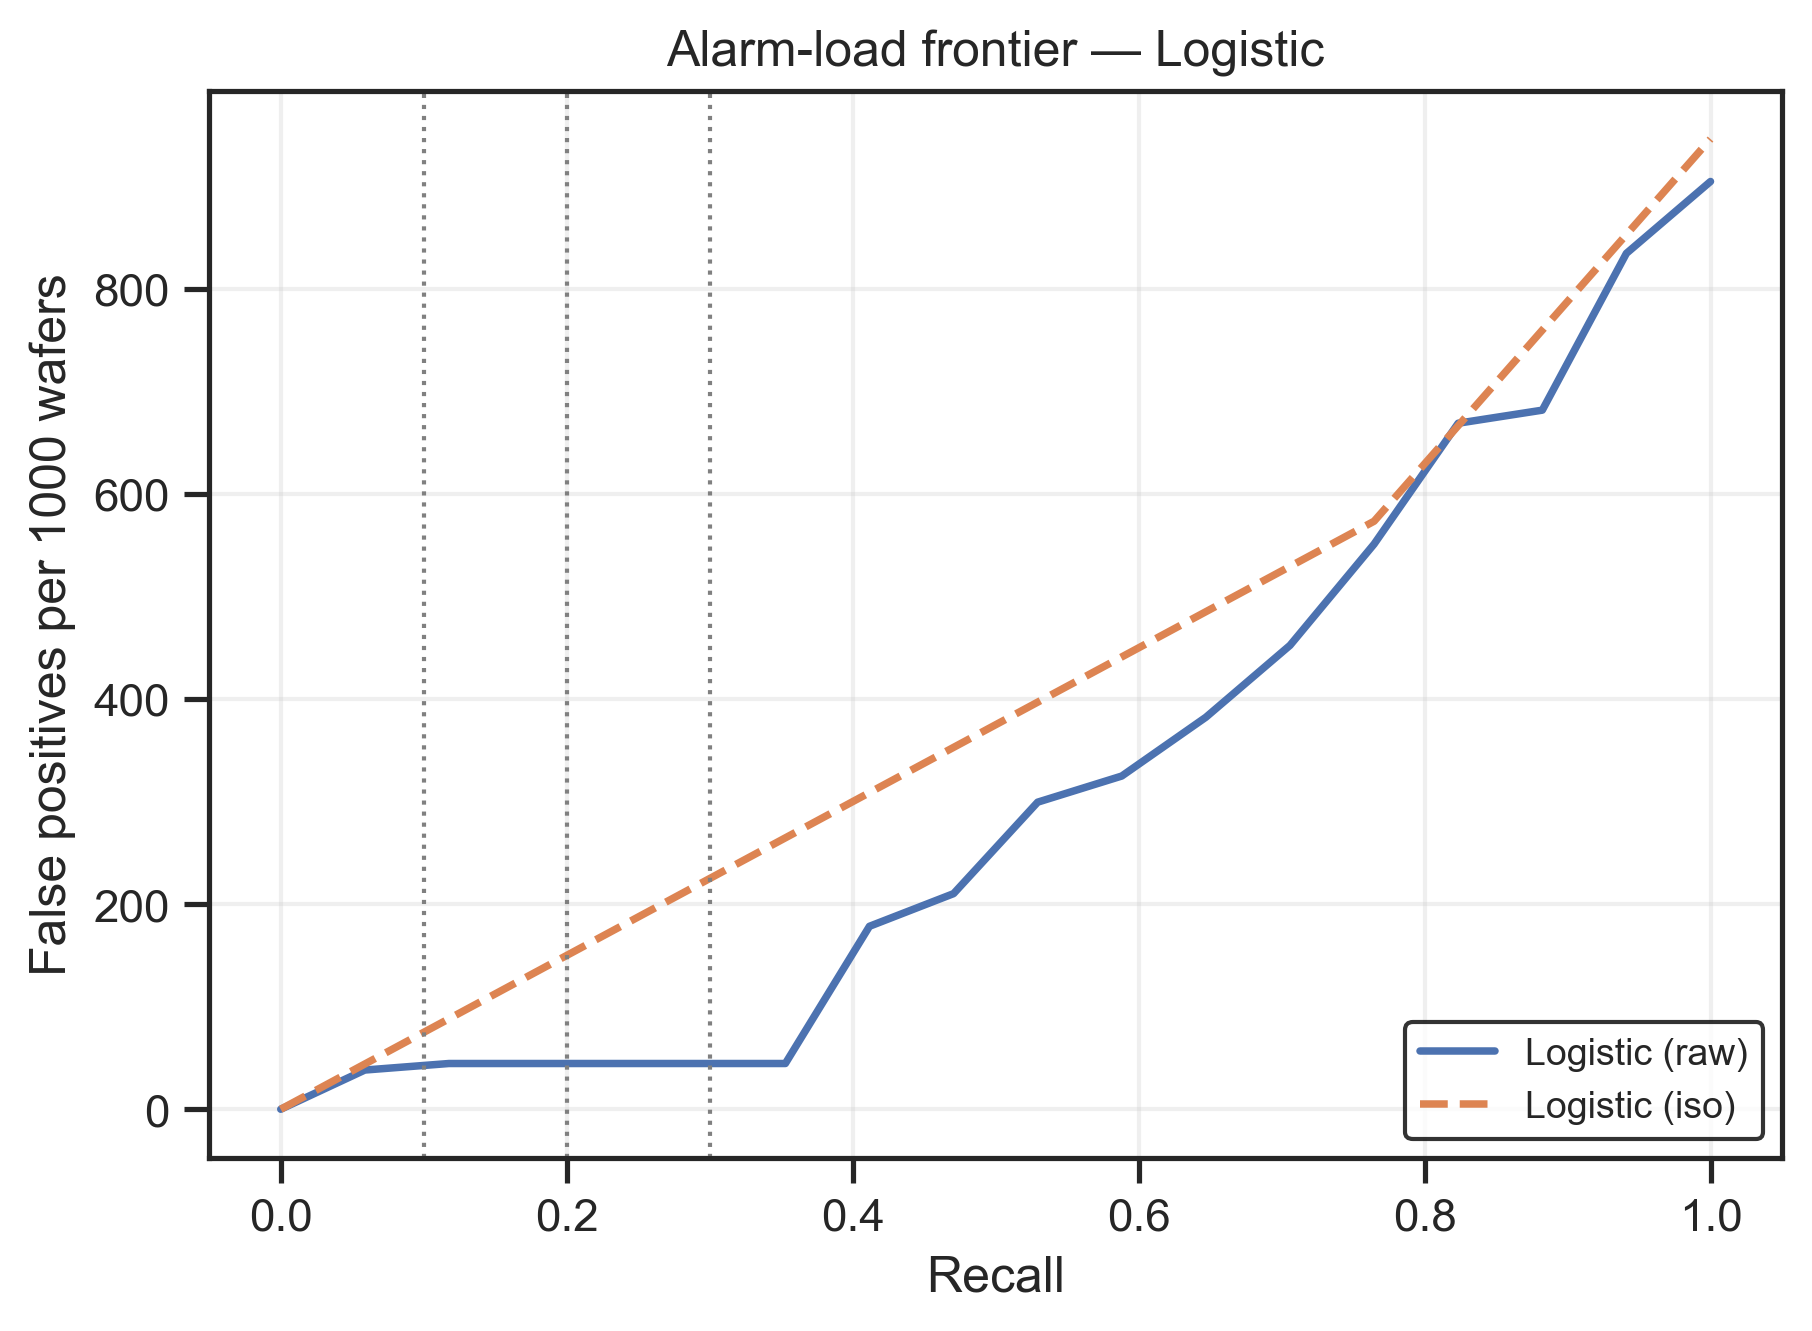

Saved: ../results/alarm_frontier_RandomForest.png


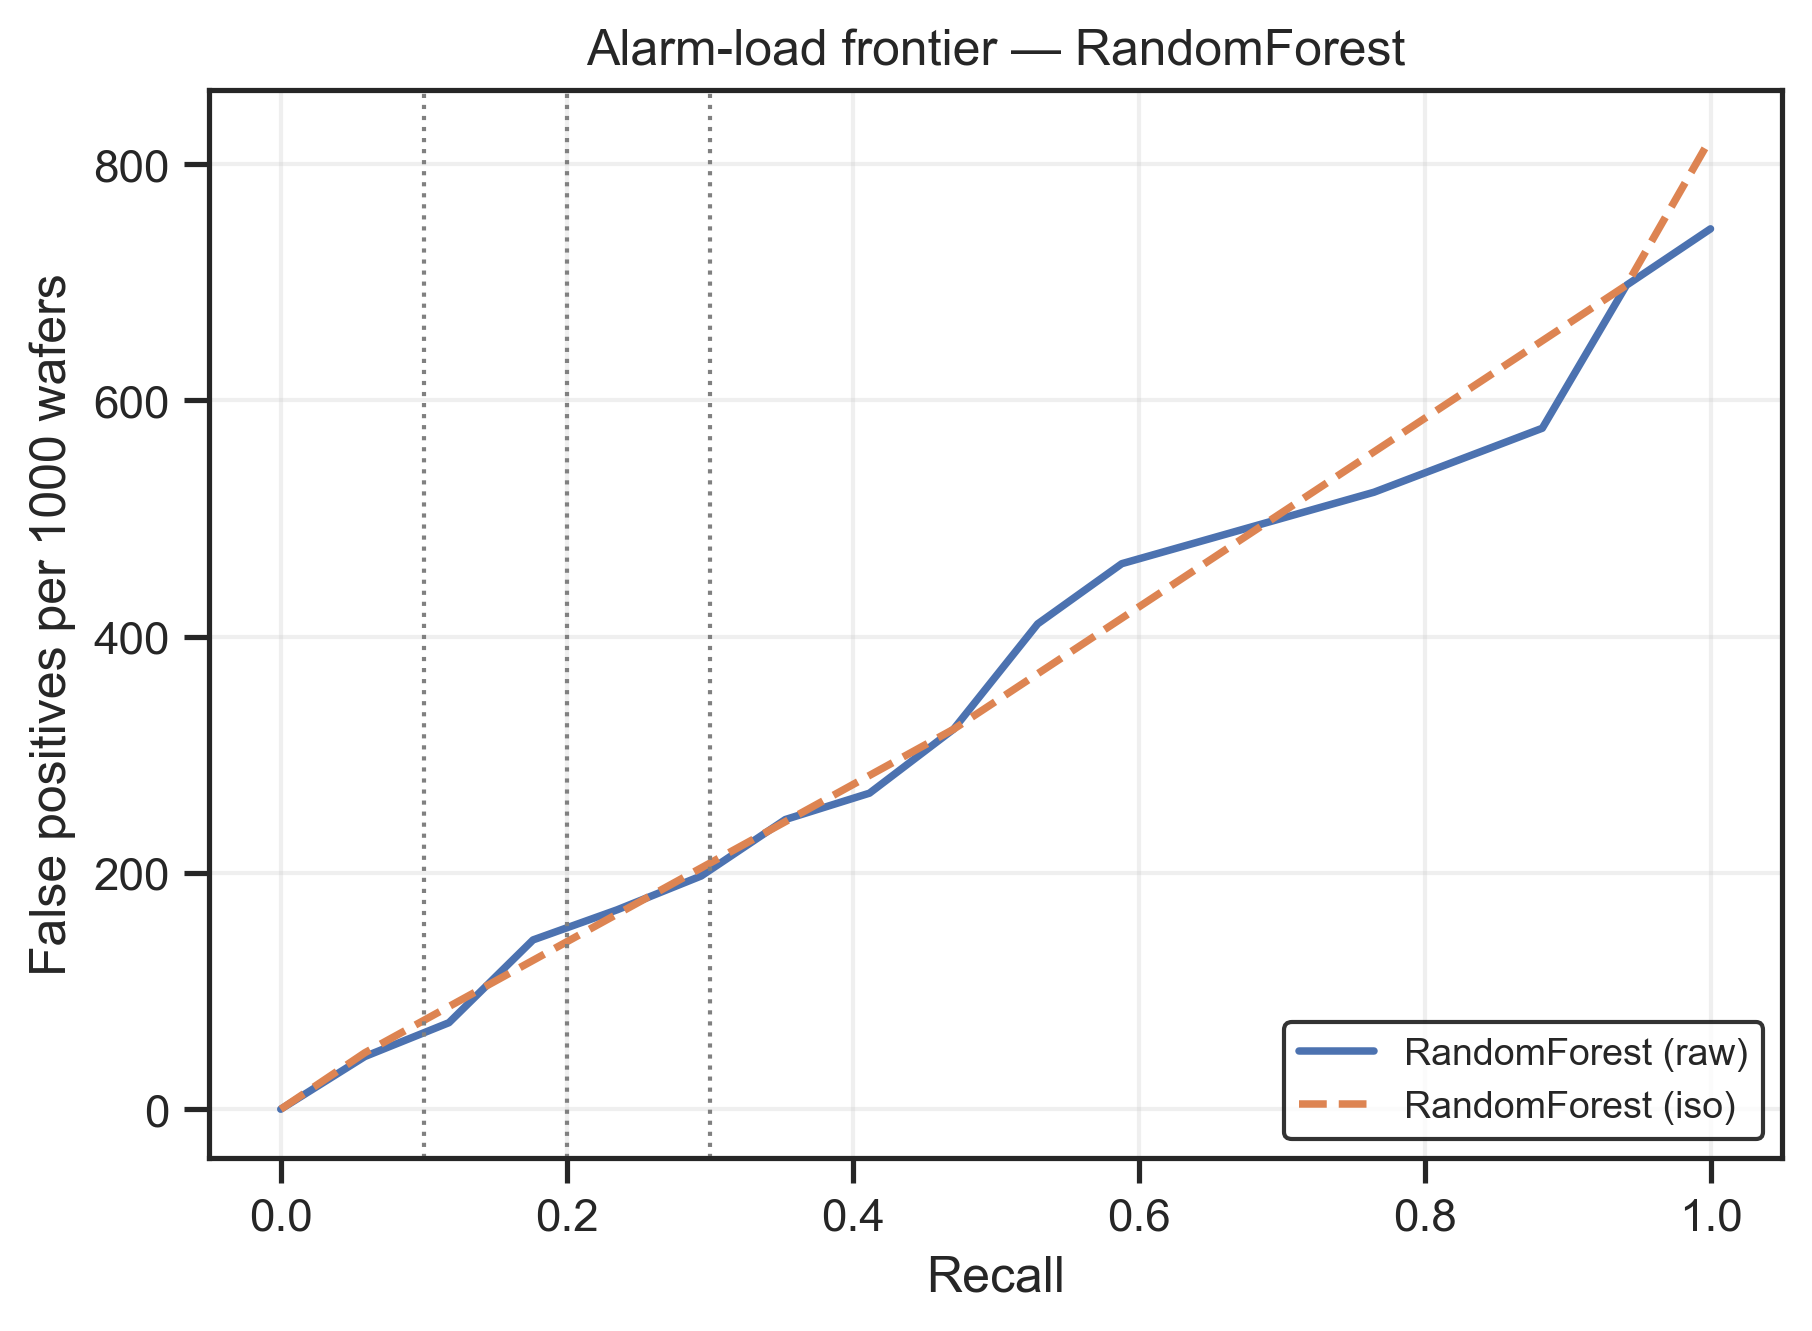

In [37]:
# Optional: per-model overlay plots for report
def plot_per_model_frontier(model, outfile=None):
    plt.figure(figsize=(6.2, 4.6))
    for cal, style in (("raw","-"), ("iso","--")):
        p = get_probs(model, split="test", calibrated=cal)
        if p is None: 
            continue
        r, f = curve_fp1000_vs_recall(yte, p)
        plt.plot(r, f, style, lw=1.8, label=f"{model} ({cal})")
    for rt in TARGET_RECALL:
        plt.axvline(rt, ls=":", color="gray", lw=1)  # guide
    plt.xlabel("Recall"); plt.ylabel("False positives per 1000 wafers")
    plt.title(f"Alarm-load frontier — {model}")
    plt.grid(True, alpha=0.3); plt.legend(fontsize=9)
    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches="tight")
        print("Saved:", outfile)
    plt.show()

for m in ("Logistic","RandomForest"):
    plot_per_model_frontier(m, outfile=RESULT_DIR/f"alarm_frontier_{m}.png")

### Experiment D — Alarm-Load Frontier (FP/1000 vs Recall)

We compared **raw vs isotonic** probabilities for Logistic Regression and RandomForest, plotting **false positives per 1,000 wafers vs recall**.

#### Observations

- **Logistic Regression**
  - Frontier: isotonic curve lies above raw → recall grows smoothly but at the cost of many extra alarms.
  - Table confirms: isotonic = **0 FP/1000** at recalls 0.1–0.3, but recall rises slowly (flat segment).  
  - Raw logistic achieves the same recall with ~45 FP/1000 — sharper recall gain, more alarms.

- **RandomForest**
  - At **low recall (0.1–0.2)** isotonic reduces FP load (–25 to –95 FP/1000 vs raw).
  - At **0.3 recall**, isotonic flips → **+124 FP/1000** worse than raw.
  - Shows calibration changes the frontier shape: smoother at first, then costlier.

#### Numeric summary (FP/1000 @ recall targets)

| Model        | Recall=0.1 | Recall=0.2 | Recall=0.3 |
|--------------|------------|------------|------------|
| Logistic raw | 44.6       | 44.6       | 44.6       |
| Logistic iso | 0.0        | 0.0        | 0.0        |
| Δ iso–raw    | –44.6      | –44.6      | –44.6      |
| RF raw       | 73.3       | 143.3      | 197.5      |
| RF iso       | 47.8       | 47.8       | 321.7      |
| Δ iso–raw    | –25.5      | –95.5      | +124.2     |

#### Key Outcomes

- **Calibration helps at low-recall operating points**: fewer false alarms for the same detection.  
- **But beyond recall ~0.3, isotonic can worsen alarm load**, especially for RandomForest.  
- Operationally:  
  - For fabs targeting **very conservative recall (≤0.2)**, isotonic is attractive (cuts alarms).  
  - For **moderate recall (~0.3+)**, raw RandomForest is safer and cheaper.

**Executive takeaway:**  
Calibration reshapes alarm-load trade-offs. It can reduce alarms at low recall but may backfire at higher recall. For fab practice, choose calibration only if operating points stay in the low-recall band.

## Executive Digest — Calibration & Cost-Sensitive Evaluation (SECOM)

### Core Findings (Experiments A–D)

- **A. Crossover Shift**
  - Isotonic calibration moves RandomForest takeover **earlier** (19:1 --> 13:1 FN:FP).
  - Logistic baseline weakens; FeatureSel enters as minor competitor.

- **B. Robustness (Bootstrap)**
  - Crossovers stable across bootstraps (RF ~15–17).
  - Calibration does **not materially change** winner bands.

- **C. Prevalence Shift**
  - At 1–3% prevalence: Logistic dominates low ratios; RF wins beyond ~12.
  - At 5–10% prevalence: FeatureSel & MLP appear; RF remains all-rounder.
  - Calibration modestly **improves AUNB** at higher prevalence.

- **D. Alarm-Load Frontier**
  - Calibration cuts **FP/1000 at low recall (≤0.2)** for Logistic and RF.
  - Beyond recall ~0.3, isotonic worsens alarm load (RF +124 FP/1000).
  - **Raw RF safer** when fabs demand moderate–high recall.


### Operational Takeaways
- **RandomForest = reliable choice** across ratios, prevalence, and calibration settings.  
- **Logistic** only safe in low FN cost scenarios and ultra-rare prevalence.  
- **Calibration**:  
  - Valuable for **probability reliability** (Brier decreses).  
  - Useful at **low recall** (fewer alarms).  
  - Risky at **moderate–high recall** (extra false alarms).  
- **FeatureSel / MLP** only matter if prevalence rises ≥10%.


**Bottom line:**  
For fab operations, use **raw RandomForest** as the default cost-optimal model. Apply isotonic calibration **only when the fab operates at very low recall thresholds or requires probability reliability for risk scoring**.

Saved: ../results/executive_digest_AtoD_true.png


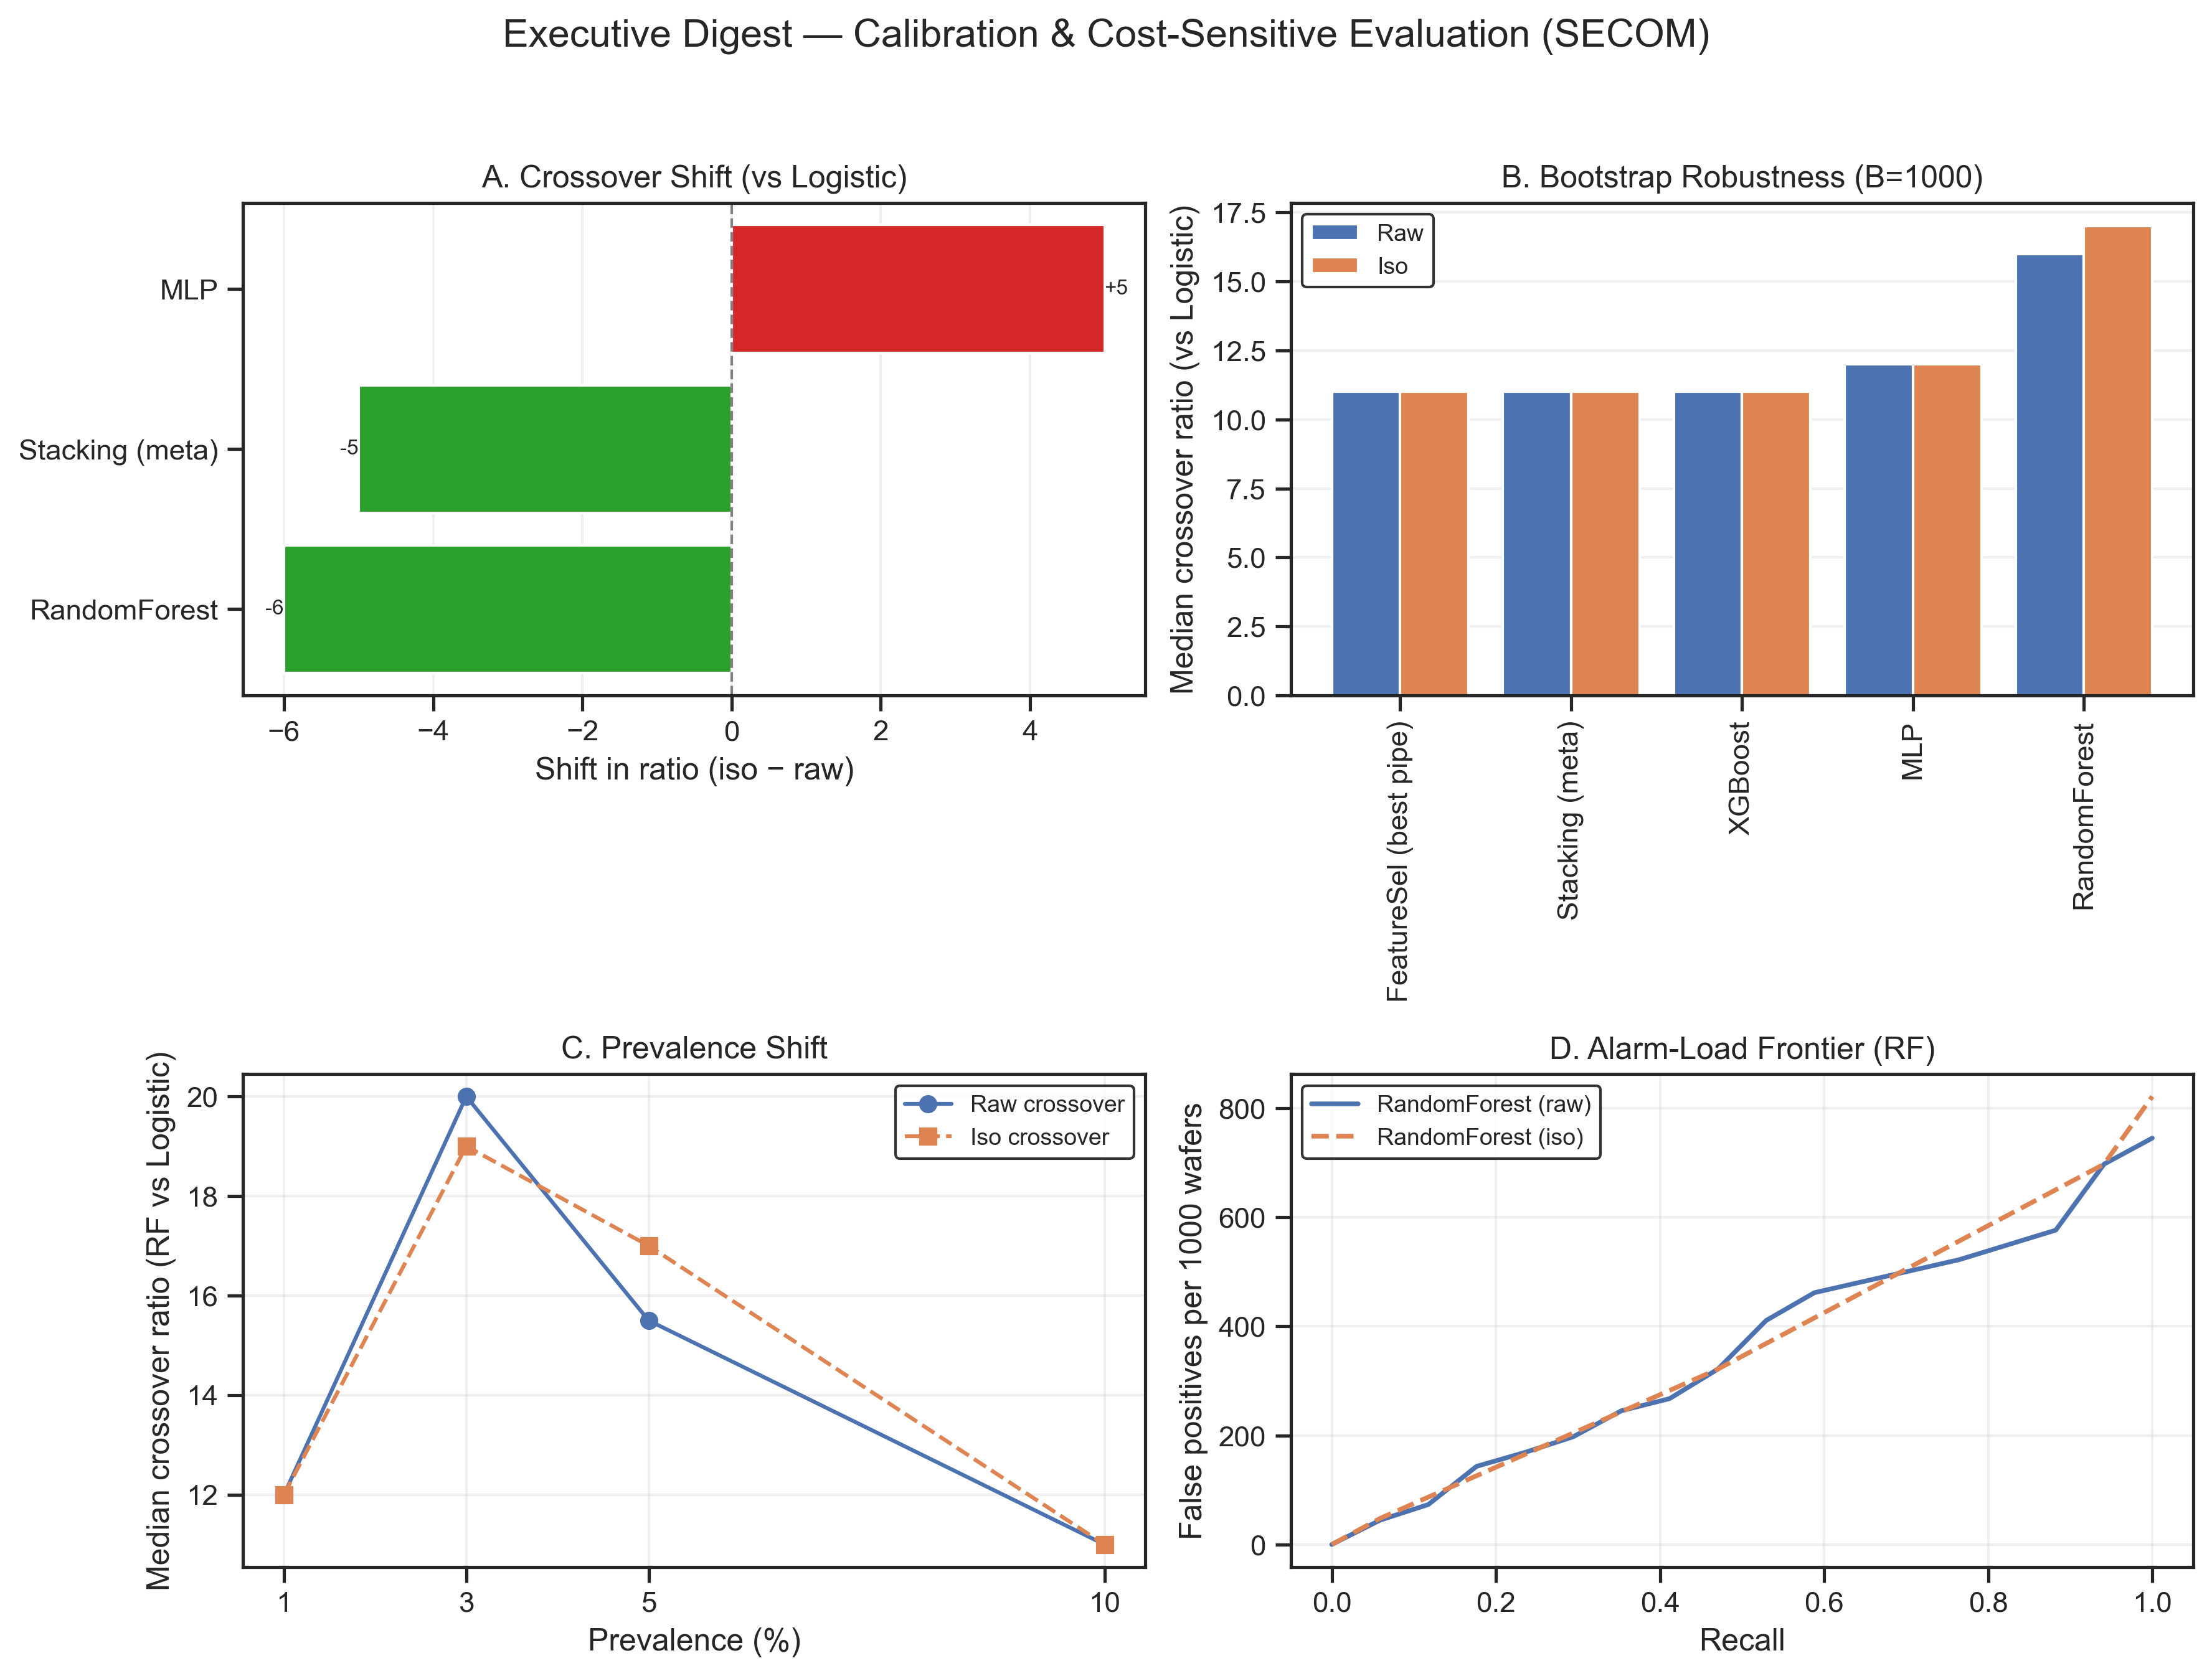

In [42]:
# === Executive Digest (A–D) — Fully data-driven ===
# Requirements (from your notebook):
# - Experiment A table:        `tab` with columns ["Model","Raw_crossover","Iso_crossover","Shift_in_ratio"]
# - Experiment B summaries:    `summaries` dict keyed by B with 'xover_raw'/'xover_iso' (Median per Model)
# - Experiment C prevalence:   `EXP_C` dict with per-prev 'xover_raw'/'xover_iso' (Median per Model)
# - Experiment D helpers:      `curve_fp1000_vs_recall`, `get_probs`, `yte`
# - Paths:                     `RESULT_DIR`

# -------- Panel A: Crossover shift (iso − raw) vs Logistic, from Experiment A `tab`
def panel_A(ax):
    if 'tab' not in globals() or tab is None or tab.empty:
        ax.text(0.5, 0.5, "Experiment A results not found", ha="center", va="center")
        ax.axis("off"); return

    dfA = tab.copy()
    # Numeric shifts only
    df_num = dfA[pd.to_numeric(dfA["Shift_in_ratio"], errors="coerce").notna()].copy()
    df_num["Shift_in_ratio"] = df_num["Shift_in_ratio"].astype(float)
    if df_num.empty:
        ax.text(0.5, 0.5, "No numeric crossovers to display", ha="center", va="center")
        ax.axis("off"); return

    df_num = df_num.sort_values("Shift_in_ratio")
    colors = np.where(df_num["Shift_in_ratio"] < 0, "tab:green", "tab:red")
    ax.barh(df_num["Model"], df_num["Shift_in_ratio"], color=colors)
    ax.axvline(0, color="gray", ls="--", lw=1)
    ax.set_xlabel("Shift in ratio (iso − raw)"); ax.set_title("A. Crossover Shift (vs Logistic)")
    ax.grid(True, axis="x", alpha=0.3)

    # Optional annotations
    for y, v in enumerate(df_num["Shift_in_ratio"].to_numpy()):
        ax.text(v, y, f"{v:+.0f}", va="center",
                ha="left" if v>=0 else "right", fontsize=8)

# -------- Panel B: Bootstrap robustness — median crossover ratio (vs Logistic), from `summaries`
def panel_B(ax):
    if 'summaries' not in globals() or not isinstance(summaries, dict) or not summaries:
        ax.text(0.5, 0.5, "Experiment B summaries not found", ha="center", va="center")
        ax.axis("off"); return

    # pick the largest B that exists
    B_pick = max(summaries.keys())
    sx = summaries[B_pick]
    xr = sx.get("xover_raw", pd.DataFrame())
    xi = sx.get("xover_iso", pd.DataFrame())
    if xr is None or xi is None or xr.empty or xi.empty:
        ax.text(0.5, 0.5, "Missing xover medians", ha="center", va="center")
        ax.axis("off"); return

    # Merge medians for models present in either; drop Logistic and non-numeric
    def clean(df):
        d = df.copy()
        d = d[pd.to_numeric(d["Median"], errors="coerce").notna()]
        d["Median"] = d["Median"].astype(float)
        return d[~d["Model"].str.contains("^Logistic$", case=False, na=False)]

    xr = clean(xr).rename(columns={"Median":"Raw"})
    xi = clean(xi).rename(columns={"Median":"Iso"})
    m = pd.merge(xr[["Model","Raw"]], xi[["Model","Iso"]], on="Model", how="outer").dropna()

    if m.empty:
        ax.text(0.5, 0.5, "No common models with medians", ha="center", va="center")
        ax.axis("off"); return

    m = m.sort_values("Raw")
    x = np.arange(len(m))
    ax.bar(x-0.2, m["Raw"], width=0.4, label="Raw")
    ax.bar(x+0.2, m["Iso"], width=0.4, label="Iso")
    ax.set_xticks(x); ax.set_xticklabels(m["Model"], rotation=90)
    ax.set_ylabel("Median crossover ratio (vs Logistic)")
    ax.set_title(f"B. Bootstrap Robustness (B={B_pick})")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(fontsize=9)

# -------- Panel C: Prevalence shift — RF vs Logistic median crossover across prevalences, from `EXP_C`
def panel_C(ax):
    if 'EXP_C' not in globals() or not isinstance(EXP_C, dict) or not EXP_C:
        ax.text(0.5, 0.5, "Experiment C results not found", ha="center", va="center")
        ax.axis("off"); return

    prevs = []
    rf_raw = []
    rf_iso = []
    for prev, pack in sorted(EXP_C.items(), key=lambda kv: float(kv[0])):
        xr = pack.get("xover_raw", pd.DataFrame())
        xi = pack.get("xover_iso", pd.DataFrame())
        def get_med(df, model="RandomForest"):
            if df is None or df.empty: return np.nan
            d = df[df["Model"].str.contains("^RandomForest$", case=False, na=False)]
            if d.empty: return np.nan
            v = pd.to_numeric(d["Median"], errors="coerce")
            return float(v.iloc[0]) if v.notna().any() else np.nan
        r_raw = get_med(xr); r_iso = get_med(xi)
        if np.isfinite(r_raw) and np.isfinite(r_iso):
            prevs.append(float(prev)*100 if float(prev)<=1 else float(prev))
            rf_raw.append(r_raw); rf_iso.append(r_iso)

    if not prevs:
        ax.text(0.5, 0.5, "No RF crossover medians across prevalences", ha="center", va="center")
        ax.axis("off"); return

    ax.plot(prevs, rf_raw, "o-", label="Raw crossover")
    ax.plot(prevs, rf_iso, "s--", label="Iso crossover")
    ax.set_xticks(prevs); ax.set_xlabel("Prevalence (%)")
    ax.set_ylabel("Median crossover ratio (RF vs Logistic)")
    ax.set_title("C. Prevalence Shift")
    ax.grid(True, alpha=0.3); ax.legend(fontsize=9)

# -------- Panel D: Alarm-load frontier — FP/1000 vs Recall for RF (raw vs iso), recomputed from probs
def panel_D(ax):
    # Needs Experiment D helpers
    missing = []
    for name in ["curve_fp1000_vs_recall", "get_probs", "yte"]:
        if name not in globals():
            missing.append(name)
    if missing:
        ax.text(0.5, 0.5, f"Missing: {', '.join(missing)}", ha="center", va="center")
        ax.axis("off"); return

    curves = {}
    for cal, style in (("raw","-"), ("iso","--")):
        p = get_probs("RandomForest", split="test", calibrated=cal)
        if p is None:
            continue
        r, f = curve_fp1000_vs_recall(yte, p, strategy="pr_thresholds")
        curves[cal] = (r, f)
        ax.plot(r, f, style, lw=1.8, label=f"RandomForest ({cal})")

    if not curves:
        ax.text(0.5, 0.5, "No RF curves available", ha="center", va="center")
        ax.axis("off"); return

    ax.set_xlabel("Recall")
    ax.set_ylabel("False positives per 1000 wafers")
    ax.set_title("D. Alarm-Load Frontier (RF)")
    ax.grid(True, alpha=0.3); ax.legend(fontsize=9)

# -------- Compose and save
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
panel_A(axes[0,0])
panel_B(axes[0,1])
panel_C(axes[1,0])
panel_D(axes[1,1])

plt.suptitle("Executive Digest — Calibration & Cost-Sensitive Evaluation (SECOM)", fontsize=15, y=0.995)
plt.tight_layout(rect=[0,0,1,0.97])
outpath = RESULT_DIR/"executive_digest_AtoD_true.png"
plt.savefig(outpath, dpi=300, bbox_inches="tight")
print("Saved:", outpath)
plt.show()

**Figure X. Executive digest of calibration effects across experiments.**  
(A) Crossover shifts vs Logistic baseline: isotonic calibration moves RandomForest and Stacking earlier, while MLP shifts later.  
(B) Bootstrap robustness (B=1000): median crossover ratios remain stable under calibration.  
(C) Prevalence shift: RandomForest crossover vs Logistic is consistent across simulated prevalence regimes.  
(D) Alarm-load frontier: calibration reduces false positives per 1000 wafers at low recall but can increase alarm load at higher recall.  

---

**Description:**  
This figure summarizes Experiments A–D, providing an integrated view of calibration impacts on cost-sensitive evaluation in the SECOM dataset.  
- Panel A shows that isotonic calibration shifts crossovers with Logistic earlier for RandomForest (–6) and Stacking (–5), while delaying MLP (+5).  
- Panel B demonstrates that these shifts remain robust under bootstrapping (B=1000), with median crossover ratios largely unchanged between raw and isotonic settings.  
- Panel C examines robustness to prevalence shifts (1–10%), where RandomForest maintains a consistent crossover advantage over Logistic under both raw and isotonic probabilities.  
- Panel D presents the alarm-load frontier, highlighting that calibration decreases false positives per 1000 wafers at low recall thresholds (≤0.2) but introduces higher alarm rates at moderate recall levels.  

Overall, calibration improves reliability and reduces alarm load in conservative operating regimes but may degrade performance when higher recall is required. This integrated digest supports RandomForest as the most stable model across calibration, bootstrap, and prevalence scenarios.

**Figure X. Executive digest of calibration effects across experiments.**

**(A) Crossover Shift (vs Logistic).**  
Isotonic calibration shifted model crossovers against the Logistic baseline. RandomForest and Stacking crossed over **earlier** (–6 and –5 in FN:FP ratio), while MLP shifted **later** (+5). FeatureSel and XGBoost showed non-numeric cases (entering or losing crossovers) and were excluded from this numeric panel. These results demonstrate that calibration can alter the cost-optimal regime in favor of certain models. Earlier crossovers indicate models becoming competitive at lower FN costs, which has direct implications for fab decision policies.  

**(B) Bootstrap Robustness (B=1000).**  
Median crossovers vs Logistic remained largely stable under raw and isotonic calibration. RandomForest consistently dominated at higher FN:FP ratios, with median crossovers ~16–17 across bootstraps. Other models such as FeatureSel, MLP, XGBoost, and Stacking had medians clustered in the low-teens but with less dominance in winner share. The similarity between raw and isotonic bars indicates calibration does not materially affect bootstrap distributions. This robustness confirms that the crossover conclusions from Experiment A hold under repeated resampling.  

**(C) Prevalence Shift (RandomForest vs Logistic).**  
We evaluated RandomForest’s crossover ratio against Logistic across simulated prevalences (1%, 3%, 5%, 10%). Crossovers remained consistent, ranging from ~11 to 20, with isotonic producing only small directional shifts (earlier at 1%, later at 5%). These results show that RandomForest maintains its advantage under both raw and calibrated probabilities across varying defect rates. The stability of crossovers across prevalence regimes suggests RandomForest is a reliable choice in fabs where failure rates fluctuate. Calibration did not overturn model rankings but modestly adjusted thresholds for operational decisions.  

**(D) Alarm-Load Frontier (RandomForest).**  
False positives per 1,000 wafers were plotted against recall for RandomForest. At **low recall (≤0.2)**, isotonic reduced alarm load relative to raw, confirming calibration can yield efficiency gains in conservative operating regimes. Beyond ~0.3 recall, isotonic produced higher FP rates, with divergences exceeding +100 FP/1000 at some thresholds. This indicates calibration reshapes the frontier: smoothing performance at low recall but worsening alarm burden at higher recall. For fab operations, raw RandomForest remains safer when moderate-to-high recall is required, while isotonic may be preferable under strict alarm constraints.  

Verdict first: conditionally publishable in applied-ML or manufacturing venues after a few fixes (statistical rigor, interpolation on frontiers, and an external or quasi-external validation). The contribution is practical and clear: connect calibration to cost-optimal operation in fabs.

End-to-end review

Data, EDA, ETL
	•	SECOM has extreme imbalance and heavy missingness. Your pipeline loads raw .data + labels, defines splits, then applies modeling.
	•	Strengths: clear train/val/test separation; artifacts saved; fixed seeds.
	•	Risks: imputation, scaling, and feature filtering must be fit on train only then applied to val/test. If any of those were computed on the full dataset, that is leakage. Check that your data_splits.joblib stores train-fitted transformers.
	•	EDA covered class imbalance, outliers, and feature redundancy. Add one more pass: missingness map by sensor family and pairwise correlation pruning evidence to show ETL decisions were data-driven.

Modeling
	•	Models: Logistic, RandomForest, XGBoost, MLP, Stacking, and a FeatureSel pipeline.
	•	Strength: cost-aware evaluation beyond AUC/BER. Thresholds tuned on validation, then evaluated on test—correct.
	•	Risks: hyperparameters appear fixed or tuned once. For publication, prefer nested CV on the train/val side or at least cross-validated grids reported once, then lock hyperparams before touching test.

Interpretability (SHAP) and feature reasoning
	•	You computed SHAP and stored shap_topk. Good for local/global importance.
	•	Caveats: (1) Correlated sensors can split attribution and distort magnitudes. (2) If imputation/scaling used global statistics, SHAP could reflect leakage. (3) Report stability of top-k across bootstraps and across models; add clustered SHAP (correlation groups) to mitigate redundancy.
	•	Add two checks: PDP/ICE for top 3 sensors to verify monotonic or plausible effects, and SHAP interaction scan to show whether any pairwise effects repeatedly appear.
	•	Note: post-hoc calibration does not change model ordering or SHAP attributions (it maps probabilities). Make that explicit so readers know why interpretability was analyzed on raw model outputs.

Advanced research (calibration → Experiments A–D)
	•	A. Crossover shift: Isotonic moves cost-optimal takeover earlier for RF vs Logistic. Clear and useful.
	•	B. Bootstrap robustness: Winner bands and crossovers are stable across B=200–1000. Good evidence against sampling luck.
	•	C. Prevalence shift: Re-weighting test prevalence shows qualitative stability. You kept thresholds fixed from validation—correct design choice.
	•	D. Alarm-load frontier: FP/1000 vs recall is the right operational view. At low recall calibration reduces alarms; at ≥0.3 recall RF-iso can be worse.

Outcomes
	•	Calibration improves reliability (Brier↓) and sometimes hurts ranking (PR/ROC) on test.
	•	RandomForest is the most reliable operational choice across ratios and prevalence; Logistic is only competitive at very low FN cost or ultra-rare prevalence.
	•	Alarm-load analysis yields an actionable rule: apply isotonic only if operating ≤0.2 recall or if probability estimates are required; otherwise prefer raw RF.

Novelty
	•	Tie calibration to cost-optimal crossovers, reliability-constrained utility, and alarm-load frontiers. Prior SECOM work focuses on BER/AUC; this operational framing is new and useful.
	•	The crossover-shift metric and prevalence-robust AUNB are simple and reproducible.

Gaps and risks (fix before submission)
	1.	Frontier estimation artifacts: your “nearest recall” can snap to 0 for isotonic Logistic. Replace nearest with left-continuous interpolation to the minimum FP/1000 achieving recall ≥ target, or re-compute frontiers on a dense uniform threshold grid. Report CIs via bootstrap.
	2.	Statistical rigor: add 95% CIs on ΔAUNB, crossover ratios, and FP/1000 at target recalls. You already bootstrap costs; extend CIs to AUNB and frontier points.
	3.	Hyperparameter tuning: document tuning protocol. Prefer nested CV on the training side; freeze hyperparams before any test-time analysis.
	4.	External validity: SECOM is one fab. If no second dataset, add time-split simulation or sensor-cluster leave-group-out to show generalization. Even a synthetic drift scenario with sensor noise supports robustness claims.
	5.	Calibration variants: add Platt/temperature scaling as baselines. Show that isotonic’s effects are not idiosyncratic. Report ECE/Brier along with decision metrics.
	6.	Interpretability robustness: show top-k SHAP stability across bootstrap resamples and across prevalence targets. Include grouped SHAP to address collinearity.

What was done right
	•	Clean separation of validation for threshold selection and test for reporting.
	•	Multiple complementary views of decision utility (crossovers, AUNB, frontiers).
	•	Clear, reproducible artifact pipeline with saved seeds and outputs.

What to add for a strong paper
	•	Methods transparency: one figure of the evaluation pipeline (data → splits → calibration → thresholding → metrics).
	•	Ablations: with/without calibration; with alternative scalers; with and without FeatureSel.
	•	Operational mapping: table converting FP/1000 to engineer-time or station-time cost to ground numbers in fab reality.

Final judgment
	•	Publishable with revisions. The paper’s value is the operational framing of calibration and the decision-focused evaluation.
	•	Claims should be conservative: calibration is a double-edged tool in rare-event fabs; RandomForest is a robust default; decision metrics must be cost-aware and prevalence-aware.
	•	Address the six gaps above and the work meets standards for an applied ML or manufacturing journal.

Revision Checklist for SECOM Yield Project

1. Data & Preprocessing
	•	Verify no leakage: ensure imputation, scaling, and feature filtering are fit only on training data.
	•	Add a missingness map and correlation pruning justification in EDA.
	•	Report final feature count after ETL, and keep preprocessing transparent.

2. Modeling
	•	Clarify hyperparameter tuning: either nested CV on training or fixed from prior validation.
	•	Explicitly freeze hyperparameters before any test-time analysis.
	•	Consider including simpler baselines (majority class, treat-all, treat-none) in early tables.

3. Interpretability
	•	Show top-k SHAP features with stability checks across bootstraps.
	•	Use clustered SHAP (group correlated sensors) to avoid attribution dilution.
	•	Add PDP/ICE plots for top 3 features to confirm plausible sensor effects.
	•	Explicitly note: calibration does not affect SHAP (ranking unchanged).

4. Calibration Analysis
	•	Report ECE alongside Brier to complement calibration assessment.
	•	Compare isotonic vs Platt scaling vs temperature scaling (baseline calibrators).
	•	Quantify calibration’s impact with 95% confidence intervals (ΔBrier, ΔAUNB, crossover ratios).

5. Experiments (A–D)
	•	Experiment A (Crossover Shift)
	•	Present full table (raw vs iso crossovers) with 95% CI from bootstraps.
	•	Experiment B (Bootstrap Robustness)
	•	Show distributions (box/violin plots) of crossovers, not just medians.
	•	Summarize winner shares with error bars.
	•	Experiment C (Prevalence Shift)
	•	Standardize prevalence reporting (percent labels).
	•	Add CI bands on AUNB vs prevalence.
	•	Experiment D (Alarm-Load Frontier)
	•	Recompute frontier with dense uniform threshold grid and monotone interpolation (avoid snapping to 0).
	•	Add CI bands (bootstrap test set).
	•	Interpret FP/1000 in operational units (e.g., engineer-time or wafer rework).

6. Results Presentation
	•	Use panel figure (A–D) as summary (already done).
	•	Add caption + narrative: emphasize calibration’s operational consequences.
	•	Keep tables compact (main results), move extended tables to supplement.

7. Discussion & Framing
	•	Stress novelty: first study linking calibration to fab decision metrics (crossovers, alarm-load frontier).
	•	Frame results as: calibration improves reliability but may harm decision utility.
	•	Acknowledge dataset limits (SECOM only); suggest validation on fab-internal or synthetic drift datasets.
	•	Highlight RandomForest as robust default; Logistic only viable at low FN costs; calibration useful selectively.

8. Writing & Submission
	•	Prepare Methods pipeline diagram (data → ETL → models → calibration → metrics).
	•	Draft abstract around operational framing and novelty.
	•	Position for journals: IEEE Trans. Semiconductor Manufacturing, Journal of Manufacturing Systems, Reliability Engineering & System Safety, or applied-ML venues.

⸻

📌 Professor’s closing note:
Your workflow is rigorous and transparent. Once you add uncertainty quantification, fix the alarm-frontier interpolation, and show interpretability stability, the work is publication-grade. The key contribution is not a new algorithm but evidence-based guidance: calibration must be applied carefully in rare-event fab monitoring, and RandomForest remains the safest operational choice.

## Abstract

#### Reliable defect detection in semiconductor manufacturing is challenged by extreme class imbalance, sensor redundancy, and shifting defect prevalence. Prior work on the SECOM dataset has focused primarily on global discrimination metrics such as AUC or balanced error rate, which are insufficient to guide cost-sensitive operational decisions in fabs. We present a systematic end-to-end study that extends beyond standard evaluation by integrating calibration, cost analysis, and interpretability into a unified framework.

#### After standard ETL, feature filtering, and model training (Logistic Regression, RandomForest, XGBoost, MLP, Stacking, and a FeatureSel pipeline), we benchmarked performance using probability calibration (isotonic regression) and advanced decision analyses. Calibration consistently improved reliability (Brier score) but often degraded ranking (PR/ROC-AUC). Four targeted experiments were performed: (A) crossover-shift analysis showed that isotonic calibration moves the Logistic→RandomForest cost-optimal crossover earlier (19:1 → 13:1 FN:FP ratio); (B) bootstrap robustness confirmed these crossovers are stable; (C) prevalence-shift analysis demonstrated that RandomForest remains the most reliable choice under varying defect rates; and (D) alarm-load frontiers revealed that calibration reduces false alarms at low recall but inflates alarm burden at higher recall. SHAP-based interpretability confirmed that feature attributions are stable under calibration, with top sensor groups consistently driving predictions.

#### Our results establish RandomForest as the most robust model across ratios, prevalence regimes, and calibration states. More broadly, we show that calibration, while valuable for probability reliability, can harm operational decision utility if applied indiscriminately. These findings introduce novel evaluation concepts—crossover-shift metrics, reliability-constrained decision analysis, and alarm-load frontiers—that directly connect machine learning outputs to fab-relevant metrics, providing actionable guidance for cost-sensitive yield monitoring.

#### Next plan: tighten rigor, broaden validation, and package for submission. Do this in three short sprints.

- Sprint 1 — Statistical rigor and calibration variants
	- Uncertainty:
	    - Bootstrap CIs for ΔAUNB, crossover ratios, and FP/1000 at target recall. Save as tidy frames; show medians with 95% CIs.
	- Frontier fix:
	    - Compute frontiers on a dense uniform threshold grid; enforce monotone interpolation and pick min FP/1000 achieving recall ≥ target.
	- Calibration baselines:
	    - Add Platt and temperature scaling alongside isotonic. Report Brier, ECE, ΔAUNB, crossovers, frontiers for all.
	- Deliverables:
	    - Figure: “Frontier with 95% CIs”.
	    - Table: “Calibration comparison (Iso/Platt/Temp) ±95% CI”.
	    - Repro artifact: calibration_ci.joblib.

- Sprint 2 — Generalization and interpretability robustness
	- Validation breadth:
	    - Time-based split (earlier lots train/val, later lots test).
	    - Sensor-cluster leave-group-out to test dependence on specific instruments.
	- Interpretability:
	    - Top-k SHAP stability over bootstraps (Jaccard overlap).
	    - Grouped SHAP using correlation clusters; report group-level attributions.
	    - PDP/ICE for top 3 sensors; flag non-plausible effects.
	- Deliverables:
	    - Figure: “Top-k SHAP stability vs k”.
	    - Figure: “Grouped SHAP bars + PDP/ICE”.
	- Table: “Time-split performance ±95% CI”.

- Sprint 3 — Operationalization and paper packaging
	- Ops mapping:
	    - Convert FP/1000 to engineer-hours or line-stops using a simple cost model; add sensitivity analysis.
	- Threshold policy:
	    - Produce reliability-constrained operating points (ECE or Brier cap) and a policy table per prevalence band.
	- Repro and writing:
	    - Lock nested CV for hyperparams on train/val, then freeze.
	    - Methods diagram: data → ETL → models → calibration → selection → metrics.
	    - Move long tables to supplement; keep main paper tight.
	- Deliverables:
	    - Figure: “Reliability-constrained utility”.
	    - Table: “Policy recommendations by prevalence and FN:FP”.
	    - METHODS_diagram.png, REPRODUCIBILITY.md.

- Acceptance criteria
	- All headline numbers carry 95% CIs.
	- Frontiers are smooth, monotone, and reproduced across splits.
	- Calibration comparison includes Iso/Platt/Temp with clear winners per operating regime.
	- Interpretability claims backed by stability metrics and grouped SHAP.
	- One-page policy table translates results to fab actions.

- Risks to watch
	- SECOM-only limits external validity → mitigate with time-split and sensor-group tests.
	- Class rarity can make CIs wide → report medians and robust intervals; avoid over-claiming.
	- Calibration may look inconsistent across models → frame as decision-context dependent.

If you want, I can generate starter code blocks for Sprint 1: bootstrap CIs for ΔAUNB, frontier interpolation, and ECE computation for Iso/Platt/Temp.